# Project 2
## Group Members:
1. Andrea Riccardo Assenza (006548376)
2. Kojo Manu (206545334)
3. Joshua Onozawa (506549019)
4. Rizky Rizaldi Ronaldo (706377502)

## Introduction
In this project, our team aims to construct a predictive model that examines the determinants of loan pricing in approved loan applications. The primary objective is identifying and evaluating the factors influencing the loan-to-price ratio, focusing on understanding demographic, financial, and loan-specific characteristics. By developing a robust model, we hope to uncover patterns that can inform more equitable and efficient lending practices.

## Research Questions
1. What are the most significant predictors of loan amount as a percentage of the price among quantitative and categorical variables?
2. How do demographic factors such as marital status and education level affect loan amount as a percentage of the price?
3. What role do financial indicators, including income and creditworthiness, play in determining loan amount as a percentage of the price?

## Project Objective and Data Source
We utilize the **Loan Application Dataset** sourced from the Wooldridge data package for this analysis. This dataset includes 1,989 observations on 59 variables, encompassing demographic details, financial indicators, loan-specific attributes, and approval outcomes. The data originates from a well-documented study on mortgage lending decisions by researchers at the Boston Federal Reserve Bank (Munnell et al., 1996).

Our dependent variable, `loanprc` (loan amount as a percentage of the property price), reflects the loan's proportional value relative to the asset's cost. The independent variables were carefully selected through statistical methods and domain knowledge to ensure their relevance and impact. The dataset is particularly suited to our analysis due to its breadth and focus on approved loans, allowing us to isolate pricing factors without confounding rejection-related criteria.

We aim to create a predictive model that addresses patterns in mortgage lending and gain a broader understanding of financial equity.

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10) # pre-setting seed
import scipy
from scipy import stats
from scipy.stats import norm, chi2, f
import wooldridge as woo
# Numpy version matters for scipy

# For model fitting
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import regressionplots
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Subset regressions & feature selection
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Boruta
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

# Heteroskedasticity
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, het_goldfeldquandt

# Missing data imputation
from sklearn.impute import KNNImputer
from statsmodels.imputation import mice

# this just gets rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

# For R kernel
# Note: need working copy of R, initiate chunk with `%%R`
import rpy2.ipython
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Load Data

In [4]:
loanapp = woo.data('loanapp')

In [5]:
print(type(loanapp))

<class 'pandas.core.frame.DataFrame'>


In [6]:
loanapp.head()

occ  loanamt  action   msa  suffolk  appinc  typur  unit  married  dep  \
0    1       89       1  1120        0      72      0   1.0      0.0  0.0   
1    1      128       3  1120        0      74      0   1.0      1.0  1.0   
2    1      128       1  1120        0      84      3   1.0      0.0  0.0   
3    1       66       1  1120        0      36      0   1.0      1.0  0.0   
4    1      120       1  1120        0      59      8   1.0      1.0  0.0   

   ...  approve  mortno  mortperf  mortlat1  mortlat2  chist  multi   loanprc  \
0  ...        1       0         1         0         0      1    0.0  0.754237   
1  ...        0       0         1         0         0      1    0.0  0.800000   
2  ...        1       0         1         0         0      1    0.0  0.895105   
3  ...        1       0         1         0         0      0    0.0  0.600000   
4  ...        1       0         1         0         0      1    0.0  0.895522   

   thick  white  
0    0.0      1  
1    1.0      1  
2    1.0      1  
3    0.0      1  
4    0.0      1  

[5 rows x 59 columns]

In [7]:
loanapp.describe()

occ      loanamt       action     msa      suffolk  \
count  1989.000000  1989.000000  1989.000000  1989.0  1989.000000   
mean      1.031674   143.245349     1.276018  1120.0     0.154349   
std       0.191631    80.520410     0.667387     0.0     0.361374   
min       1.000000     2.000000     1.000000  1120.0     0.000000   
25%       1.000000   100.000000     1.000000  1120.0     0.000000   
50%       1.000000   126.000000     1.000000  1120.0     0.000000   
75%       1.000000   165.000000     1.000000  1120.0     0.000000   
max       3.000000   980.000000     3.000000  1120.0     1.000000   

            appinc        typur         unit      married          dep  ...  \
count  1989.000000  1989.000000  1985.000000  1986.000000  1986.000000  ...   
mean     84.677728     1.531423     1.122418     0.658610     0.770896  ...   
std      87.058338     2.612199     0.437213     0.474295     1.104321  ...   
min       0.000000     0.000000     1.000000     0.000000     0.000000  ...   
25%      48.000000     0.000000     1.000000     0.000000     0.000000  ...   
50%      64.000000     0.000000     1.000000     1.000000     0.000000  ...   
75%      88.000000     1.000000     1.000000     1.000000     1.000000  ...   
max     972.000000     9.000000     4.000000     1.000000     8.000000  ...   

           approve       mortno     mortperf     mortlat1     mortlat2  \
count  1989.000000  1989.000000  1989.000000  1989.000000  1989.000000   
mean      0.877325     0.331825     0.638512     0.019105     0.010558   
std       0.328146     0.470987     0.480552     0.136929     0.102234   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     1.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             chist        multi      loanprc        thick        white  
count  1989.000000  1985.000000  1989.000000  1980.000000  1989.000000  
mean      0.837607     0.086146     0.770640     0.105051     0.845148  
std       0.368904     0.280650     0.189174     0.306696     0.361854  
min       0.000000     0.000000     0.021053     0.000000     0.000000  
25%       1.000000     0.000000     0.700000     0.000000     1.000000  
50%       1.000000     0.000000     0.800000     0.000000     1.000000  
75%       1.000000     0.000000     0.898936     0.000000     1.000000  
max       1.000000     1.000000     2.571429     1.000000     1.000000  

[8 rows x 59 columns]

In [8]:
loanapp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 59 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   occ       1989 non-null   int64  
 1   loanamt   1989 non-null   int64  
 2   action    1989 non-null   int64  
 3   msa       1989 non-null   int64  
 4   suffolk   1989 non-null   int64  
 5   appinc    1989 non-null   int64  
 6   typur     1989 non-null   int64  
 7   unit      1985 non-null   float64
 8   married   1986 non-null   float64
 9   dep       1986 non-null   float64
 10  emp       1989 non-null   int64  
 11  yjob      1989 non-null   int64  
 12  self      1989 non-null   int64  
 13  atotinc   1989 non-null   float64
 14  cototinc  1989 non-null   float64
 15  hexp      1989 non-null   float64
 16  price     1989 non-null   float64
 17  other     1989 non-null   float64
 18  liq       1989 non-null   float64
 19  rep       1980 non-null   float64
 20  gdlin     1989 non-null   int6

In [9]:
loanapp.isnull().sum()

occ           0
loanamt       0
action        0
msa           0
suffolk       0
appinc        0
typur         0
unit          4
married       3
dep           3
emp           0
yjob          0
self          0
atotinc       0
cototinc      0
hexp          0
price         0
other         0
liq           0
rep           9
gdlin         0
lines         0
mortg         0
cons          0
pubrec        0
hrat          0
obrat         0
fixadj        0
term          0
apr           0
prop          0
inss          0
inson         0
gift          0
cosign        0
unver         0
review        0
netw          0
unem          0
min30       183
bd            0
mi            0
old           0
vr            0
sch           0
black         0
hispan        0
male         15
reject        0
approve       0
mortno        0
mortperf      0
mortlat1      0
mortlat2      0
chist         0
multi         4
loanprc       0
thick         9
white         0
dtype: int64

Because 20% of our observations have null values for `min30`, we'll remove the `min30` feature entirely. We also decided to use `loanprc` as our dependent variable, so we will remove `loan amt` and `price` because they are used to calculate `loanprc`; keeping them would cause **perfect multicollinearity**. This occurs when one predictor variable is an exact linear function of others, leading to issues in estimating regression coefficients accurately.  

In [10]:
loanapp = loanapp.drop({'min30', 'loanamt', 'price'}, axis = 1)
loanapp = loanapp.dropna()

Because we are interested in the determinants of loan prices for approved loans only, we subset the data and remove all observations of rejected loans. Then, we will remove variables related to the approval and rejection of loans, such as `action`, `reject`, and `approve`, to avoid including outcome variables as predictors.

In [11]:
loanapp = loanapp[loanapp['approve'] == 1]
loanapp = loanapp.drop({'action', 'reject', 'approve'}, axis = 1)

## Distinguish Factor and Quantitative Variables

We will differentiate between categorical (factor) variables and quantitative variables by examining the number of unique values and their distribution. We hypothesize that categorical variables typically have fewer than 10 unique values, each representing a distinct category. Using this information alongside variable descriptions, we will create a list of column names for both categorical and quantitative variables. This categorization will make visualizations and descriptive analyses easier and streamline the process for subsequent analysis.

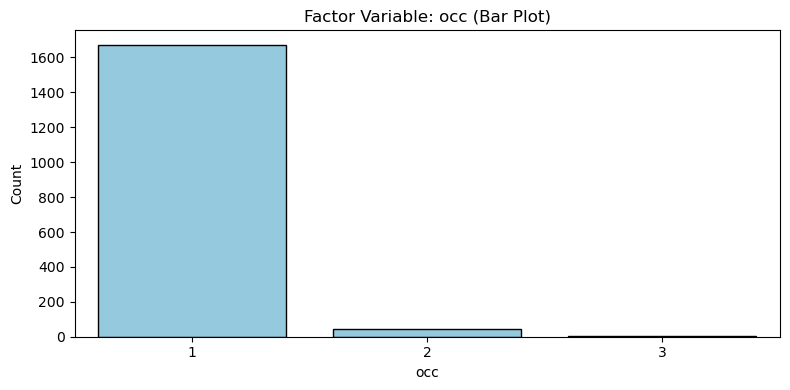

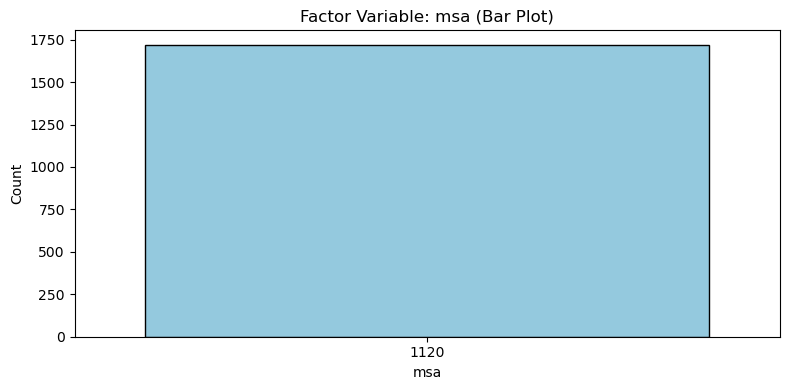

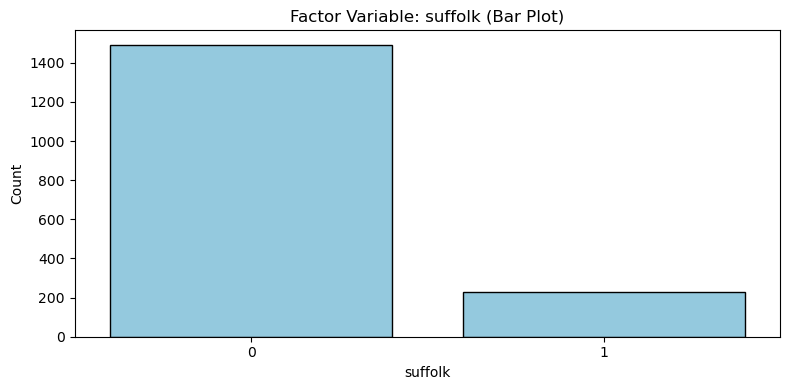

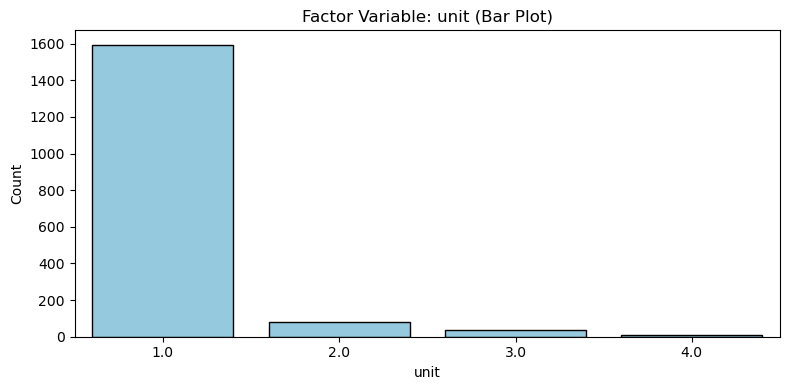

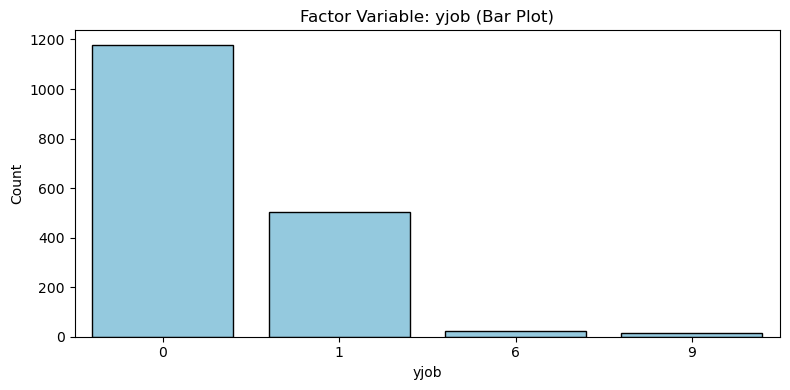

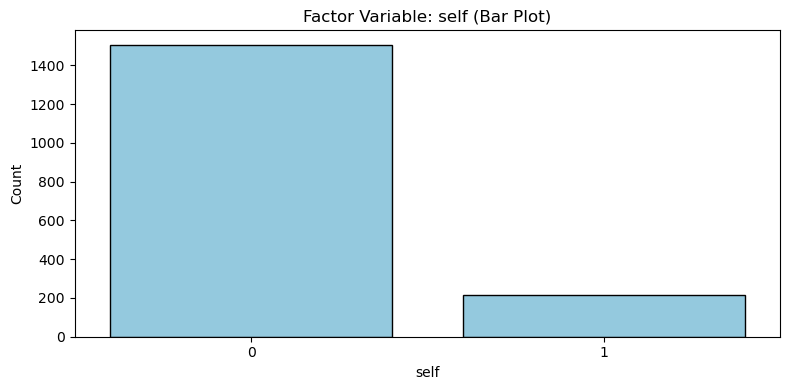

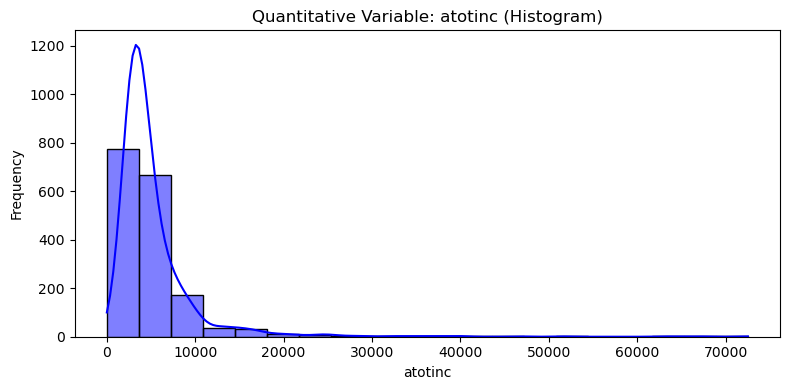

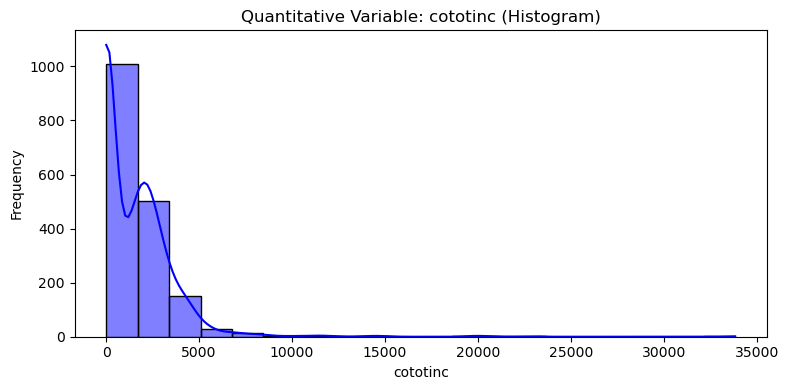

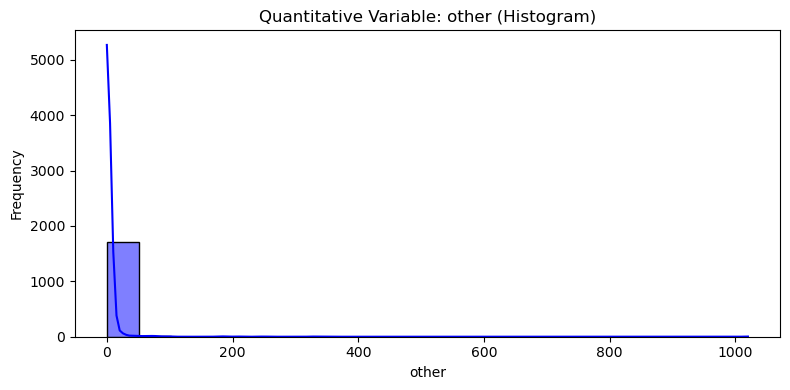

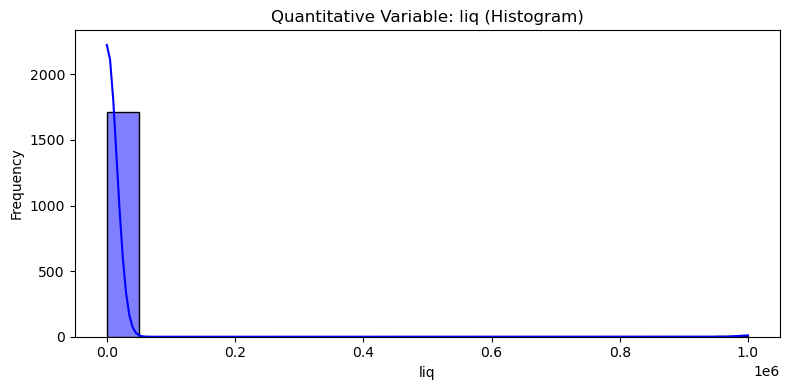

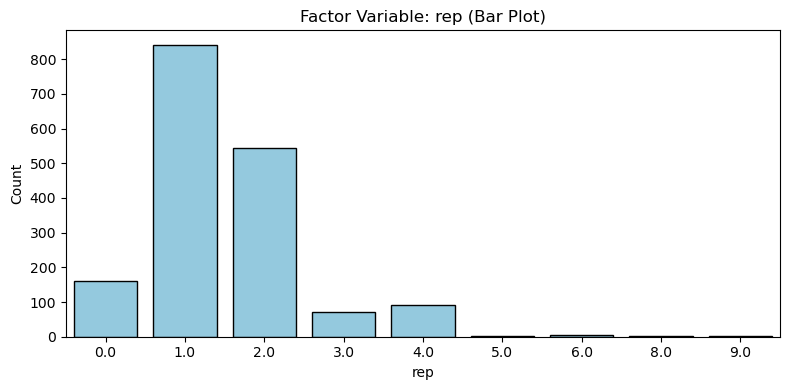

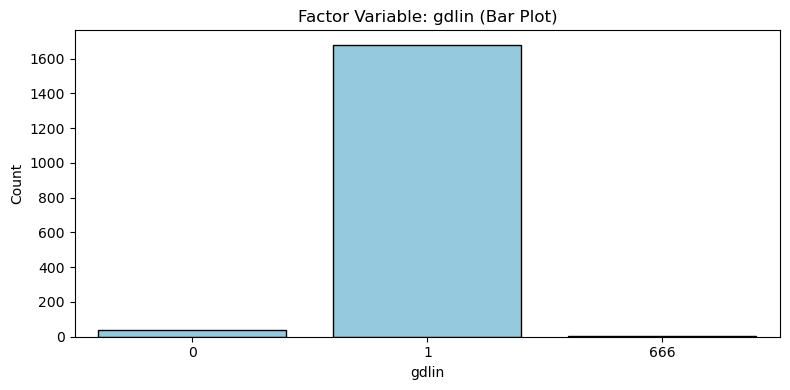

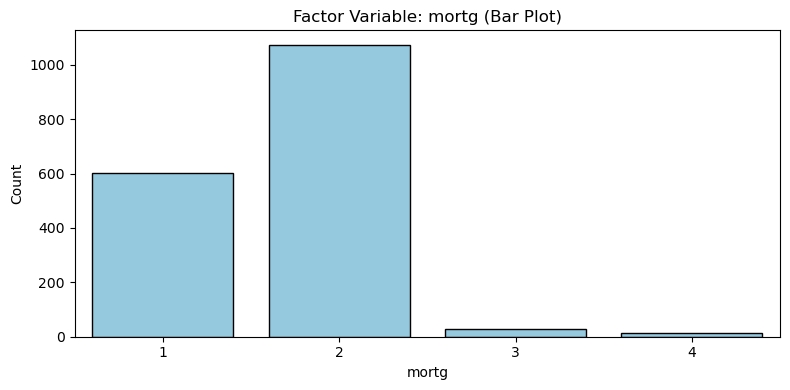

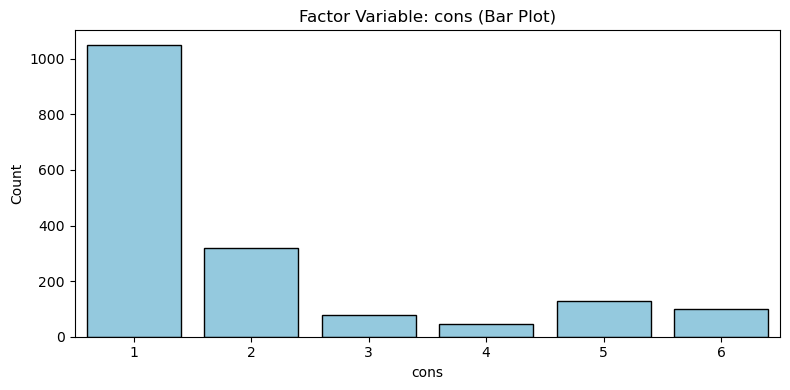

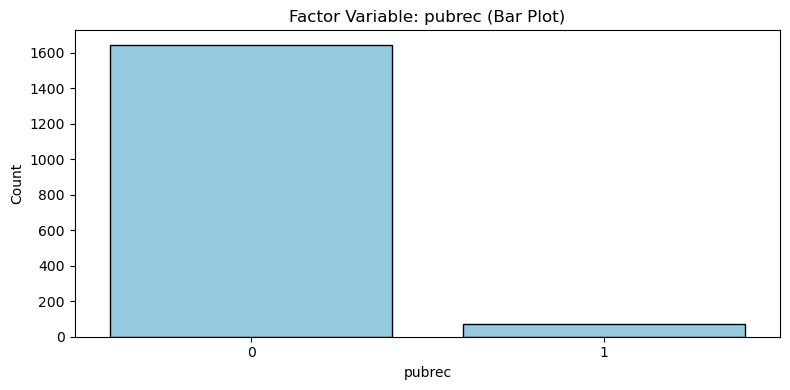

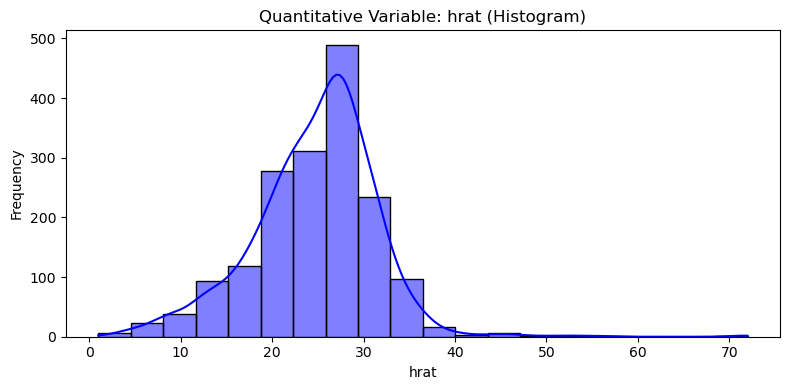

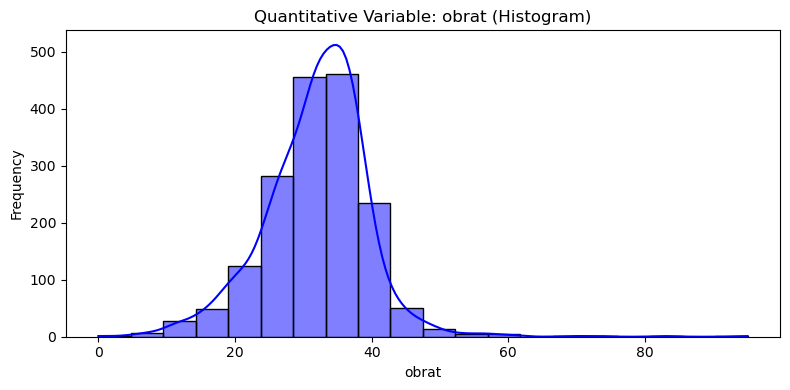

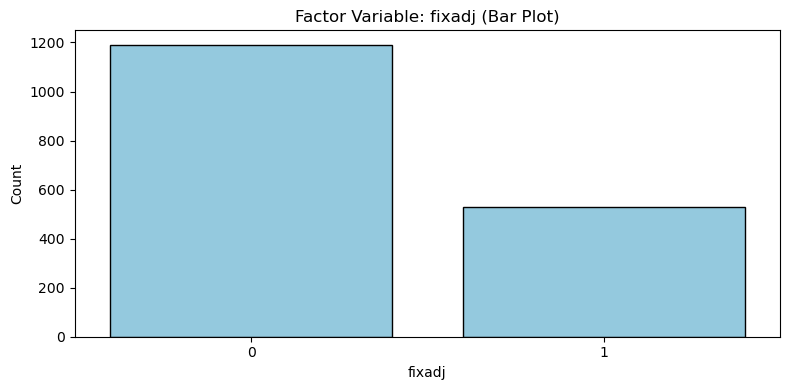

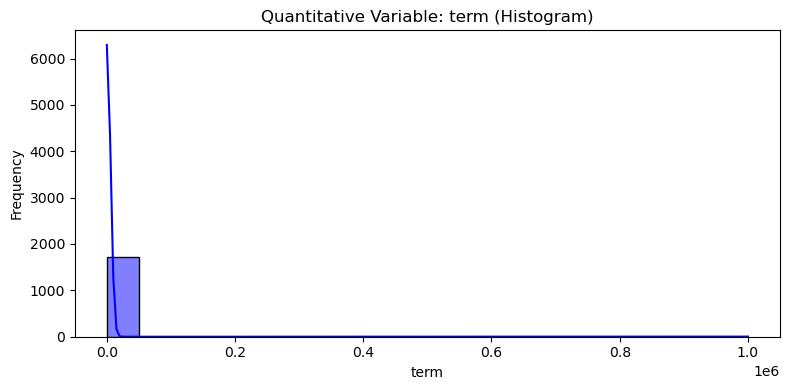

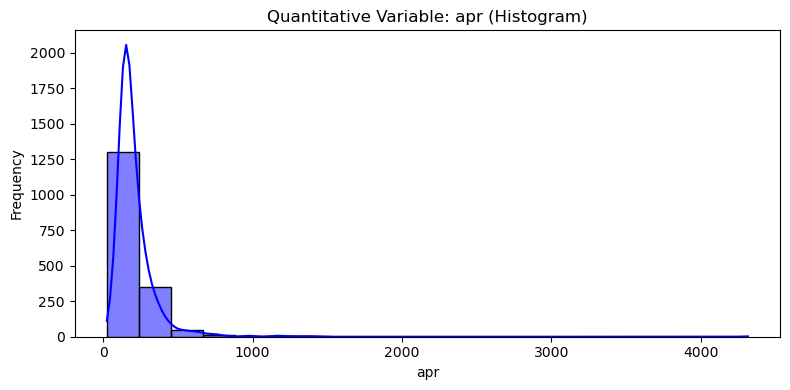

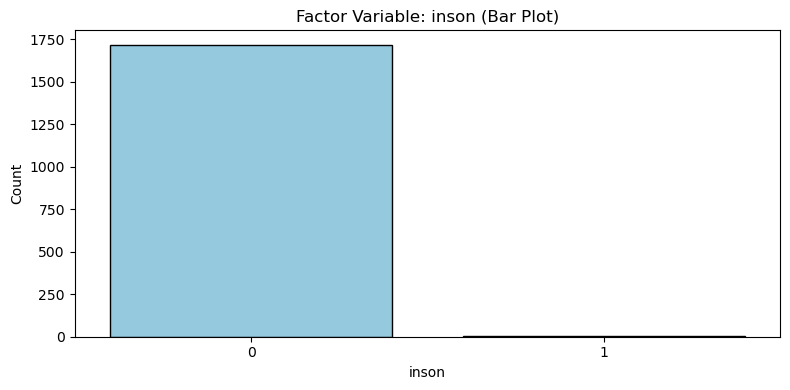

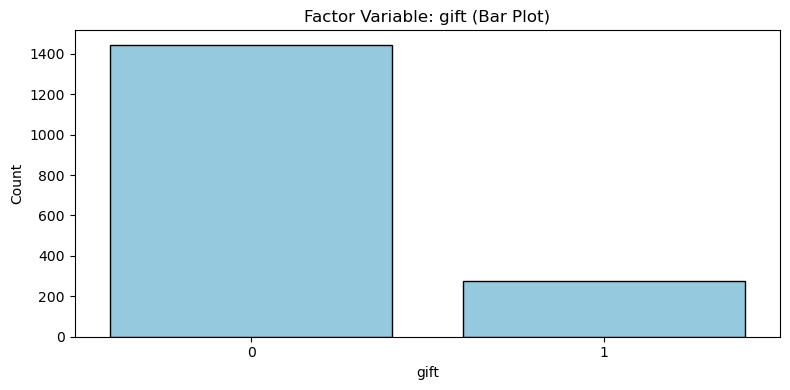

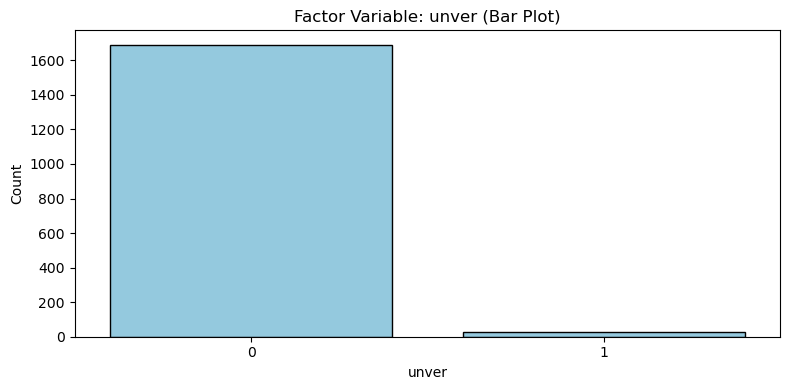

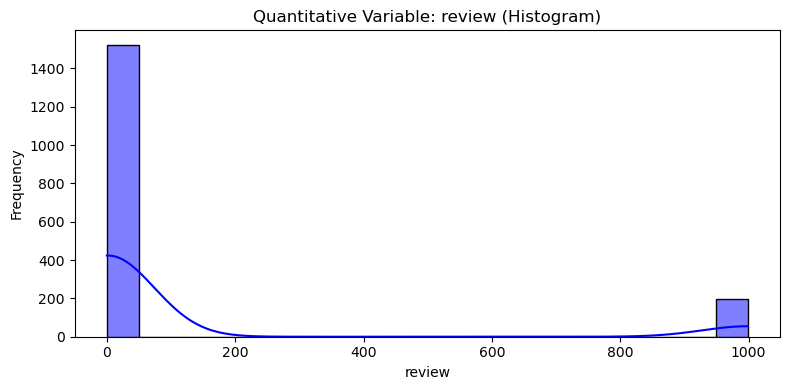

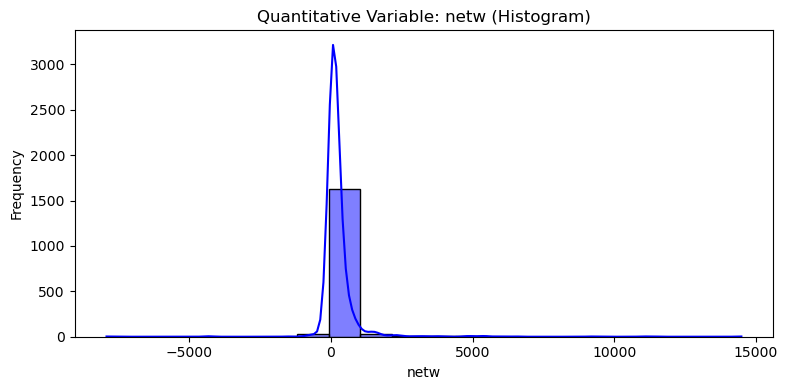

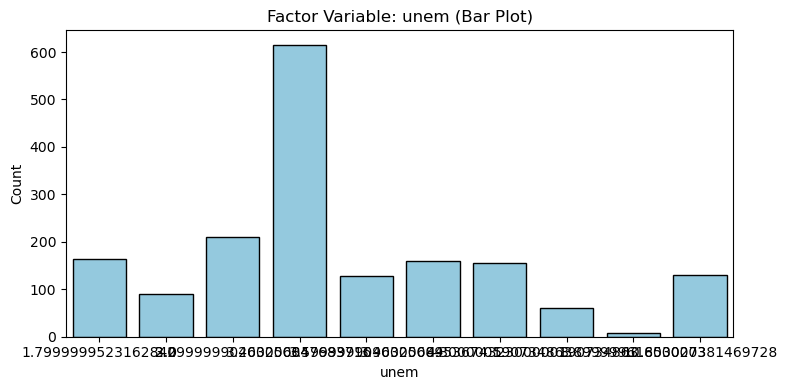

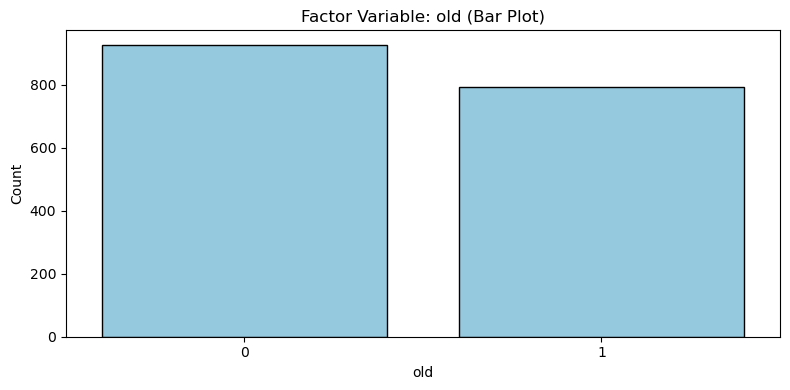

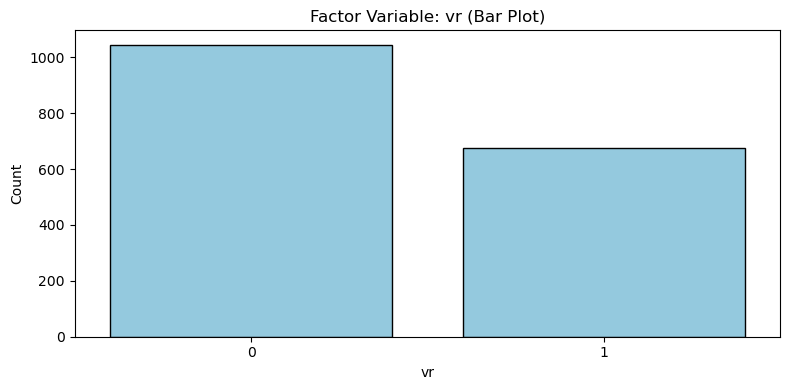

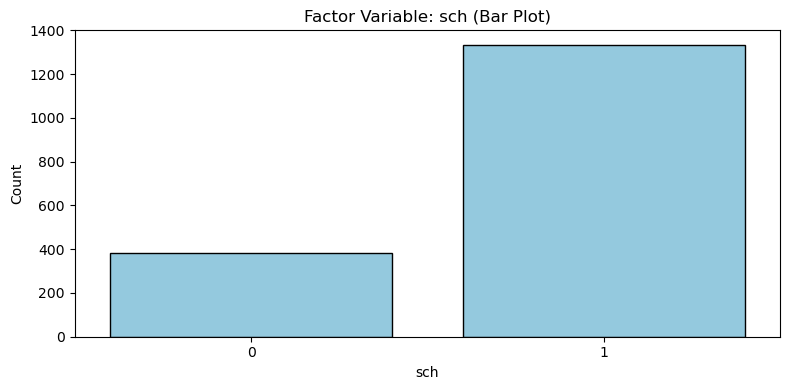

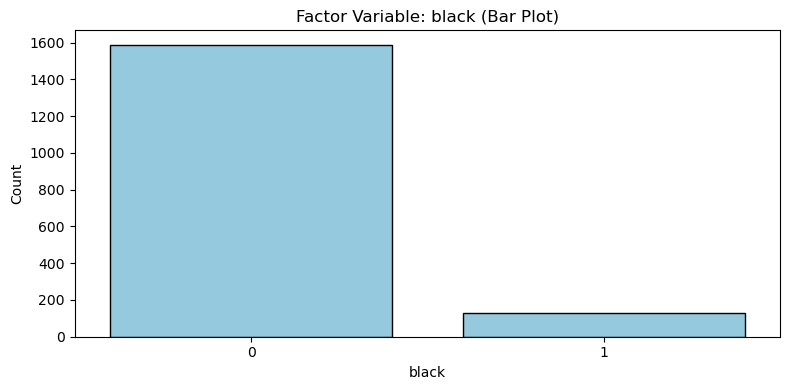

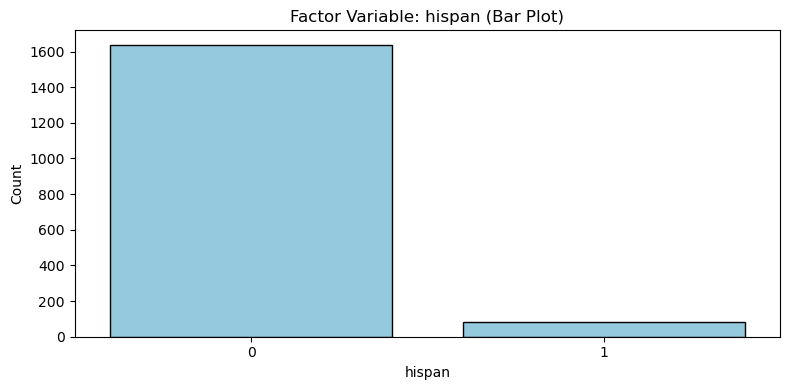

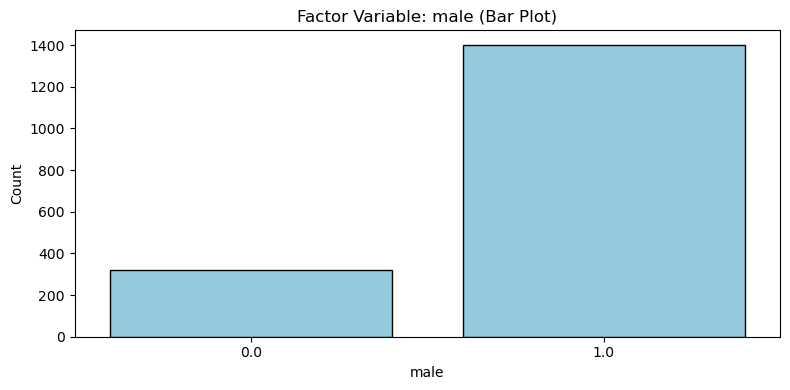

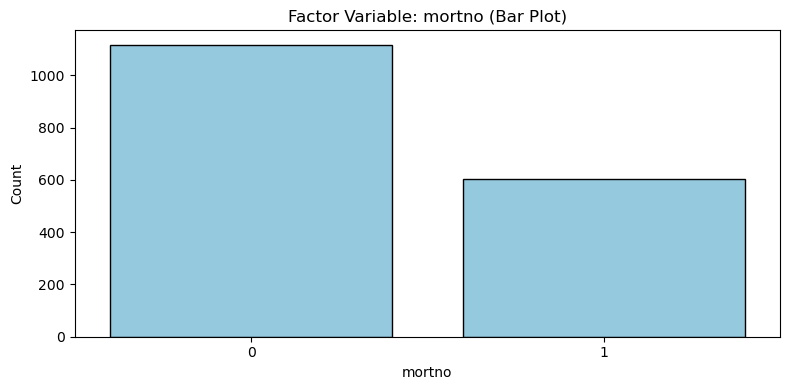

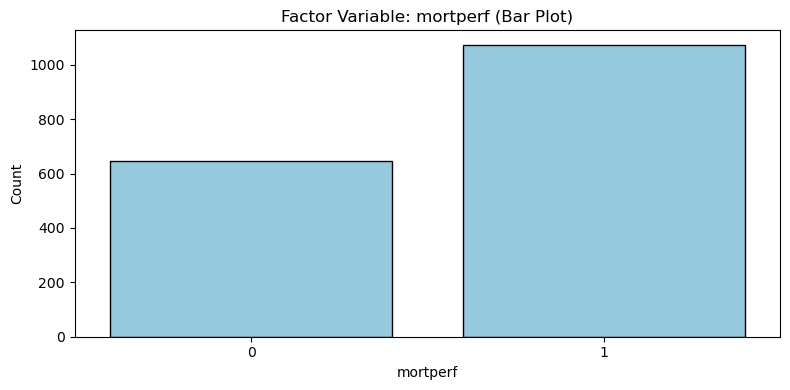

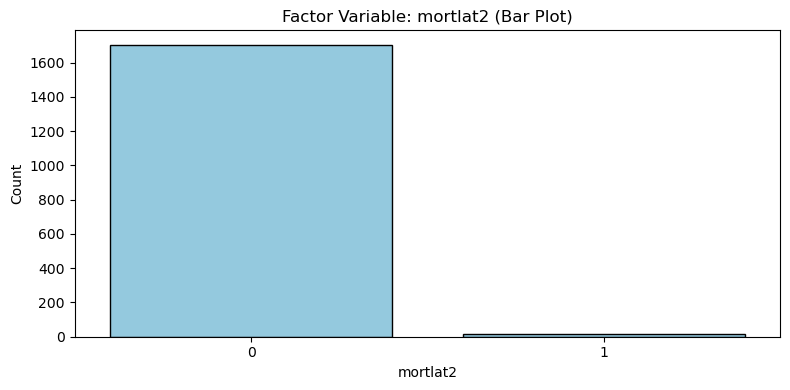

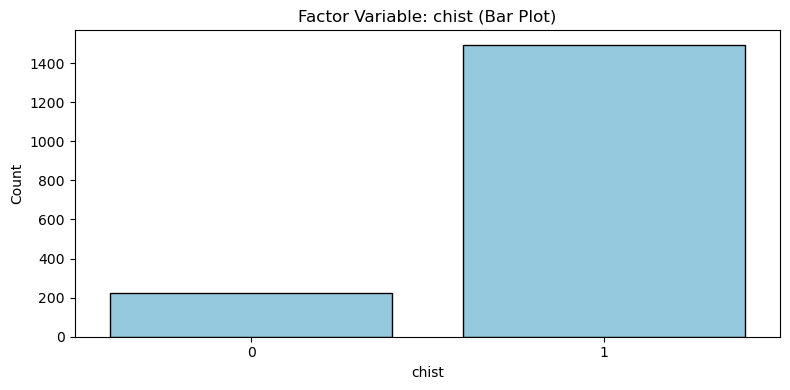

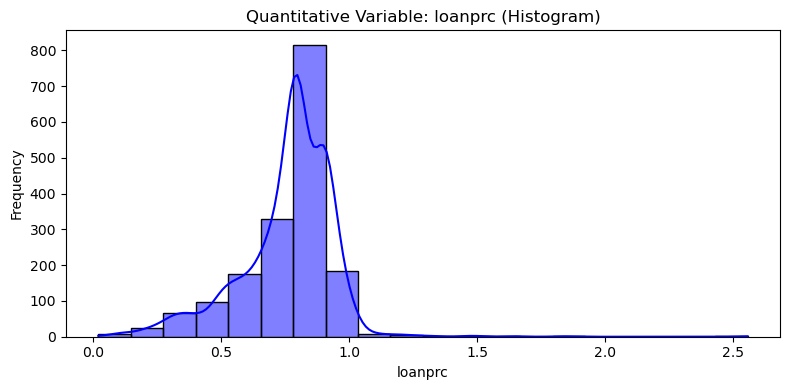

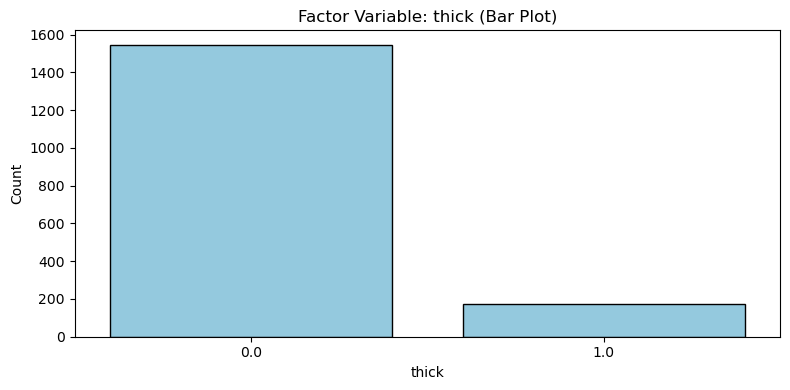

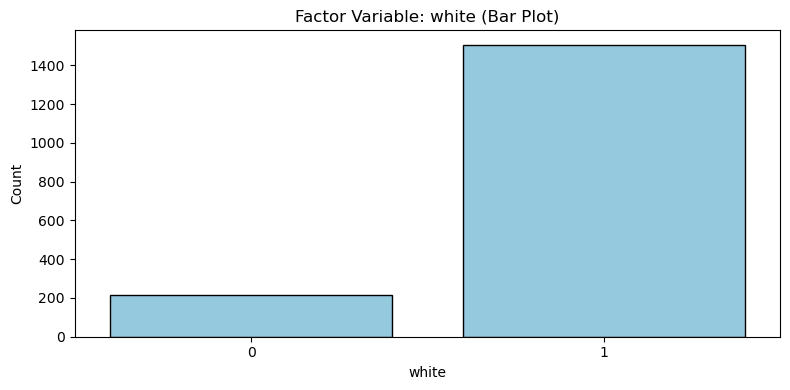

In [12]:
# Function to visualize each column - distinguish factor and quantitative variables
def visualize_columns(df):
    for col in df.columns:
        plt.figure(figsize=(8, 4))
        
        # Check the number of unique values to classify variable type
        unique_values = df[col].nunique()
        
        if unique_values <= 10:  # Likely a factor variable
            sns.countplot(x=col, data=df, color='skyblue', edgecolor='black')
            plt.title(f"Factor Variable: {col} (Bar Plot)")
            plt.xlabel(col)
            plt.ylabel('Count')
        else:  # Likely a quantitative variable
            sns.histplot(df[col], kde=True, bins=20, color='blue')
            plt.title(f"Quantitative Variable: {col} (Histogram)")
            plt.xlabel(col)
            plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

visualize_columns(loanapp)

### Notes
- `msa`: 
    - The unique value count is only 1120, which doesn't provide meaningful variability for the analysis.
    - Remove this variable.
- `emp`, `yjob`, and `unem`:
    - While these variables have fewer than 10 unique values, they represent continuous measures: years of employment (`emp`), years at the current job (`yjob`), and the unemployment rate (`unem`).
    - The low unique value count likely reflects rounded data or grouped categories but does not indicate categorical data.
    - Keep these as quantitative variables.
- `gdlin`:
    - This is a binary variable, but an unexpected value (666) indicates data entry errors.
    - Remove rows where gdlin has a value of 666.
- `liq`, `lines`, `term`, `apr`:
    - These variables have disproportionately large maximum values, likely indicating outliers or data entry errors.
    - Investigate these values further to determine if they are true outliers or data issues.
    - If confirmed to be errors, consider:
        - Removing rows with extreme values, or
        - Apply log to the variables to limit the impact of outliers.

In [13]:
loanapp = loanapp.drop('msa', axis = 1)
loanapp = loanapp[(loanapp['gdlin'] == 0) | (loanapp['gdlin'] == 1)]

### Dependent Variable
- **loanprc**: loan amount as a percentage of price

### Quantitative Predictors
- **appinc**: applicant income, \$1000s  
- **emp**: years employed in line of work  
- **yjob**: years at this job  
- **atotinc**: total monthly income  
- **cototinc**: co-applicant total monthly income  
- **hexp**: proposed housing expense  
- **other**: other financing, \$1000s  
- **liq**: liquid assets  
- **lines**: number of credit lines on reports  
- **hrat**: housing expense as a percent of total income  
- **obrat**: other obligations as a percent of total income  
- **term**: term of loan in months  
- **apr**: appraised value  
- **review**: number of times reviewed  
- **netw**: net worth  
- **unem**: unemployment rate by industry  

### Factor Predictors
- **occ**: occupancy  
- **suffolk**: =1 if property in Suffolk County  
- **typur**: type of purchaser of loan  
- **unit**: number of units in property  
- **married**: =1 if applicant married  
- **dep**: number of dependents  
- **self**: =1 if self-employed  
- **rep**: no. of credit reports  
- **gdlin**: credit history meets guidelines  
- **mortg**: credit history on mortgage payments  
- **cons**: credit history on consumer stuff  
- **pubrec**: =1 if filed bankruptcy  
- **fixadj**: fixed or adjustable rate 
- **prop**: type of property  
- **inss**: PMI sought  
- **inson**: PMI approved  
- **gift**: gift as down payment  
- **cosign**: is there a cosigner  
- **unver**: unverifiable info  
- **bd**: =1 if boarded-up value > MSA median  
- **mi**: =1 if tract inc > MSA median  
- **old**: =1 if applicant age > MSA median  
- **vr**: =1 if tract vac rte > MSA median  
- **sch**: =1 if > 12 years schooling  
- **black**: =1 if applicant black  
- **hispan**: =1 if applicant Hispanic  
- **male**: =1 if applicant male  
- **mortno**: no mortgage history  
- **mortperf**: no late mortgage payments  
- **mortlat1**: one or two late payments  
- **mortlat2**: > 2 late payments  
- **chist**: =0 if accounts delinquent >= 60 days  
- **multi**: =1 if two or more units  
- **thick**: =1 if rep > 2  
- **white**: =1 if applicant white  

In [14]:
# Dependent Variable
dependent_variable = "loanprc"

# Quantitative Predictors
quantitative_predictors = [
    "appinc",     # applicant income, $1000s
    "emp",        # years employed in line of work
    "yjob",       # years at this job
    "atotinc",    # total monthly income
    "cototinc",   # co-applicant total monthly income
    "hexp",       # proposed housing expense
    "other",      # other financing, $1000s
    "liq",        # liquid assets
    "lines",      # number of credit lines on reports
    "hrat",       # housing expense as a percent of total income
    "obrat",      # other obligations as a percent of total income
    "term",       # term of loan in months
    "apr",        # appraised value
    "review",     # number of times reviewed
    "netw",       # net worth
    "unem"        # unemployment rate by industry
]

# Factor Predictors
factor_predictors = [
    "occ",        # occupancy
    "suffolk",    # =1 if property in Suffolk County
    "typur",      # type of purchaser of loan
    "unit",       # number of units in property
    "married",    # =1 if applicant married
    "dep",        # number of dependents
    "self",       # =1 if self-employed
    "rep",        # no. of credit reports
    "gdlin",      # credit history meets guidelines
    "mortg",      # credit history on mortgage payments
    "cons",       # credit history on consumer stuff
    "pubrec",     # =1 if filed bankruptcy
    "fixadj",     # fixed or adjustable rate?
    "prop",       # type of property
    "inss",       # PMI sought
    "inson",      # PMI approved
    "gift",       # gift as down payment
    "cosign",     # is there a cosigner
    "unver",      # unverifiable info
    "bd",         # =1 if boarded-up value > MSA median
    "mi",         # =1 if tract inc > MSA median
    "old",        # =1 if applicant age > MSA median
    "vr",         # =1 if tract vac rte > MSA median
    "sch",        # =1 if > 12 years schooling
    "black",      # =1 if applicant black
    "hispan",     # =1 if applicant Hispanic
    "male",       # =1 if applicant male
    "mortno",     # no mortgage history
    "mortperf",   # no late mortgage payments
    "mortlat1",   # one or two late payments
    "mortlat2",   # > 2 late payments
    "chist",      # =0 if accounts delinquent >= 60 days
    "multi",      # =1 if two or more units
    "thick",      # =1 if rep > 2
    "white"       # =1 if applicant white
]

## 1. Variable Selection: 

### (a) Using the Boruta Algorithm identify the top 5-10 quantitative predictors (could be fewer 5 depending on your finding). 

#### Boruta using BorutaPy

In [15]:
### Boruta using `BorutaPy`

# Prepare data
loanapp_Y = loanapp[dependent_variable]
loanapp_X = loanapp[quantitative_predictors]

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

rf = RandomForestRegressor(max_depth=5)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=10, two_step=True) # `two_step` uses Bonferroni

# Run algorithm
boruta.fit(loanapp_X, loanapp_Y)
    
# Print confirmed columns
selected_features = loanapp_X.columns[boruta.support_]
print(f"Top predictors selected by Boruta: {list(selected_features)}")

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	8
Iteration:

In [16]:
# Compile feature decisions
boruta_keep = ['Confirmed' if c else
               'Tentative' if t else
               'Reject' for c, t in zip(boruta.support_, boruta.support_weak_)]

# Zip quantitative features, ranking, and boolean
boruta_features = zip(loanapp_X.columns, boruta.ranking_, boruta_keep)

# Combine results and print
for feat in boruta_features:
    print('Feature: {:<20} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: appinc               Rank: 1,  Keep: Confirmed
Feature: emp                  Rank: 8,  Keep: Reject
Feature: yjob                 Rank: 9,  Keep: Reject
Feature: atotinc              Rank: 3,  Keep: Reject
Feature: cototinc             Rank: 4,  Keep: Reject
Feature: hexp                 Rank: 1,  Keep: Confirmed
Feature: other                Rank: 1,  Keep: Confirmed
Feature: liq                  Rank: 1,  Keep: Confirmed
Feature: lines                Rank: 5,  Keep: Reject
Feature: hrat                 Rank: 2,  Keep: Reject
Feature: obrat                Rank: 1,  Keep: Confirmed
Feature: term                 Rank: 1,  Keep: Confirmed
Feature: apr                  Rank: 1,  Keep: Confirmed
Feature: review               Rank: 6,  Keep: Reject
Feature: netw                 Rank: 1,  Keep: Confirmed
Feature: unem                 Rank: 7,  Keep: Reject


#### Boruta using R

            meanImp  medianImp     minImp     maxImp   normHits  decision
appinc   15.0838498 15.2275123  9.1565717 20.4515120 1.00000000 Confirmed
emp       3.1532094  3.0455727  0.3761917  5.5413466 0.82828283 Confirmed
yjob      2.4542927  2.3674782  0.2454221  5.2999727 0.57575758 Tentative
atotinc  11.3253852 11.7371915  4.1671988 14.5870971 1.00000000 Confirmed
cototinc  7.5486756  7.9107482  3.8020933 11.2037665 1.00000000 Confirmed
hexp     23.0344119 22.9652161 19.4580149 26.2537386 1.00000000 Confirmed
other    -2.8031550 -2.8974716 -4.6738410 -0.8003849 0.00000000  Rejected
liq      26.4202453 26.3055409 22.2648654 31.1334374 1.00000000 Confirmed
lines     1.1716798  0.8491024 -1.0482079  3.6636616 0.01010101  Rejected
hrat     10.3098767 10.4035070  7.2742504 13.3178135 1.00000000 Confirmed
obrat     9.8981832  9.8285557  7.3116399 12.3746795 1.00000000 Confirmed
term      4.7045216  4.7167372  2.2367642  7.3802437 0.95959596 Confirmed
apr      31.4170462 31.1699807 26.8032


次のパッケージを付け加えます: ‘dplyr’

以下のオブジェクトは ‘package:stats’ からマスクされています:

    filter, lag

以下のオブジェクトは ‘package:base’ からマスクされています:

    intersect, setdiff, setequal, union

 1. run of importance source...
 2. run of importance source...
 3. run of importance source...
 4. run of importance source...
 5. run of importance source...
 6. run of importance source...
 7. run of importance source...
 8. run of importance source...
 9. run of importance source...
 10. run of importance source...
 11. run of importance source...
After 11 iterations, +7.7 secs: 
 confirmed 9 attributes: appinc, apr, atotinc, cototinc, hexp and 4 more;
 rejected 2 attributes: other, unem;
 still have 5 attributes left.

 12. run of importance source...
 13. run of importance source...
 14. run of importance source...
 15. run of importance source...
After 15 iterations, +10 secs: 
 rejected 1 attribute: lines;
 still have 4 attributes left.

 16. run of importance source...
 17. run of importance source...
 18. run of i

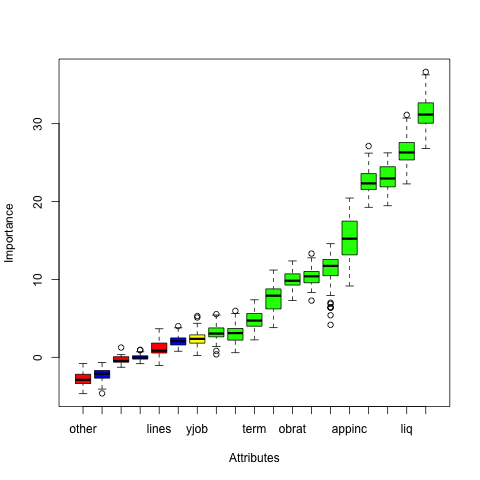

In [17]:
%%R -i loanapp
    
library(Boruta)
library(dplyr)
set.seed(90095)
    
# Define the dependent and independent variables
dependent_variable <- loanapp$loanprc  # Target variable
    
# Quantitative Predictors
quantitative_predictors <- c(
    "appinc",  # applicant income, $1000s
    "emp",     # years employed in line of work
    "yjob",    # years at this job
    "atotinc", # total monthly income
    "cototinc",# co-applicant total monthly income
    "hexp",    # proposed housing expense
    "other",   # other financing, $1000s
    "liq",     # liquid assets
    "lines",   # number of credit lines on reports
    "hrat",    # housing expense as a percent of total income
    "obrat",   # other obligations as a percent of total income
    "term",    # term of loan in months
    "apr",     # appraised value
    "review",  # number of times reviewed
    "netw",    # net worth
    "unem"     # unemployment rate by industry
)

X <- loanapp[, quantitative_predictors]
loanapp_boruta <- Boruta(X, dependent_variable, doTrace = 2)
    
plot(loanapp_boruta, sort = TRUE)
attStats(loanapp_boruta)

Because `other` was rejected in the R version of Boruta, we will remove it from `selected_features`.

In [16]:
selected_features = selected_features.drop('other')

### (b) Using standard techniques, identify at least 2-3 factor variables to include as predictors. The combined predictors from parts (a) and (b) are the ones you will work with going forward in the analysis for parts (2) and (3).

To identify factor variables, we will use statistical tests such as ANOVA for multi-category variables and t-tests for binary variables to evaluate their significance to the dependent variable. Then, we will incorporate the variable description and our domain knowledge to select the final feature variables to include as predictors.

In [17]:
# List to store significant factor variables
significant_factors = []

# Loop through factor predictors
for factor in factor_predictors:
    groups = []
    for level in loanapp[factor].unique():
        groups.append(loanapp[loanapp[factor] == level][dependent_variable])
        
    # Perform ANOVA if more than two groups
    if len(groups) > 2:
        F, p = stats.f_oneway(*groups)
    
    # For binary variables, use t-test
    elif len(groups) == 2:
        F, p = stats.ttest_ind(groups[0], groups[1])
    else:
        continue
    
    # Check if p-value is significant
    if p < 0.05:
        significant_factors.append(factor)

print(f"Selected factor variables: {significant_factors}")

Selected factor variables: ['suffolk', 'unit', 'dep', 'rep', 'gdlin', 'mortg', 'pubrec', 'fixadj', 'prop', 'inss', 'gift', 'bd', 'mi', 'old', 'sch', 'black', 'hispan', 'mortno', 'mortperf', 'mortlat2', 'multi', 'thick', 'white']


After conducting ANOVA and t-tests on our factor variables to assess their significance with respect to the dependent variable `loanprc`, we identified 23 significant predictors out of the 35 factors considered. From these significant variables, we selected the following six factor predictors for our analysis: `male`, `married`, `sch`, and `fixadj`.

The variable `sch` indicates whether an applicant has more than 12 years of schooling and was also statistically significant. Education level can be a proxy for socioeconomic status and financial literacy, which may impact an applicant's creditworthiness and the loan pricing they receive.

The variable `fixadj`, representing whether the loan has a fixed or adjustable interest rate, was also significant. This factor is directly related to the loan terms and can influence the loan-to-price ratio since different interest structures carry different levels of risk and cost over time.

Although `male` and `married` were not statistically significant according to our tests, we included them based on domain knowledge. Gender (`male`) and marital status (`married`) are important demographic factors that could influence loan pricing due to societal factors and lending practices. Including these variables allows us to explore potential biases or differential treatment that may not be immediately evident through statistical significance alone.

In [18]:
# 'selected_features' contains the quantitative predictors selected by Boruta
selected_qpred = selected_features.tolist()

# Our selected factor predictors
selected_fpred = ['male', 'married', 'sch', 'fixadj']

# Combine both lists into 'final_predictors'
final_predictors = selected_qpred + selected_fpred

# Create a DataFrame with the dependent variable and final predictors
loanapp_selected = loanapp[[dependent_variable] + final_predictors]

loanapp_selected.head()

loanprc  appinc    hexp    liq      obrat   term    apr   netw  male  \
2  0.895105      84  1371.0   37.0  26.000000  180.0  145.0   40.0   1.0   
3  0.600000      36   839.0   19.0  37.000000  360.0  110.0  158.0   1.0   
4  0.895522      59  1341.0   31.0  32.099998  360.0  135.0   69.0   1.0   
5  0.804348      63  1122.0  169.0  33.000000  360.0  144.0  262.0   1.0   
6  0.898089      72  1870.0   38.0  36.000000  360.0  162.0   46.0   1.0   

   married  sch  fixadj  
2      0.0    1       0  
3      1.0    1       0  
4      1.0    0       0  
5      0.0    0       0  
6      0.0    1       0

### Summary of Progress

1. **Dataset Overview**:
   - Dataset: Wooldridge `loanapp` dataset (1,989 observations, 59 variables).
   - Dependent Variable: `loanprc` (loan amount as a percentage of property price).

2. **Preprocessing**:
   - Removed columns causing perfect multicollinearity (`loanamt`, `price`).
   - Dropped `min30` due to excessive missing values (~20% of observations).
   - Focused on approved loans only by subsetting `approve = 1` and dropping outcome-related variables (`action`, `reject`, `approve`).
   - Removed invalid entries in `gdlin` (unexpected value of 666).
   - Dropped irrelevant variable `msa` (low variability and relevance).

3. **Variable Categorization**:
   - Quantitative variables: Selected based on unique values and domain relevance.
   - Factor variables: Identified using unique counts and variable descriptions.

4. **Feature Selection**:
   - **Quantitative Variables**: Selected using Boruta (Python and R versions). Dropped `other` due to rejection in R Boruta analysis.
   - **Factor Variables**: Selected based on ANOVA/t-tests and domain knowledge. Final selected factors include `male`, `married`, `sch`, and `fixadj`.

5. **Challenges & Solutions**:
   - **Outliers**: Identified in `liq`, `term`, and `apr`. Addressed via removal with detailed explanations for each.
   - **Non-Normality**: Skewness and non-linearities will be addressed later through transformations and model diagnostics.
   - **Multicollinearity**: Addressed perfect multicollinearity; partial multicollinearity will be handled during regression diagnostics.
   - **Categorical `term`**: Re-categorized based on its discrete nature and Q-Q plot insights.

6. **Next Steps**:
   - Perform transformations on skewed variables (e.g., log-transformation for `liq` or `apr`).
   - Reassess distributions and check for normality in the dependent variable (`loanprc`) and predictors.
   - Explore correlations and potential interactions between predictors.
   - Build preliminary regression models and evaluate multicollinearity (VIF), residual diagnostics, and model fit.
   - Address potential heteroskedasticity or non-linearity in residuals.

## 2. Descriptive Analysis: Perform a univariate analysis of your variables following the steps below.

### (a) Begin by providing a descriptive analysis of your variables. This should include things like histograms, quantile plots, correlation plots, etc.

In [19]:
# Descriptive statistics for quantitative variables
quantitative_vars = selected_qpred + [dependent_variable]
loanapp_selected[quantitative_vars].describe()

appinc          hexp             liq        obrat           term  \
count  1717.000000   1717.000000     1717.000000  1717.000000    1717.000000   
mean     83.945253   1516.117239     4748.764476    31.897432     922.644948   
std      80.873563    850.285578    68113.760581     7.683791   24125.053036   
min       4.000000    154.000000        0.000000     0.000000       8.000000   
25%      49.000000   1056.000000       21.000000    27.900000     360.000000   
50%      65.000000   1327.000000       40.000000    32.500000     360.000000   
75%      89.000000   1735.000000       89.000000    36.200001     360.000000   
max     870.000000  10798.000000  1000000.000000    95.000000  999999.375000   

               apr          netw      loanprc  
count  1717.000000   1717.000000  1717.000000  
mean    209.328305    246.660333     0.759417  
std     162.880657    790.106515     0.184381  
min      25.000000  -7919.000000     0.021053  
25%     138.000000     46.000000     0.689362  
50%     170.000000    100.000000     0.800000  
75%     235.000000    238.000000     0.897727  
max    4316.000000  14488.000000     2.555248

- Variables like `hexp`, and `appinc` show positive skewness and would benefit from log transformations.
- `liq` and `term` contains clear data entry errors and requires cleaning; the standard deviation is absurdly high, and the max value is clearly unrealistic (e.g., 999,999 months).
- Outliers in `apr` and `netw` should be investigated and possibly capped.
- Most variables except `obrat` and `loanprc` are highly skewed or contain extreme values.

In [20]:
# Frequency counts for categorical variables
for col in selected_fpred:
    print(f"Value counts for {col}:\n{loanapp_selected[col].value_counts()}\n")

Value counts for male:
male
1.0    1399
0.0     318
Name: count, dtype: int64

Value counts for married:
married
1.0    1149
0.0     568
Name: count, dtype: int64

Value counts for sch:
sch
1    1332
0     385
Name: count, dtype: int64

Value counts for fixadj:
fixadj
0    1188
1     529
Name: count, dtype: int64



- Potential bias towards male applicants.
- The representation of unmarried applicants is more reasonable than other variables.
- `sch` may correlate with other financial metrics like `appinc`, reasonable distribution.
- `fixadj`: According to Investopedia, fixed-rate mortgages are more prevalent than adjustable-rate mortgages in the US. From this, we see that `0` represents fixed-rate mortgages and `1` represents adjustable-rate mortgages.

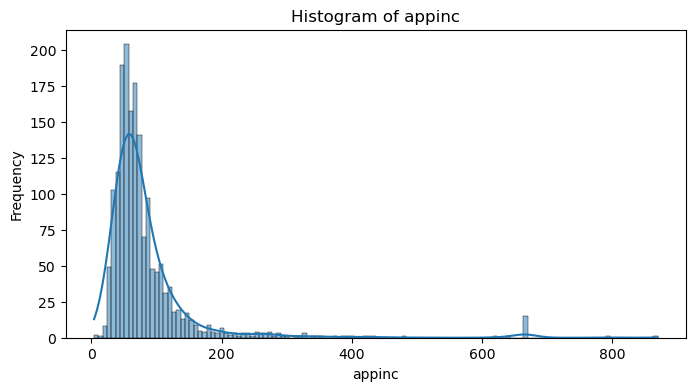

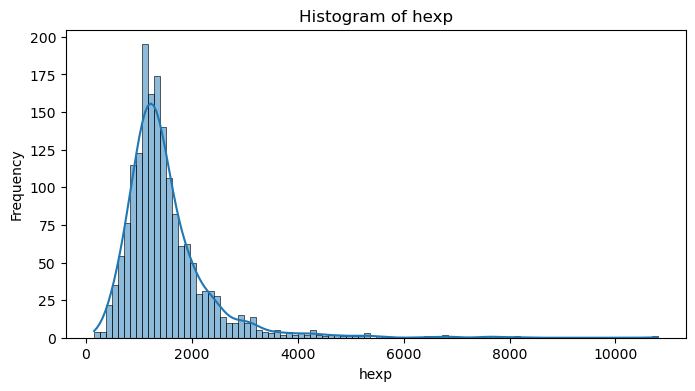

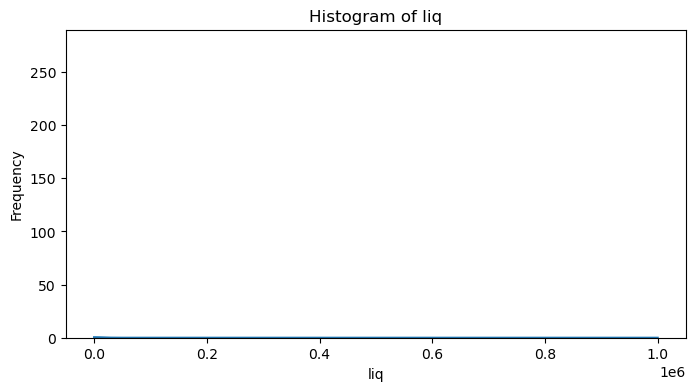

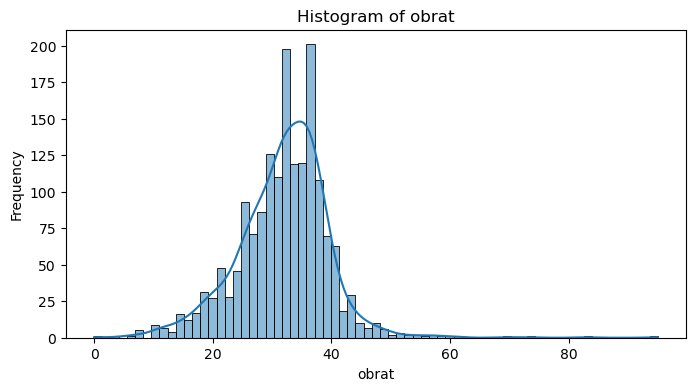

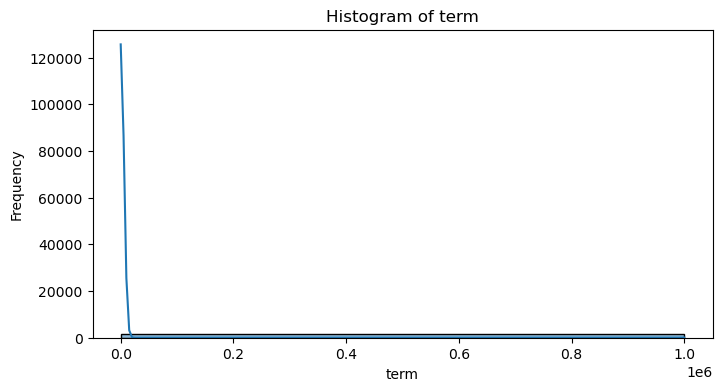

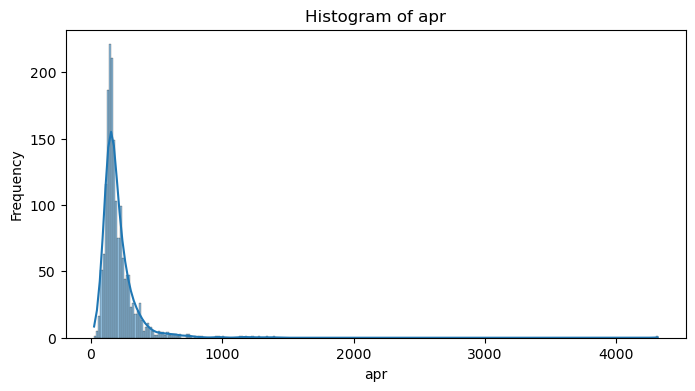

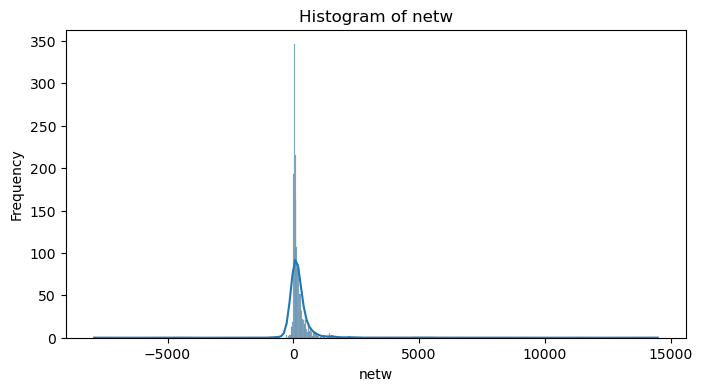

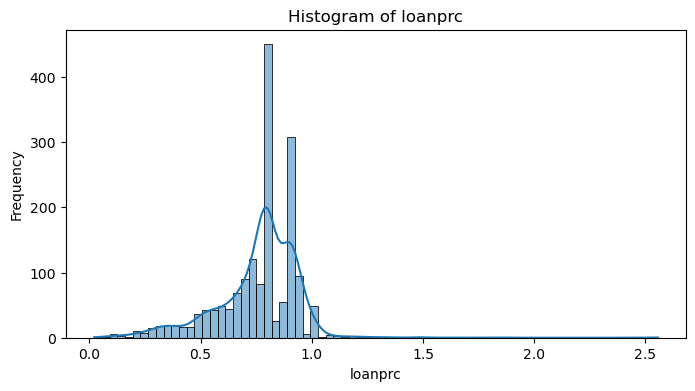

In [21]:
# Histogram with density for quantitative variables
for col in quantitative_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(loanapp_selected[col], kde=True, bins='fd')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

We can confirm our observations made in the descriptive statistics; there is an apparent outlier affecting `liq` and `term`. We should remove them immediately.

In [22]:
# Remove extreme outliers for liq and term based on descriptive stats and histogram
loanapp_selected = loanapp_selected[(loanapp_selected['liq'] != 1000000) & (loanapp_selected['term'] != 999999.375)]

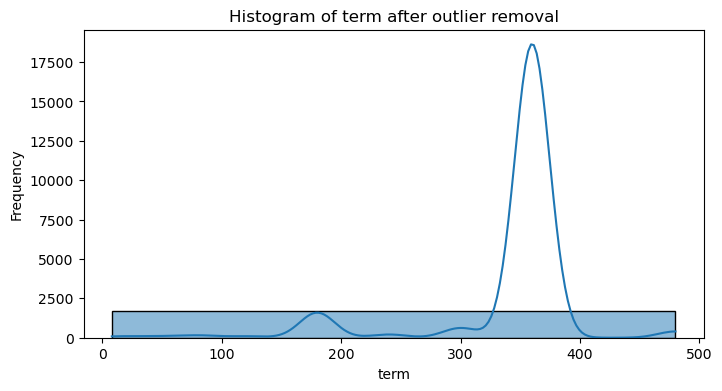

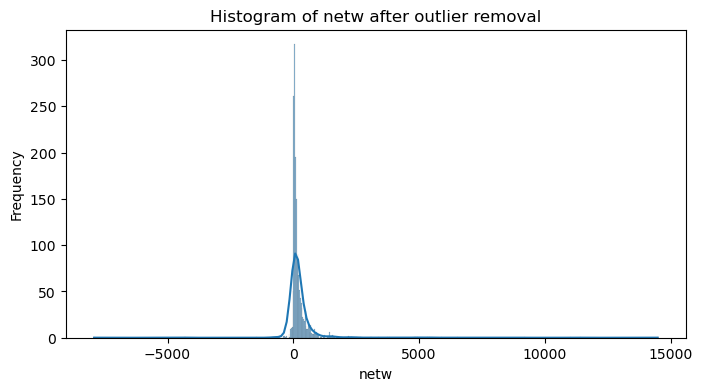

In [23]:
# Histogram after removing extreme outliers
for col in quantitative_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(loanapp_selected[col], kde=True, bins='fd')
    plt.title(f'Histogram of {col} after outlier removal')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

- Removing outliers has improved the distribution significantly.
- Variables like `appinc`, `hexp`, `liq`, and `apr` remain positively skewed, indicating potential for transformation.

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

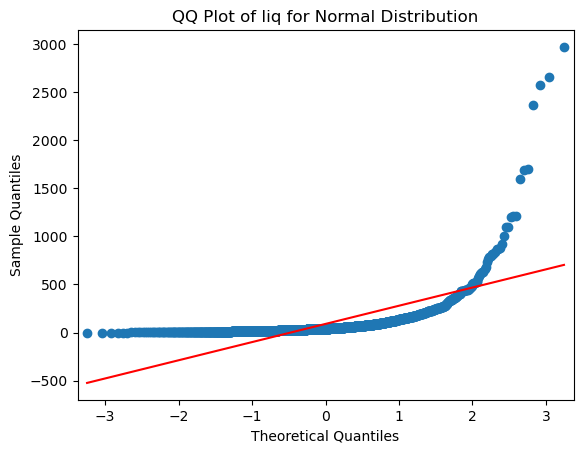

<Figure size 600x600 with 0 Axes>

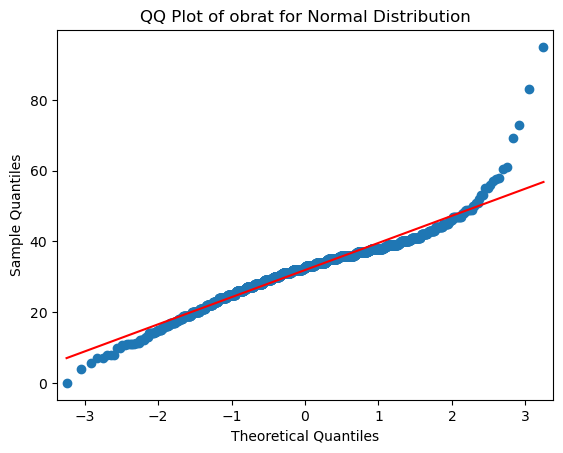

<Figure size 600x600 with 0 Axes>

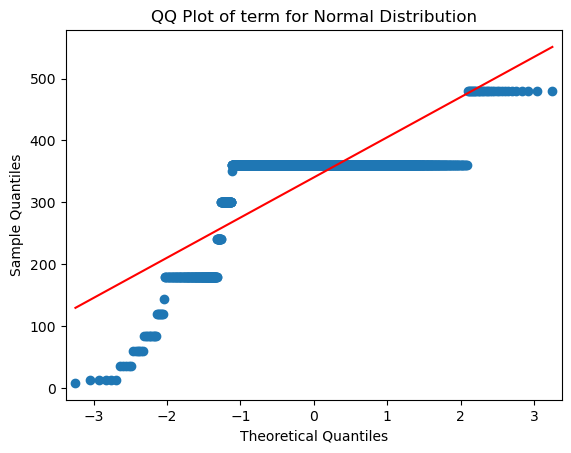

<Figure size 600x600 with 0 Axes>

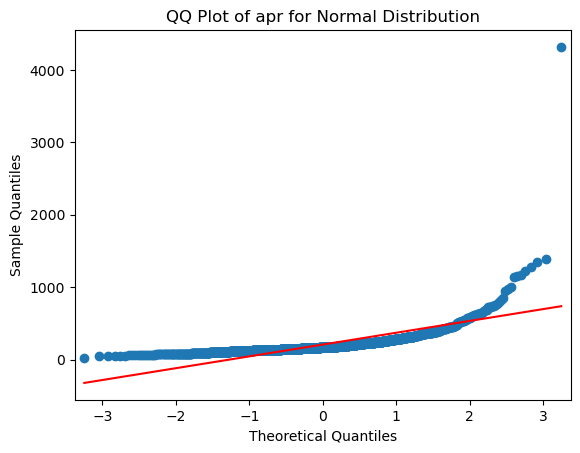

<Figure size 600x600 with 0 Axes>

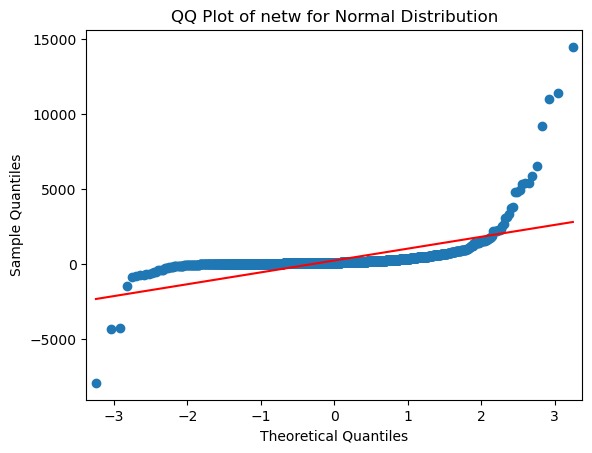

<Figure size 600x600 with 0 Axes>

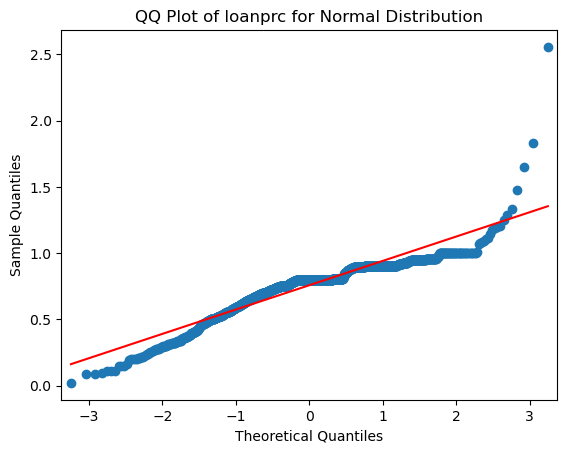

In [24]:
# Q-Q plots for quantitative variables
for col in quantitative_vars:
    plt.figure(figsize=(6, 6))
    sm.qqplot(loanapp_selected[col], line='s')  # Generate QQ plot
    plt.title(f'QQ Plot of {col} for Normal Distribution')
    plt.show()

- Even after our outlier removal after descriptive statistics/histogram, we still see outliers for `apr`; it looks like a single point.
- `appinc`, `hexp`, `liq`, and `apr` are right skewed.
- Based on the shape of the Q-Q plot, we should consider treating `term` as a categorical variable or discretized rather than continuous.
- `obrat` is the closest to a normal distribution.

In [26]:
# Remove extreme outliers for apr based on Q-Q Plot
loanapp_selected = loanapp_selected[loanapp_selected['apr'] != loanapp_selected['apr'].max()]

<Figure size 600x600 with 0 Axes>

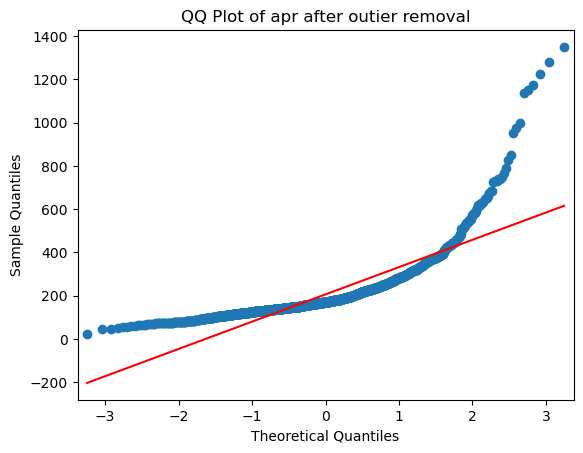

In [27]:
# Q-Q plot of apr after outier removal
plt.figure(figsize=(6, 6))
sm.qqplot(loanapp_selected['apr'], line='s')
plt.title(f'QQ Plot of apr after outier removal')
plt.show()

In [28]:
# Check unique values and # of unique values in term
print(loanapp_selected['term'].unique())
print(len(loanapp_selected['term'].unique()))

[180. 360. 120. 240.  60. 300. 480.  36.  12. 144.  84. 350.   8.]
13


Due to the limited number of unique values, we should recategorize `term` as a factor variable.

In [29]:
print(quantitative_vars)
print(selected_qpred)
print(selected_fpred)

['appinc', 'hexp', 'liq', 'obrat', 'term', 'apr', 'netw', 'loanprc']
['appinc', 'hexp', 'liq', 'obrat', 'term', 'apr', 'netw']
['male', 'married', 'sch', 'fixadj']


In [30]:
quantitative_vars.remove('term')
selected_qpred.remove('term')
selected_fpred.append('term')

print(quantitative_vars)
print(selected_qpred)
print(selected_fpred)

['appinc', 'hexp', 'liq', 'obrat', 'apr', 'netw', 'loanprc']
['appinc', 'hexp', 'liq', 'obrat', 'apr', 'netw']
['male', 'married', 'sch', 'fixadj', 'term']


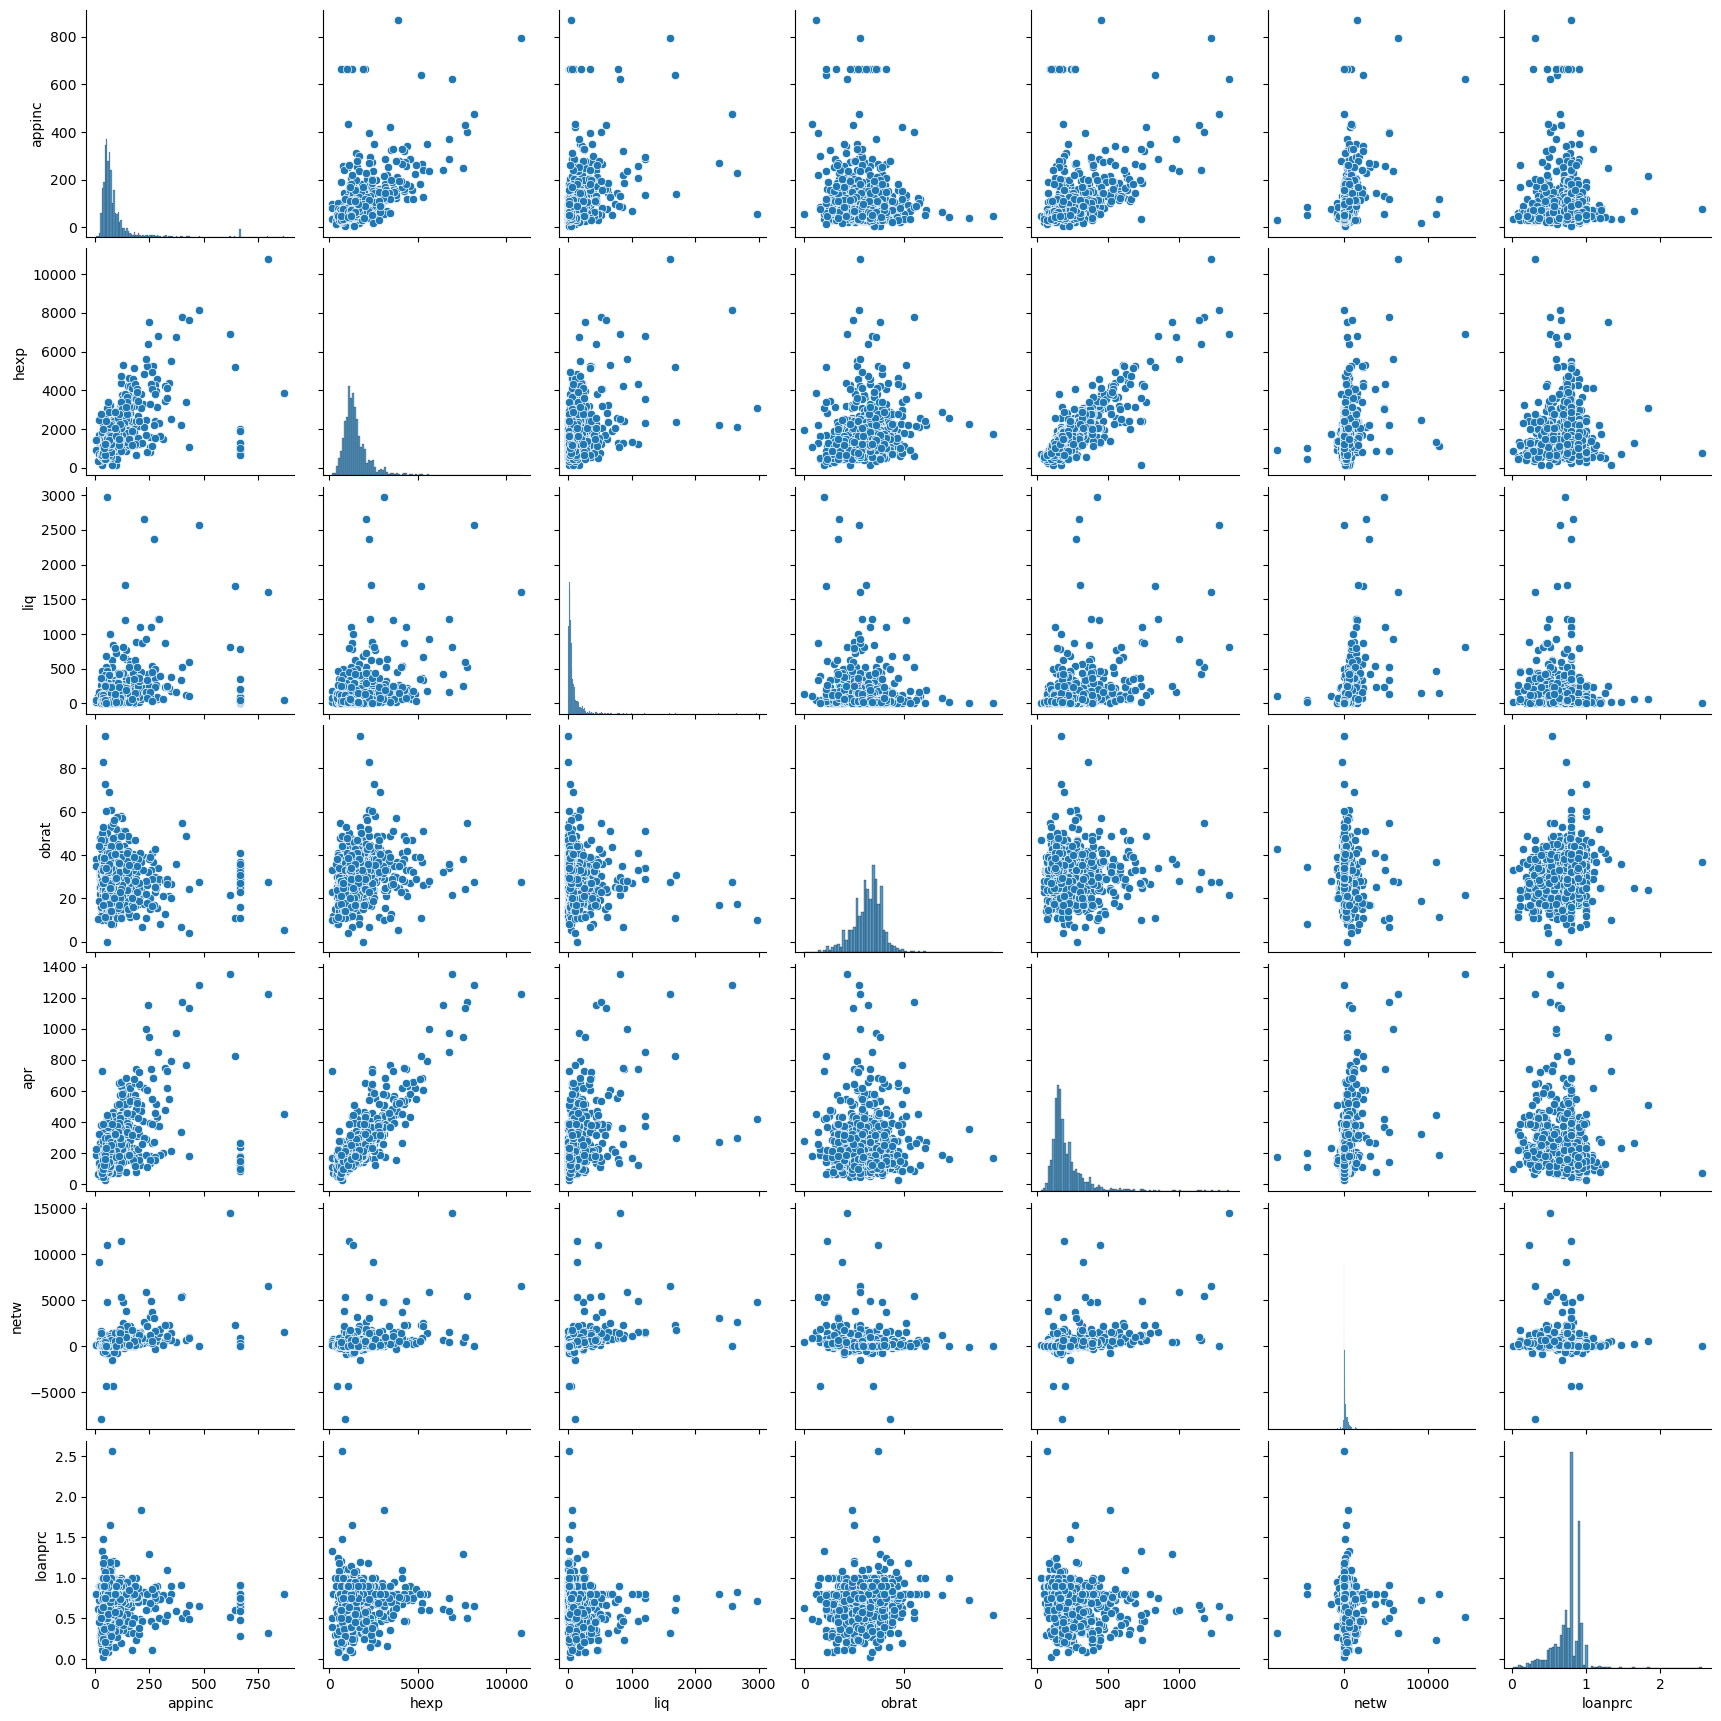

In [31]:
# Pairplot for quantitative variables
sns.pairplot(loanapp_selected[quantitative_vars])
plt.show()

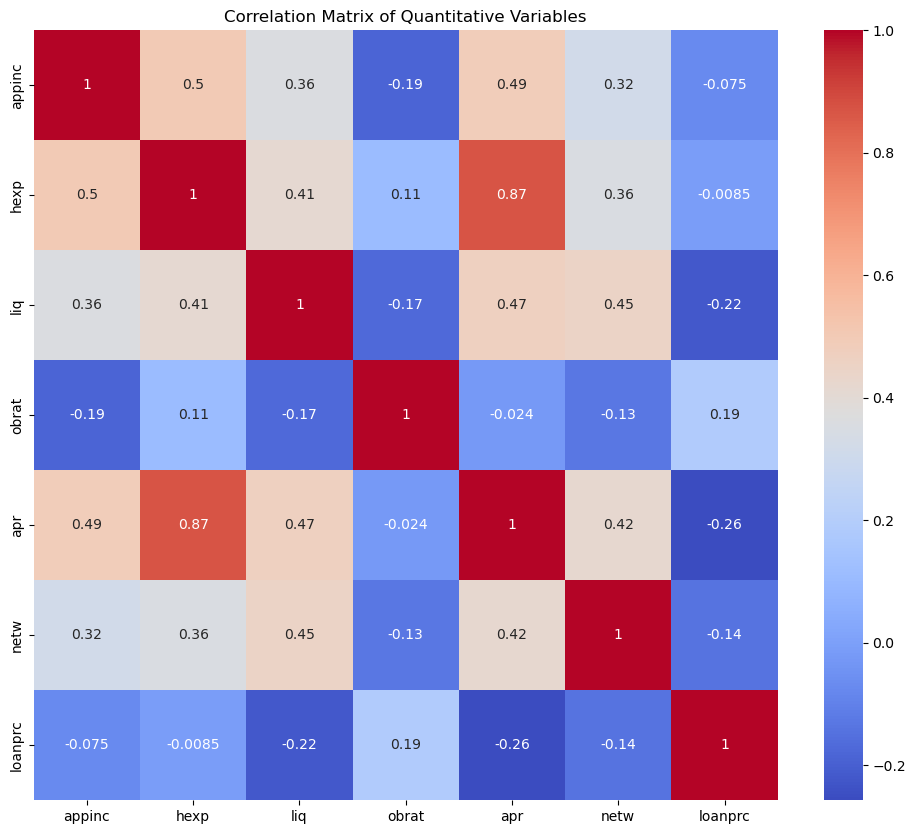

In [32]:
# Correlation matrix
corr_matrix = loanapp_selected[quantitative_vars].corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Quantitative Variables')
plt.show()

The correlation coefficient of `hexp` and `apr` is greater than 0.8, which is considered very high. We will remove `hexp` (proposed housing expense) and keep `apr` (appraised value) because `apr` directly reflects the property's market value, which is a fundamental factor in determining the loan-to-price ratio (`loanprc`). In contrast, `hexp` is an applicant-specific expense that may not universally align with the property's value or loan terms. Prioritizing `apr` aligns better with the project's goal of analyzing factors directly tied to the loan and property relationship.

In [33]:
# Drop hexp based on correlation coefficient
loanapp_selected = loanapp_selected.drop('hexp', axis = 1)
quantitative_vars.remove('hexp')
selected_qpred.remove('hexp')
final_predictors.remove('hexp')

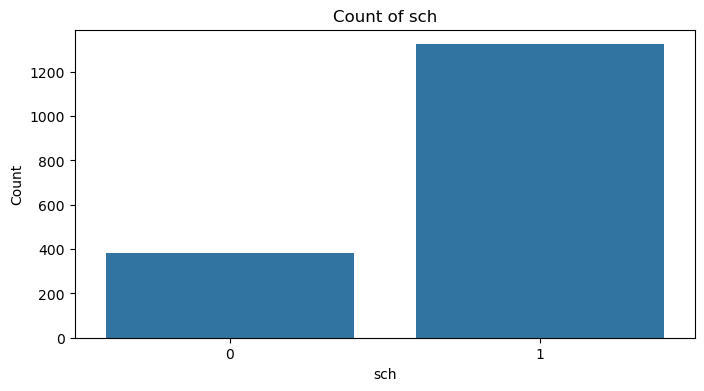

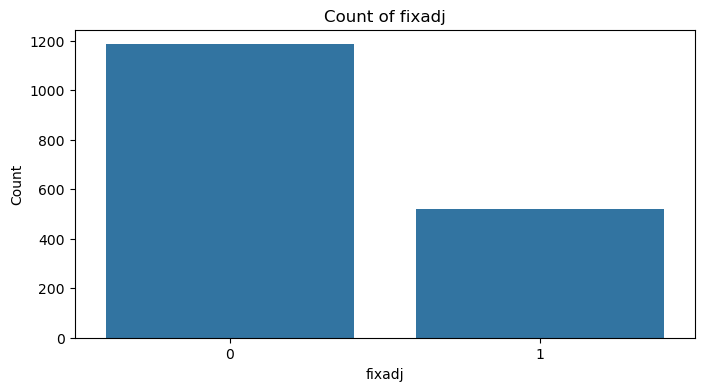

In [35]:
# Bar plots for categorical variables
for col in selected_fpred:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=loanapp_selected[col])
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

We will focus on `term`'s distribution because we have already reviewed the distribution of the other factor variables with the frequency count.

- `term`'s distribution is highly imbalanced, with the majority of loans having a term of 360 months (30 years)
- A smaller number of loans have other terms such as 180 months (15 years) and 480 months (40 years), but these are much less frequent.
- Loan terms such as 8 months, 12 months, 36 months, and other shorter durations are present in very small numbers.

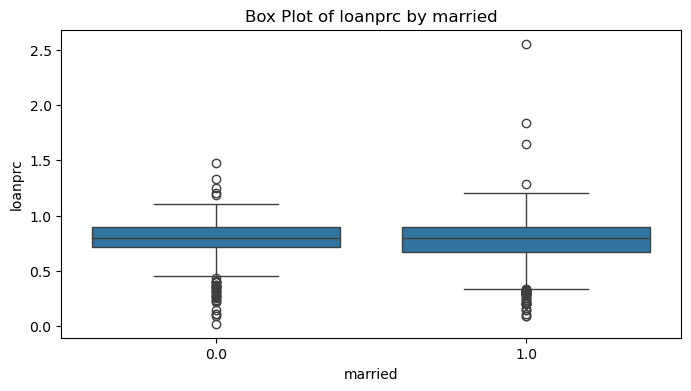

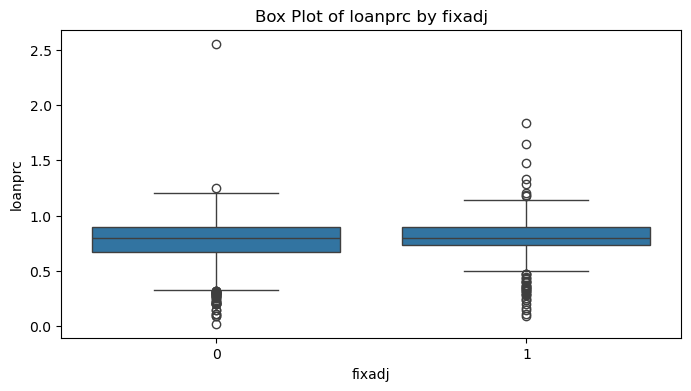

In [36]:
# Boxplots of loanprc by categorical variables
for col in selected_fpred:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=loanapp_selected[col], y=loanapp_selected[dependent_variable])
    plt.title(f'Box Plot of {dependent_variable} by {col}')
    plt.xlabel(col)
    plt.ylabel(dependent_variable)
    plt.show()

- `male`: Gender does not play a significant role in the distribution of `loanprc`. The similarity across genders suggests equity in loan-to-price ratios.
- `married`: Unmarried applicants have more extreme outliers on the lower end.
- `sch`: Higher education does not significantly influence the `loanprc`, but it might correlate with more consistent lending terms, as reflected in the tighter distribution.
- `fixadj`: Loan type might influence the `loanprc`, with fixed-rate loans generally associated with more stable or predictable terms. Adjustable-rate loans might cater to riskier profiles, leading to more variability.
- `term`: The 360-month term has a much wider range of `loanprc`, with many outliers on both ends, reflecting its dominance in the dataset. Median `loanprc` values appear slightly lower for mid-range terms (e.g., 180, 240 months).

### (b) Estimate density plots for all your variables, and show the respective fitted distributions.

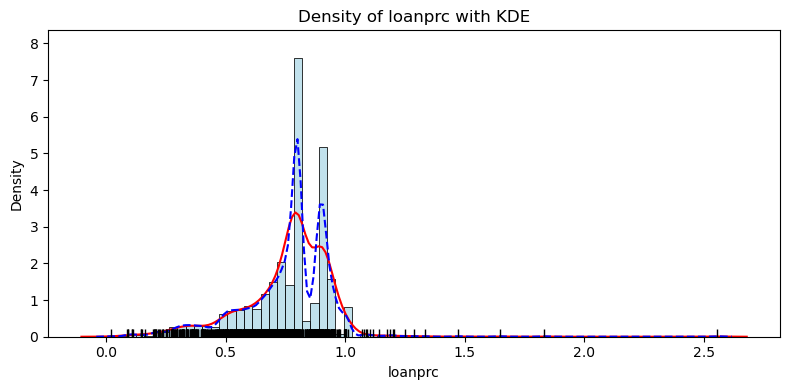

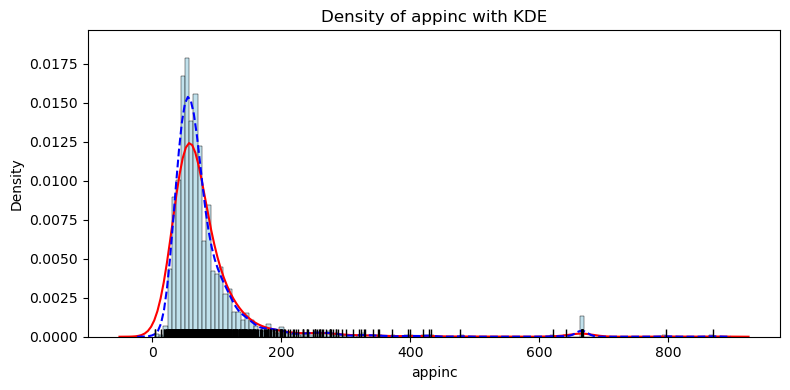

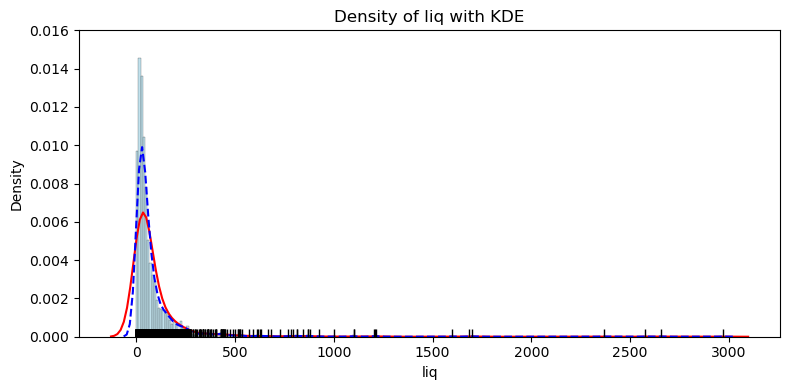

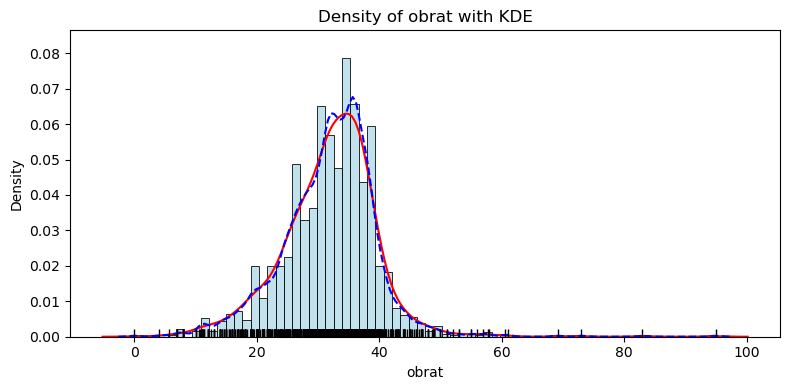

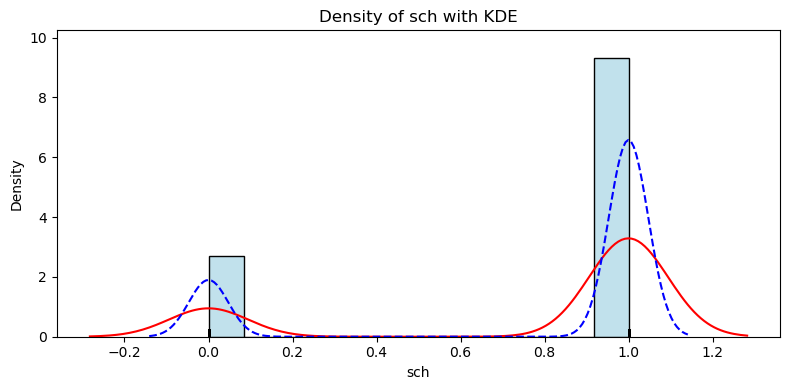

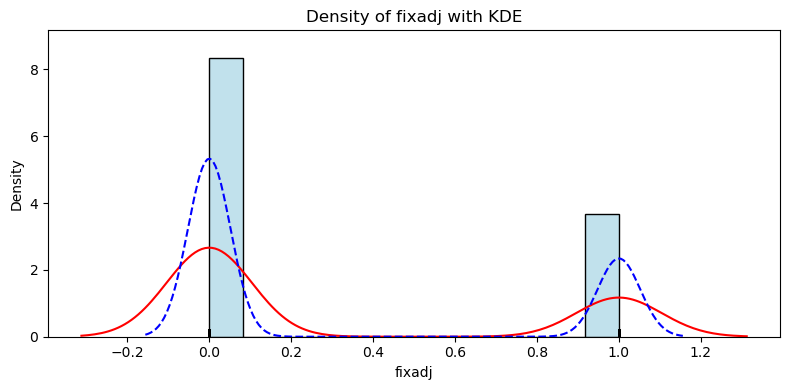

In [37]:
# Plot density and fitted distributions for all variables
for col in loanapp_selected.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(loanapp_selected[col], kde=False, stat='density', color='lightblue')
    sns.kdeplot(loanapp_selected[col], color='red')
    sns.kdeplot(loanapp_selected[col], bw_adjust=0.5, color='blue', linestyle='--')  # less smooth
    sns.rugplot(loanapp_selected[col], color='black')
    plt.title(f'Density of {col} with KDE')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

`loanprc`:  
   - KDE reveals bimodality with peaks around 0.8 and 1.0.  
   - The red curve captures the two modes clearly, while the dashed blue line highlights finer variability.  

`appinc`:  
   - KDE shows a right-skewed distribution, concentrated at lower income levels.  
   - The dashed blue curve captures the presence of outliers in the upper range.  

`liq`:  
   - KDE reflects a sharp peak near zero with a steep drop-off.  
   - Outliers in liquidity are apparent through the extended right tail.  

`obrat`:  
   - KDE suggests an approximately normal distribution, centered around 40.  
   - Smoothness in the red KDE highlights symmetry and minimal skewness.  

`term`:  
   - KDE highlights multiple peaks, reflecting its categorical nature (e.g., 360, 240).  
   - The dashed blue line emphasizes the distinct modes further.  

`apr`:  
   - KDE indicates right skewness, with a steep decline after the peak.  
   - The dashed blue line captures variability in higher values.  

`netw`:  
   - KDE shows a symmetric distribution with sharp peaks around zero.  
   - Tails on both sides capture extreme outliers.  

### (c) Identify if there are any non-linearities within your variables. What transformations should you perform to make them linear? What would happen if you included non-linear variables in your regression models without transforming them first?

#### Join plot of quantitative variables against dependent variable `loanprc`

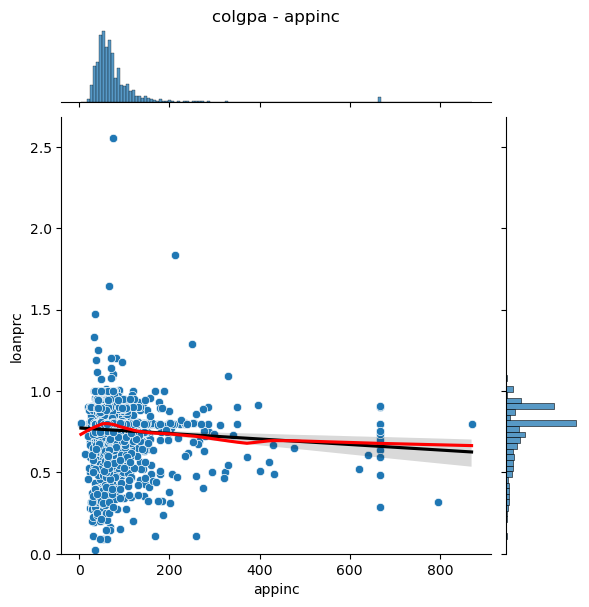

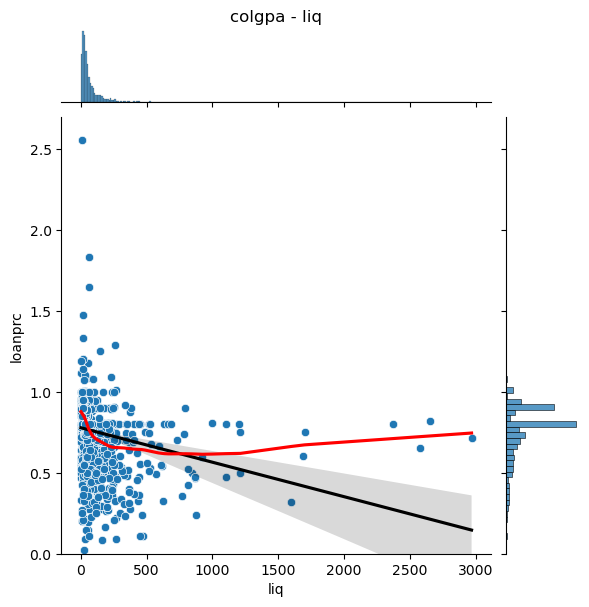

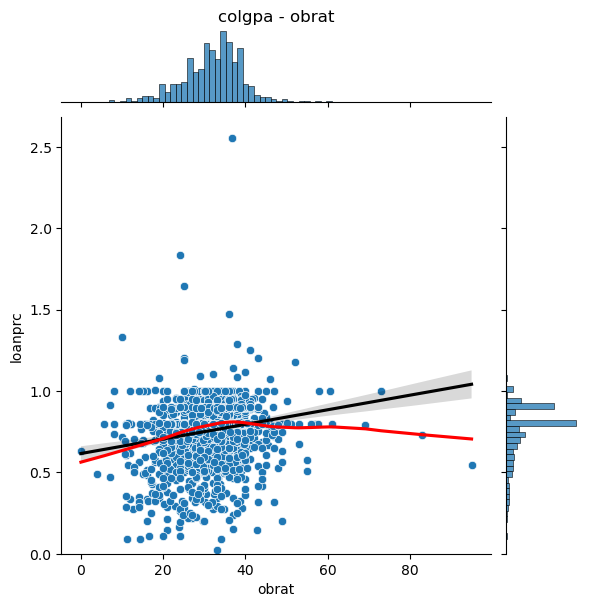

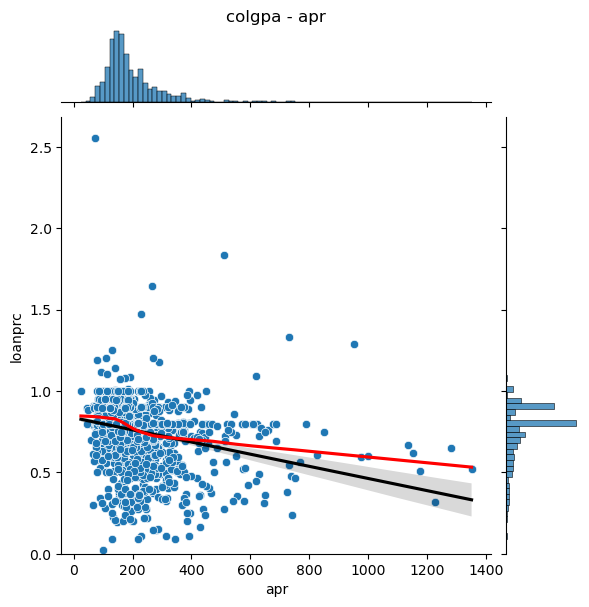

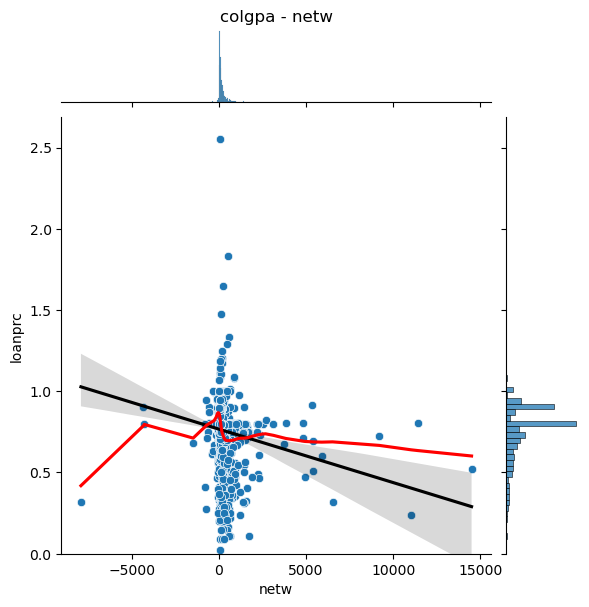

In [38]:
for col in selected_qpred:
    t = sns.jointplot(data=loanapp_selected, x=col, y='loanprc')
    t.plot_joint(sns.scatterplot)
    t.plot_joint(sns.regplot, fit_reg=True, scatter=False, color='black')
    t.plot_joint(sns.regplot, lowess=True, scatter=False, color='red')
    plt.ylim((0, None))
    plt.title(f'colgpa - {col}', y=1.2)
    plt.show()

`appinc` (Applicant Income)
- A weak linear relationship exists, with most data clustered at lower income values; variability increases with higher income.
- The LOWESS line suggests a slight decline in `loanprc` at higher incomes, indicating non-linearity; consider a log or Box-Cox transformation.

`liq` (Liquid Assets)
- Data clusters at lower liquid asset values, with a negative trend in `loanprc` for higher `liq`.
- LOWESS line reveals non-linear behavior, with decreasing `loanprc` flattening at high `liq`; log transformation is recommended.

`obrat` (Obligation Ratio)
- A weak positive linear relationship is observed, with data spread evenly.
- The LOWESS line closely aligns with the linear fit but shows mild non-linearity at higher values; a Box-Cox transformation could help.

`apr` (Appraised Value)
- Clear negative relationship with `loanprc`, with data clustered at lower `apr` values.
- LOWESS line shows sharper declines at low `apr` values and leveling off at higher values; consider log or reciprocal transformation.

`netw` (Net Worth)
- High variability in the data, with no clear linear trend visible.
- The LOWESS line shows a non-linear relationship with fluctuations at higher net worth values; log transformation is suggested.

#### Box-Cox and Yeo-Johnson Transformation - Statistics and Histogram

In [39]:
def boxcox_yj(data, var):
    column = data[var].dropna()  # Ensure no NaN values

    # Choose the transformation method based on whether the data is strictly positive
    if (column > 0).all():
        transformation = "Box-Cox"
        transform_func = stats.boxcox
        log_likelihood_func = stats.boxcox_llf
    else:
        transformation = "Yeo-Johnson"
        transform_func = stats.yeojohnson
        log_likelihood_func = stats.yeojohnson_llf

    # Perform the transformation and calculate the optimal lambda
    transformed_data, var_lambda = transform_func(column)
    
    # Compute the log-likelihood for the optimal lambda
    optimal_log_likelihood = log_likelihood_func(lmb=var_lambda, data=column)

    # Profile likelihood method to compute confidence intervals
    test_lambdas = np.linspace(var_lambda - 2, var_lambda + 2, 100)
    log_likelihoods = [log_likelihood_func(lmb=lmb, data=column) for lmb in test_lambdas]
    cutoff = optimal_log_likelihood - 0.5 * stats.chi2.ppf(0.95, df=1)
    
    # Determine confidence interval
    ci = test_lambdas[np.array(log_likelihoods) >= cutoff]
    if len(ci) == 0:
        # Fallback: Expand range if no confidence interval is found
        test_lambdas = np.linspace(var_lambda - 5, var_lambda + 5, 200)
        log_likelihoods = [log_likelihood_func(lmb=lmb, data=column) for lmb in test_lambdas]
        ci = test_lambdas[np.array(log_likelihoods) >= cutoff]
        if len(ci) == 0:
            ci = [float("nan"), float("nan")]

    # Test statistics for specific lambdas
    specific_lambdas = [-1, -0.5, 0, 0.5, 1]
    test_stats = [2 * (optimal_log_likelihood - log_likelihood_func(lmb=lmb, data=column)) for lmb in specific_lambdas]
    p_values = [1 - stats.chi2.cdf(stat, df=1) for stat in test_stats]

    # Print results
    print(f"Variable: {var}")
    print(f"Transformation: {transformation}")
    print(f"Estimated Lambda = {var_lambda:.4f}")
    print(f"Rounded Lambda = {np.round(var_lambda, 1)}")
    print(f"Confidence Interval = [{ci[0]:.4f}, {ci[-1]:.4f}]\n")
    print("Lambda\tTest Stat\tp-value")
    for lmb, stat, p in zip(specific_lambdas, test_stats, p_values):
        print(f"{lmb:.1f}\t{stat:.6f}\t{p:.4f}")

    # Return results for further use
    return {
        "variable": var,
        "transformation": transformation,
        "lambda": var_lambda,
        "confidence_interval": [ci[0], ci[-1]],
        "test_lambdas": specific_lambdas,
        "test_statistics": test_stats,
        "p_values": p_values
    }

In [40]:
for col in selected_qpred:
    boxcox_yj(loanapp_selected, col)

Variable: appinc
Transformation: Box-Cox
Estimated Lambda = -0.3066
Rounded Lambda = -0.3
Confidence Interval = [-0.3268, -0.2864]

Lambda	Test Stat	p-value
-1.0	1078.135532	0.0000
-0.5	68.614819	0.0000
0.0	153.902164	0.0000
0.5	1040.499698	0.0000
1.0	2728.964918	0.0000
Variable: liq
Transformation: Yeo-Johnson
Estimated Lambda = -0.0244
Rounded Lambda = -0.0
Confidence Interval = [-0.0446, -0.0042]

Lambda	Test Stat	p-value
-1.0	3926.884626	0.0000
-0.5	971.486348	0.0000
0.0	2.550486	0.1103
0.5	1190.323360	0.0000
1.0	4517.631890	0.0000
Variable: obrat
Transformation: Yeo-Johnson
Estimated Lambda = 0.9893
Rounded Lambda = 1.0
Confidence Interval = [0.8883, 1.0903]

Lambda	Test Stat	p-value
-1.0	4239.500479	0.0000
-0.5	1503.476352	0.0000
0.0	455.216441	0.0000
0.5	93.544402	0.0000
1.0	0.041736	0.8381
Variable: apr
Transformation: Box-Cox
Estimated Lambda = -0.3494
Rounded Lambda = -0.3
Confidence Interval = [-0.4100, -0.2888]

Lambda	Test Stat	p-value
-1.0	334.350514	0.0000
-0.5	17.338317

Taking account of the test statistic and p-values of the rounded and alternative lambdas, we will then visualize the distribution of the transformed quantitative variables based on their rounded and nearby lambdas.

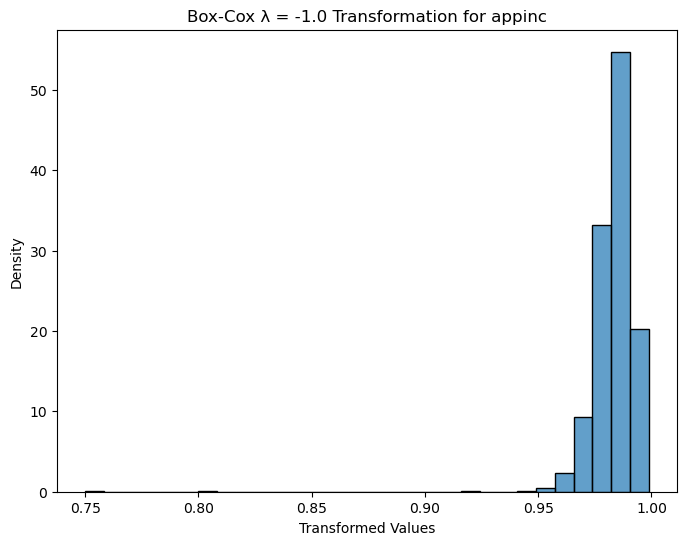

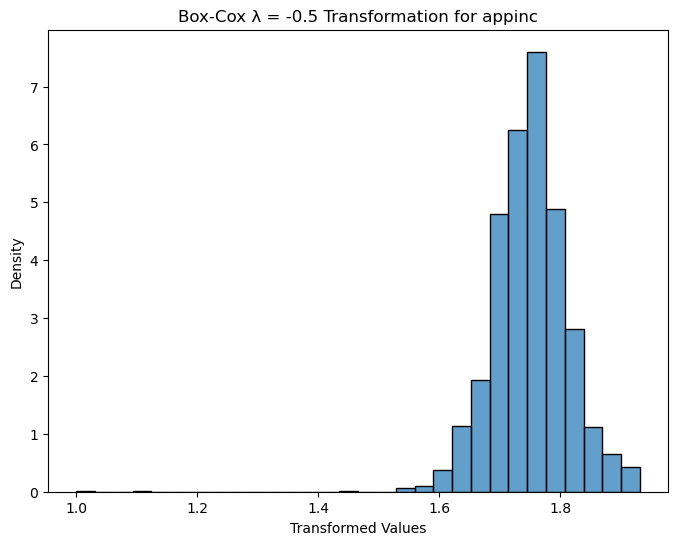

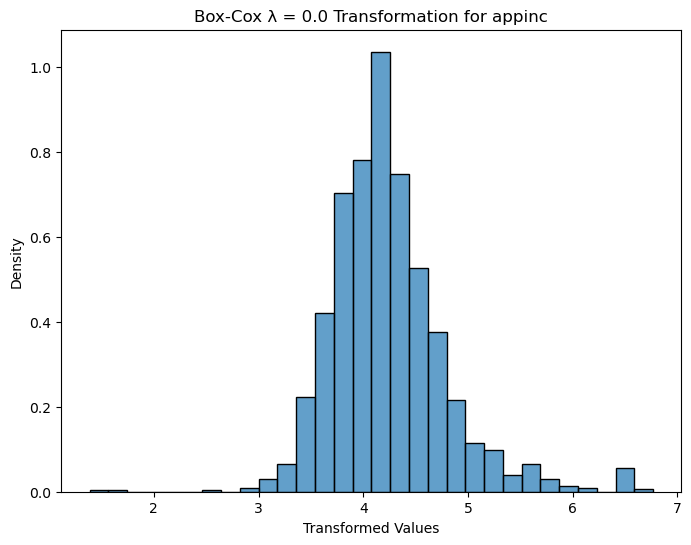

Lambda for appinc (Box-Cox):
  Actual: -0.3066437627522088
  Rounded: -0.5
  Lambdas Tested: [-1.0, -0.5, 0.0]


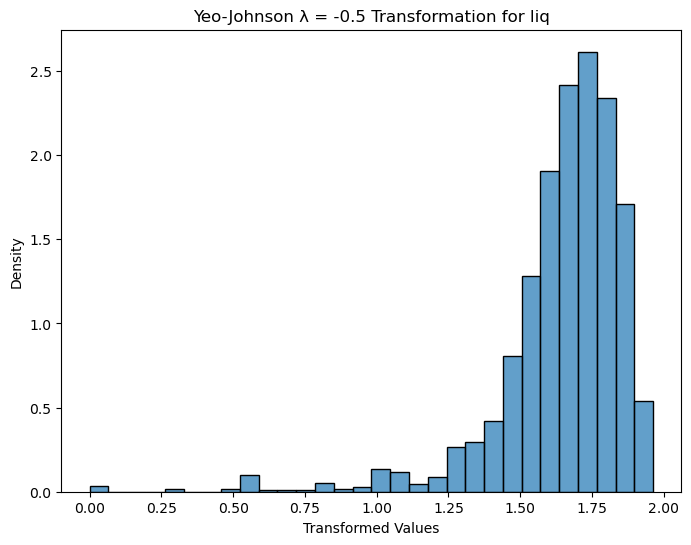

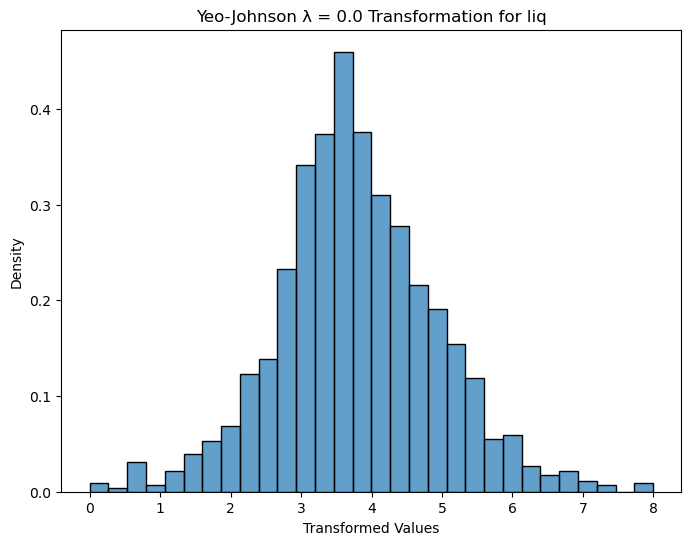

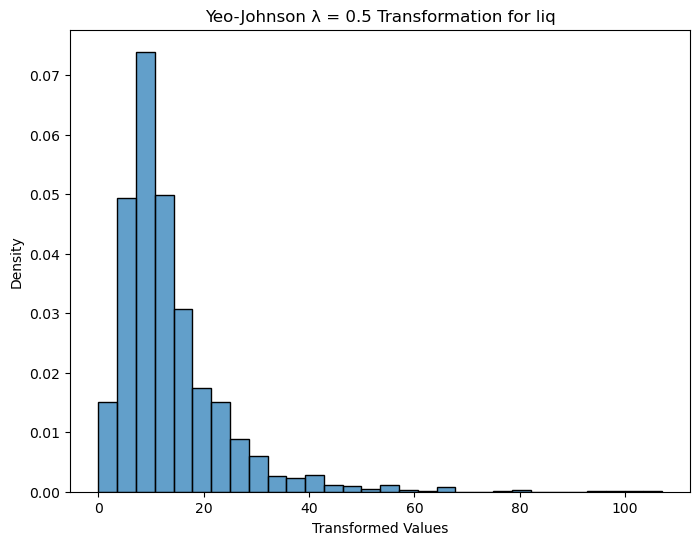

Lambda for liq (Yeo-Johnson):
  Actual: -0.02437213973576298
  Rounded: 0.0
  Lambdas Tested: [-0.5, 0.0, 0.5]


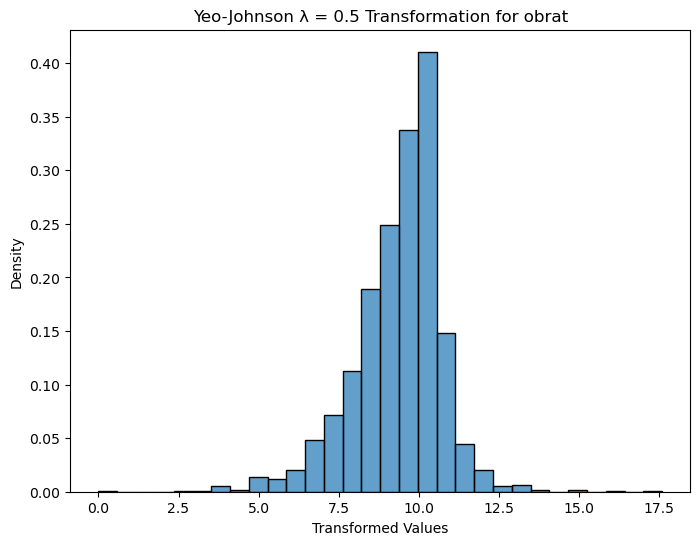

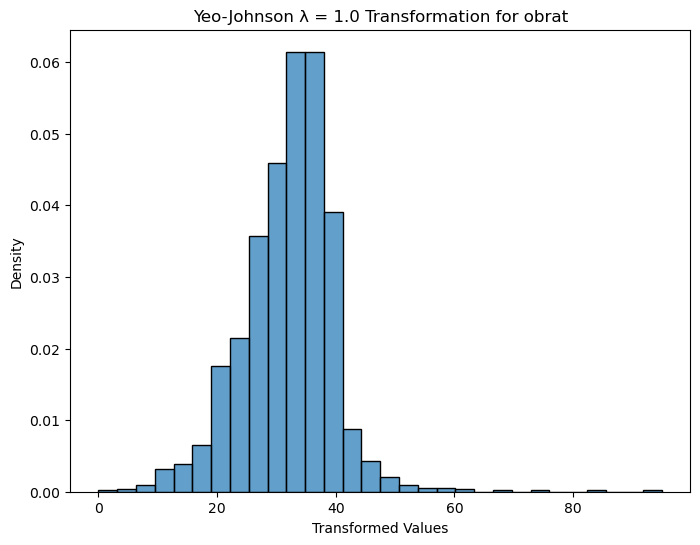

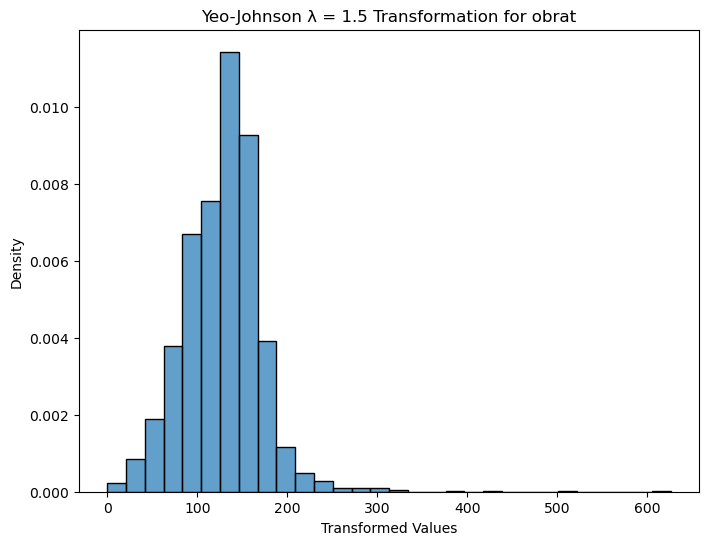

Lambda for obrat (Yeo-Johnson):
  Actual: 0.9893156407835146
  Rounded: 1.0
  Lambdas Tested: [0.5, 1.0, 1.5]


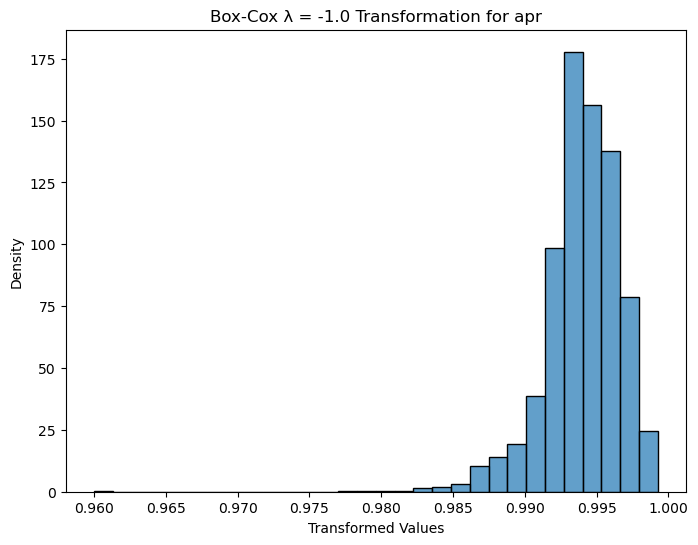

Lambda for apr (Box-Cox):
  Actual: -0.3494357650798722
  Rounded: -0.5
  Lambdas Tested: [-1.0, -0.5, 0.0]


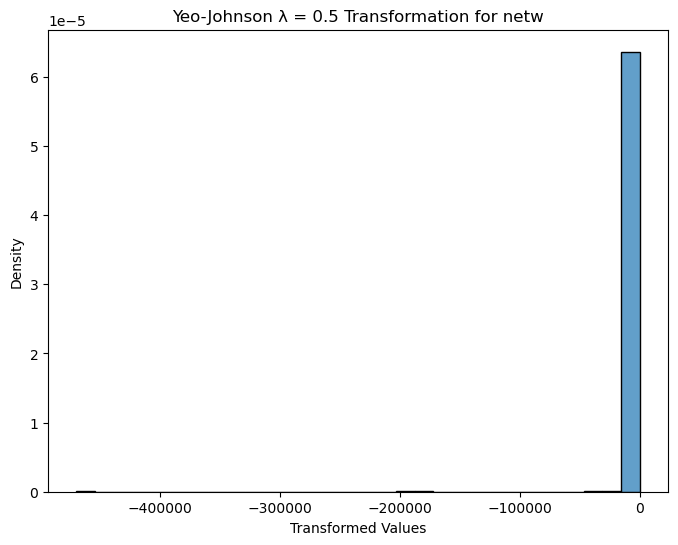

Lambda for netw (Yeo-Johnson):
  Actual: 0.9711130462575387
  Rounded: 1.0
  Lambdas Tested: [0.5, 1.0, 1.5]


In [41]:
for col in selected_qpred:
    # Determine whether to use Box-Cox or Yeo-Johnson
    if (loanapp_selected[col] > 0).all():
        # Apply Box-Cox for positive values
        transformation = "Box-Cox"
        transformation_func = scipy.stats.boxcox
    else:
        # Apply Yeo-Johnson for non-positive values
        transformation = "Yeo-Johnson"
        transformation_func = scipy.stats.yeojohnson

    # Get actual lambda
    _, lambda_col = transformation_func(loanapp_selected[col])
    lambda_rounded = round(lambda_col * 2) / 2  # Round to the nearest 0.5

    # Generate nearby lambda values to test
    lambdas_to_test = [lambda_rounded - 0.5, lambda_rounded, lambda_rounded + 0.5]
    labels = [f"{transformation} λ = {lmbda}" for lmbda in lambdas_to_test]

    # Create separate histograms for each lambda
    for lmbda, label in zip(lambdas_to_test, labels):
        transformed_col = transformation_func(loanapp_selected[col], lmbda=lmbda)
        plt.figure(figsize=(8, 6))
        sns.histplot(transformed_col, kde=False, stat="density", bins=30, alpha=0.7)
        plt.title(f"{label} Transformation for {col}")
        plt.xlabel("Transformed Values")
        plt.ylabel("Density")
        plt.show()

    # Print lambda values
    print(f"Lambda for {col} ({transformation}):")
    print(f"  Actual: {lambda_col}")
    print(f"  Rounded: {lambda_rounded}")
    print(f"  Lambdas Tested: {lambdas_to_test}")

Based on the histograms' distributions, we will use the following transformations and lambdas:
- appinc: Box-Cox, $\lambda = 0$, so apply log.
- liq: Yeo-Johnson, $\lambda = 0$, so apply log for positive values and negative log to negative values.
- obrat: Yeo-Johnson, $\lambda = 1$, so no transformation.
- apr: Box-Cox, $\lambda = 0$, so apply log.
- netw: Yeo-Johnson, $\lambda = 1$, so no transformation.

In [42]:
from scipy.stats import boxcox, boxcox_llf, yeojohnson, yeojohnson_llf
loanapp2 = loanapp_selected.copy()
loanapp2['appinc_log'] = np.log(loanapp2['appinc'])
loanapp2['liq_yj0'] = yeojohnson(loanapp2['liq'], lmbda=0)
loanapp2['apr_log'] = np.log(loanapp2['apr'])

In [43]:
loanapp2.head()

loanprc  appinc    liq      obrat   term    apr   netw  male  married  \
2  0.895105      84   37.0  26.000000  180.0  145.0   40.0   1.0      0.0   
3  0.600000      36   19.0  37.000000  360.0  110.0  158.0   1.0      1.0   
4  0.895522      59   31.0  32.099998  360.0  135.0   69.0   1.0      1.0   
5  0.804348      63  169.0  33.000000  360.0  144.0  262.0   1.0      0.0   
6  0.898089      72   38.0  36.000000  360.0  162.0   46.0   1.0      0.0   

   sch  fixadj  appinc_log   liq_yj0   apr_log  
2    1       0    4.430817  3.637586  4.976734  
3    1       0    3.583519  2.995732  4.700480  
4    0       0    4.077537  3.465736  4.905275  
5    0       0    4.143135  5.135798  4.969813  
6    1       0    4.276666  3.663562  5.087596

In [44]:
def plotter(var, data):
    # Histogram and KDE
    plt.figure(figsize=(8, 4))
    sns.histplot(data[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()
    
    # Q-Q Plot
    plt.figure(figsize=(6, 6))
    stats.probplot(data[var], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {var}')
    plt.show()

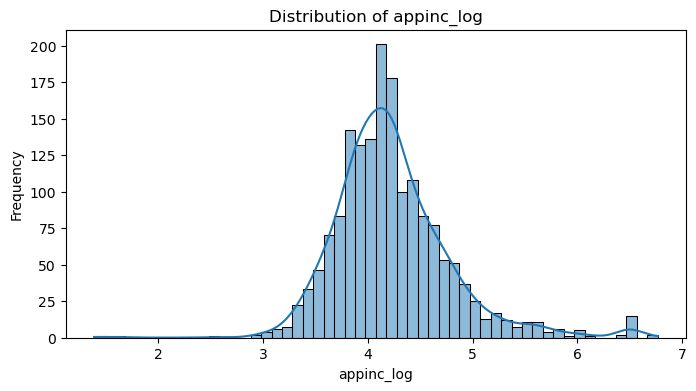

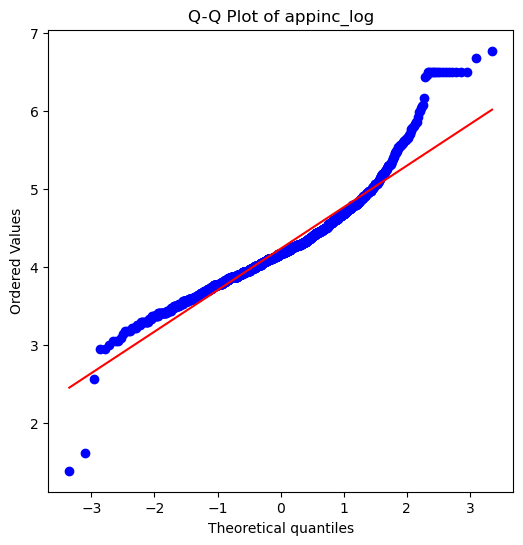

In [45]:
plotter('appinc_log', loanapp2)

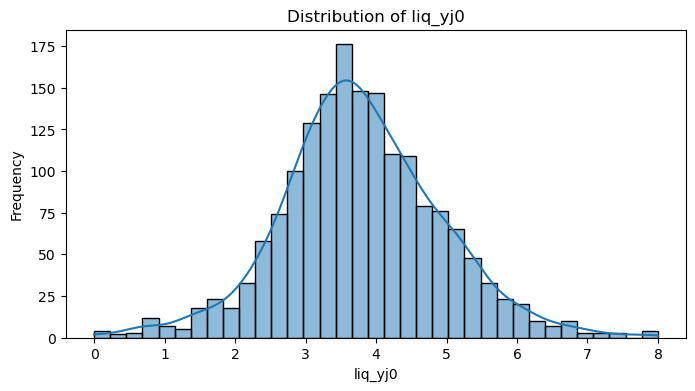

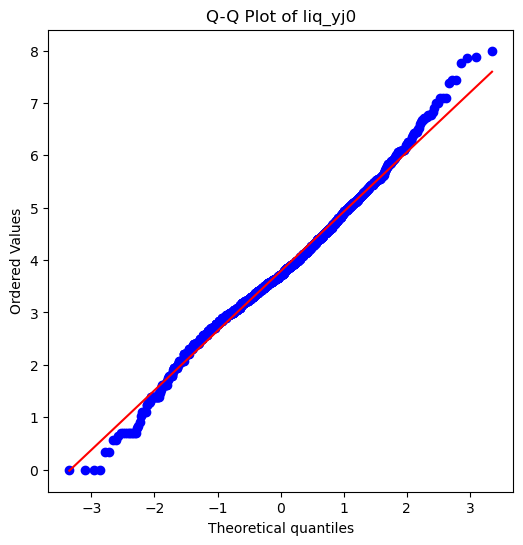

In [46]:
plotter('liq_yj0', loanapp2)

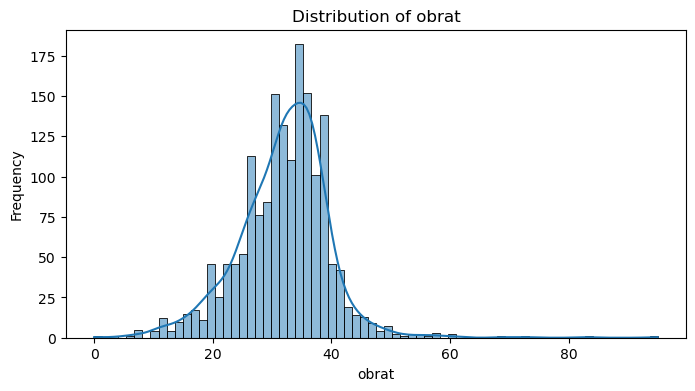

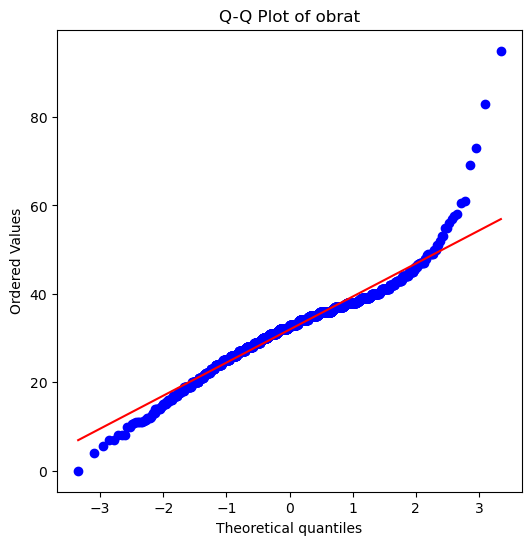

In [47]:
plotter('obrat', loanapp2)

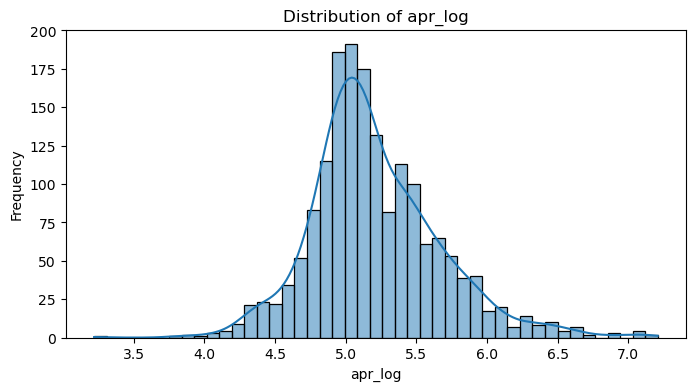

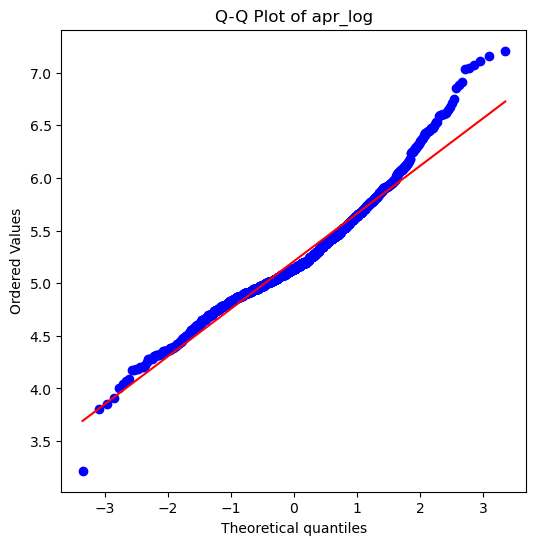

In [48]:
plotter('apr_log', loanapp2)

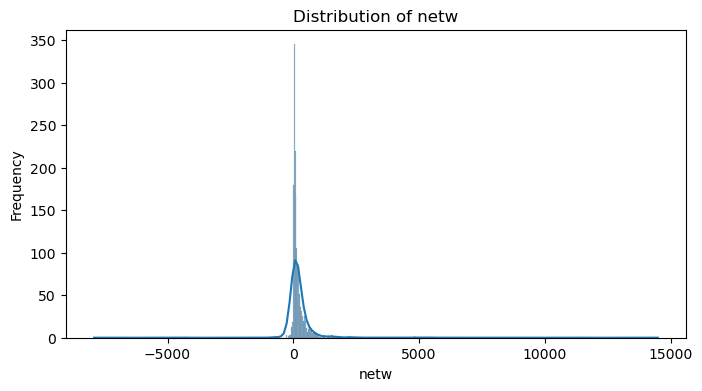

In [49]:
plotter('netw', loanapp2)

Despite our Yeo-Johnson statistic checks and histogram examination, our distribution for `netw` looks highly non-normal with significant outliers dominating the tails. To resolve this, we will try the log transformation while taking into account of negative values in the variable.

In [50]:
def logger(var, data):
    adjusted_var = data[var].clip(lower=0) + 1  # Clip to handle negative values, then add 1
    log = np.log(adjusted_var)
    data['log_' + var] = log
    return data

In [51]:
logger('netw', loanapp2)

loanprc  appinc         liq      obrat   term    apr         netw  \
2     0.895105      84   37.000000  26.000000  180.0  145.0    40.000000   
3     0.600000      36   19.000000  37.000000  360.0  110.0   158.000000   
4     0.895522      59   31.000000  32.099998  360.0  135.0    69.000000   
5     0.804348      63  169.000000  33.000000  360.0  144.0   262.000000   
6     0.898089      72   38.000000  36.000000  360.0  162.0    46.000000   
...        ...     ...         ...        ...    ...    ...          ...   
1983  0.750000      46   47.000000  28.799999  360.0  162.0    89.000000   
1984  0.897727      96   15.000000  29.299999  360.0  176.0    19.000000   
1985  0.111111     169   64.000000  20.000000  120.0  315.0  1745.000000   
1986  1.000000      49   10.000000  60.500000  300.0  230.0     7.000000   
1987  0.455814     110  427.899994  17.000000  180.0  180.0   641.900024   

      male  married  sch  fixadj  appinc_log   liq_yj0   apr_log  log_netw  
2      1.0      0.0    1       0    4.430817  3.637586  4.976734  3.713572  
3      1.0      1.0    1       0    3.583519  2.995732  4.700480  5.068904  
4      1.0      1.0    0       0    4.077537  3.465736  4.905275  4.248495  
5      1.0      0.0    0       0    4.143135  5.135798  4.969813  5.572154  
6      1.0      0.0    1       0    4.276666  3.663562  5.087596  3.850148  
...    ...      ...  ...     ...         ...       ...       ...       ...  
1983   1.0      0.0    1       0    3.828641  3.871201  5.087596  4.499810  
1984   1.0      1.0    1       1    4.564348  2.772589  5.170484  2.995732  
1985   1.0      1.0    1       0    5.129899  4.174387  5.752573  7.465083  
1986   1.0      1.0    0       1    3.891820  2.397895  5.438079  2.079442  
1987   1.0      0.0    1       0    4.700480  6.061224  5.192957  6.465989  

[1706 rows x 15 columns]

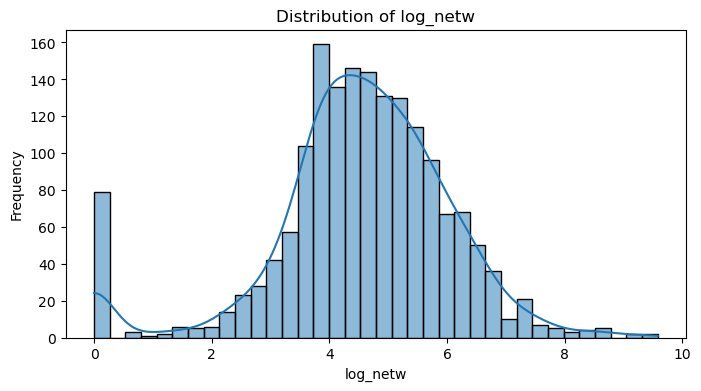

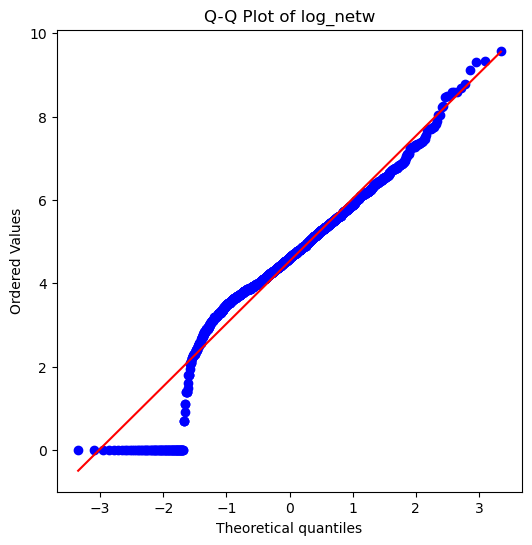

In [52]:
plotter('log_netw', loanapp2)

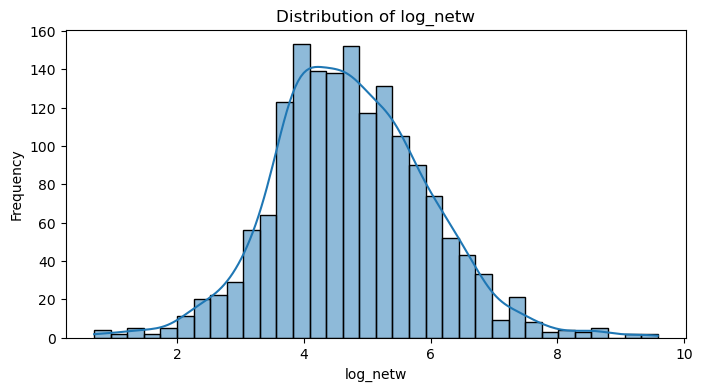

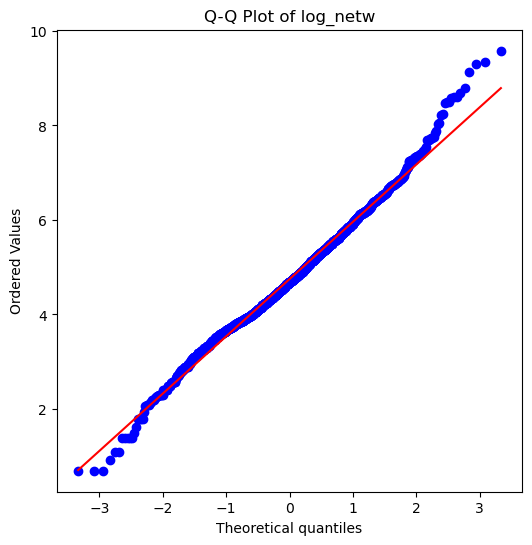

In [53]:
plotter('log_netw', loanapp2[loanapp2['log_netw']>0])

After removing the negative `netw` values, the distribution of the variable has significantly improved, demonstrating better alignment with normality assumptions. We believe that excluding non-positive net worth values aligns with our research objectives and does not compromise the broader analysis. Therefore, our model will focus on making inferences based on a sample (and consequently a population) with only positive net worth values.

In [54]:
loanapp2 = loanapp2[loanapp2['log_netw']>0]
loanapp2.head()

loanprc  appinc    liq      obrat   term    apr   netw  male  married  \
2  0.895105      84   37.0  26.000000  180.0  145.0   40.0   1.0      0.0   
3  0.600000      36   19.0  37.000000  360.0  110.0  158.0   1.0      1.0   
4  0.895522      59   31.0  32.099998  360.0  135.0   69.0   1.0      1.0   
5  0.804348      63  169.0  33.000000  360.0  144.0  262.0   1.0      0.0   
6  0.898089      72   38.0  36.000000  360.0  162.0   46.0   1.0      0.0   

   sch  fixadj  appinc_log   liq_yj0   apr_log  log_netw  
2    1       0    4.430817  3.637586  4.976734  3.713572  
3    1       0    3.583519  2.995732  4.700480  5.068904  
4    0       0    4.077537  3.465736  4.905275  4.248495  
5    0       0    4.143135  5.135798  4.969813  5.572154  
6    1       0    4.276666  3.663562  5.087596  3.850148

In [55]:
selected_qpred2 = ['appinc_log', 'liq_yj0', 'obrat', 'apr_log', 'log_netw']

In [56]:
final_predictors2 = selected_qpred2 + selected_fpred

#### Extra: Checking distribution of dependent variable `loanprc`

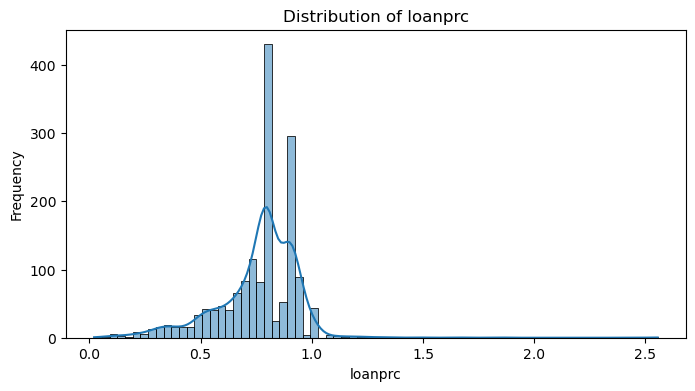

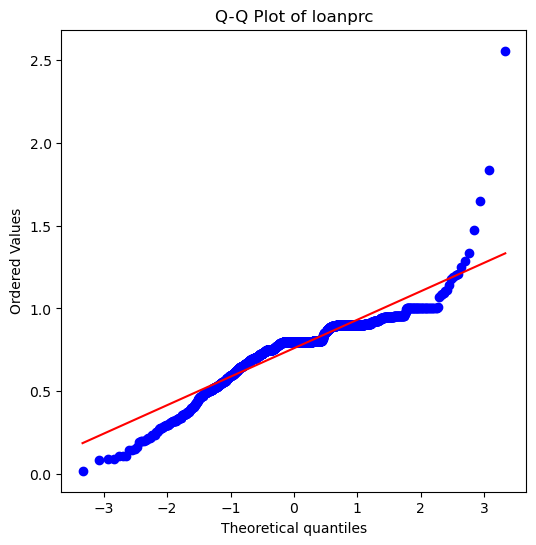

In [57]:
plotter('loanprc', loanapp2)

In [61]:
loanapp2['loanprc_sq'] = loanapp2['loanprc']**2
loanapp2.head()

loanprc  appinc    liq      obrat   term    apr   netw  male  married  \
2  0.895105      84   37.0  26.000000  180.0  145.0   40.0   1.0      0.0   
3  0.600000      36   19.0  37.000000  360.0  110.0  158.0   1.0      1.0   
4  0.895522      59   31.0  32.099998  360.0  135.0   69.0   1.0      1.0   
5  0.804348      63  169.0  33.000000  360.0  144.0  262.0   1.0      0.0   
6  0.898089      72   38.0  36.000000  360.0  162.0   46.0   1.0      0.0   

   sch  fixadj  appinc_log   liq_yj0   apr_log  log_netw  loanprc_sq  
2    1       0    4.430817  3.637586  4.976734  3.713572    0.801213  
3    1       0    3.583519  2.995732  4.700480  5.068904    0.360000  
4    0       0    4.077537  3.465736  4.905275  4.248495    0.801960  
5    0       0    4.143135  5.135798  4.969813  5.572154    0.646975  
6    1       0    4.276666  3.663562  5.087596  3.850148    0.806564

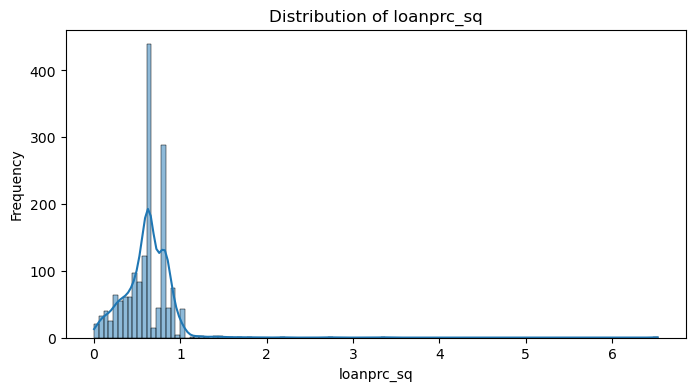

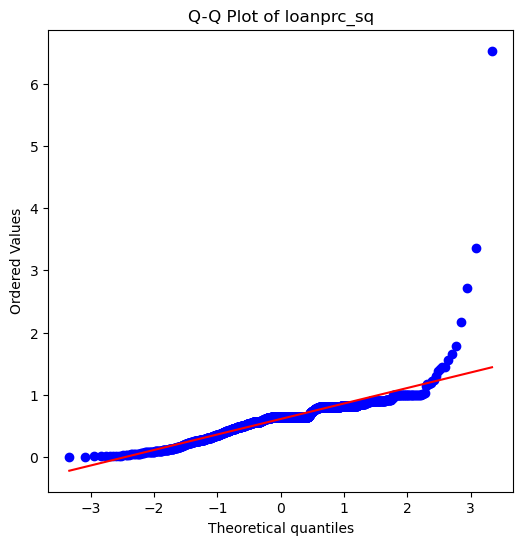

In [62]:
plotter('loanprc_sq', loanapp2)

After examining the histogram and Q-Q plot of `loanprc`, we decided to address its skewness and improve the normality of its distribution by applying a square transformation. Squaring preserves the monotonic relationship between the dependent and independent variables, ensuring that variability and trends remain intact. However, it is important to be cautious when interpreting the results of the downstream analysis, as the dependent variable has been transformed.

In [74]:
dependent_variable = 'loanprc_sq'

print(f'Final predictors (transformed quantitative and factor): \n', final_predictors2, f'\n')
print(f'Log transformed dependent variables:', dependent_variable)

Final predictors (transformed quantitative and factor): 
 ['appinc_log', 'liq_yj0', 'obrat', 'apr_log', 'log_netw', 'male', 'married', 'sch', 'fixadj', 'term'] 

Log transformed dependent variables: loanprc_sq


### (d) Comment on any outliers and/or unusual features of your variables, and then justify their removal, exclusion, or imputation.

#### Box Plots for simple diagnostic - IQR Outliers

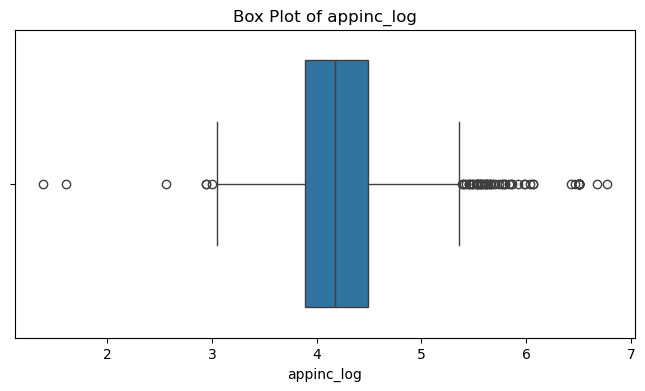

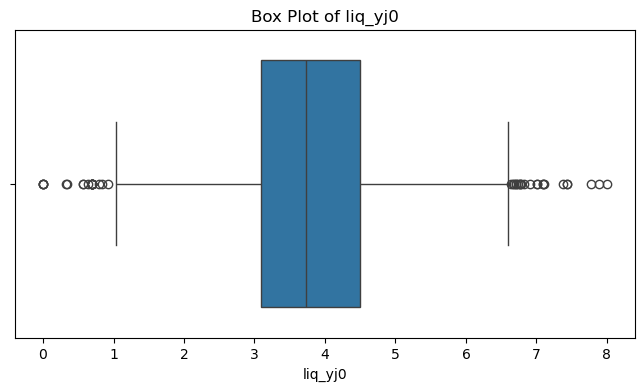

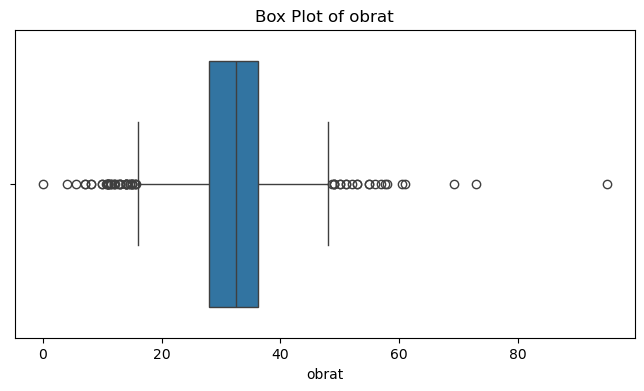

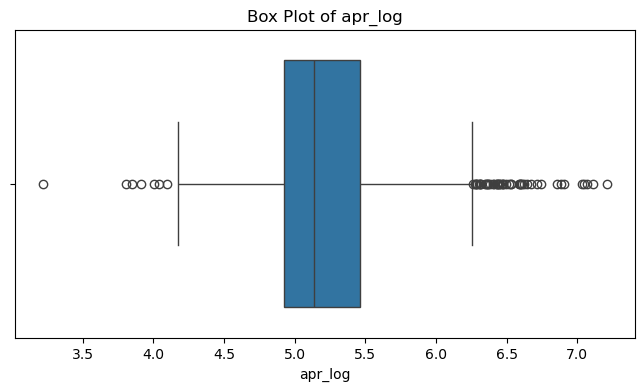

In [75]:
# Box plots for quantitative predictors:
for col in selected_qpred2:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=loanapp2[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

#### olsrr Library visualizations for outlier, leverage, and influence plots

In [76]:
%%R -i loanapp2

library(olsrr)

mreg_mod <- lm(loanprc_sq ~ appinc_log + liq_yj0 + obrat + apr_log + log_netw + male + married + sch + fixadj + term, data = loanapp2)

ols_plot_resid_lev(mreg_mod)


次のパッケージを付け加えます: ‘olsrr’

以下のオブジェクトは ‘package:datasets’ からマスクされています:

    rivers



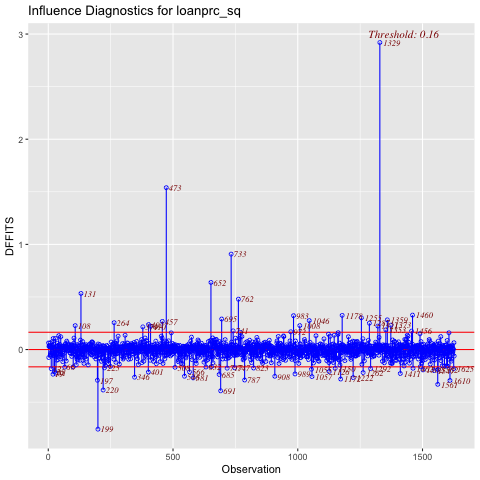

In [77]:
%%R -i loanapp2

library(olsrr)

mreg_mod <- lm(loanprc_sq ~ appinc_log + liq_yj0 + obrat + apr_log + log_netw + male + married + sch + fixadj + term, data = loanapp2)

ols_plot_dffits(mreg_mod)

We will create a simple linear regression model to identify potential outliers and data with unusual leverage and influence. We will create diagnostic plots on this model and identify unusual observations.

#### Residuals vs. Fitted Values plot - linearity and homoscedasticity of residuals

In [78]:
# Define the feature matrix X and target vector y
X = loanapp2[final_predictors2]
y = loanapp2[dependent_variable]

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the residuals
residuals = model.resid

# Plot residuals vs. fitted values
plt.figure(figsize=(8, 6))
sns.residplot(x=model.fittedvalues, y=y, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

Ideally, residuals should scatter randomly around the horizontal line at zero, indicating that the model's predictions are unbiased and errors are randomly distributed.
- Slight pattern in the residuals: non-linear curve around fitted values 0.8, suggesting potential non-linearity in the data or model misspecification.
- Few extreme residuals at the higher end of fitted values; outliers or heteroscedasticity

#### Externally studentized residuals

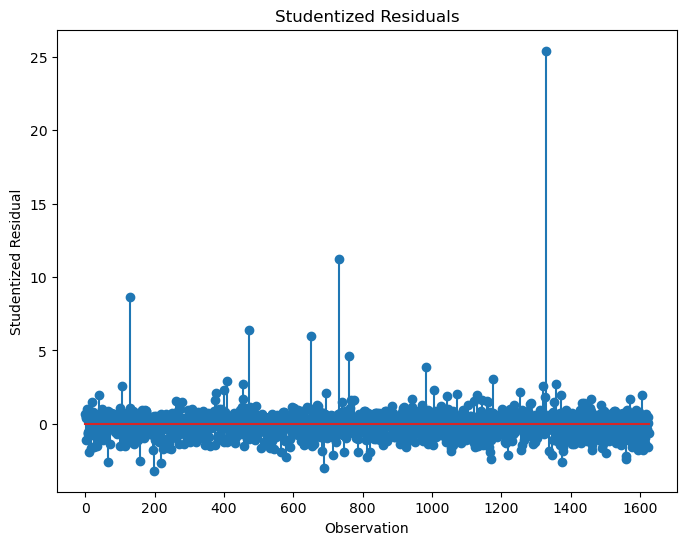

In [80]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(model)
studentized_residuals = influence.resid_studentized_external

# Plot studentized residuals
plt.figure(figsize=(8, 6))
plt.stem(studentized_residuals)
plt.xlabel('Observation')
plt.ylabel('Studentized Residual')
plt.title('Studentized Residuals')
plt.show()

Externally studentized residuals are more robust than standardized residuals, so we will plot them to detect influential observations. We will define the threshold as $\pm3$.

In [82]:
outlier_threshold = 3
outliers = np.where(abs(studentized_residuals) > outlier_threshold)[0]
print(f"Outliers based on studentized residuals (index positions): {outliers}")

Outliers based on studentized residuals (index positions): [ 130  198  472  651  690  732  761  982 1177 1328]


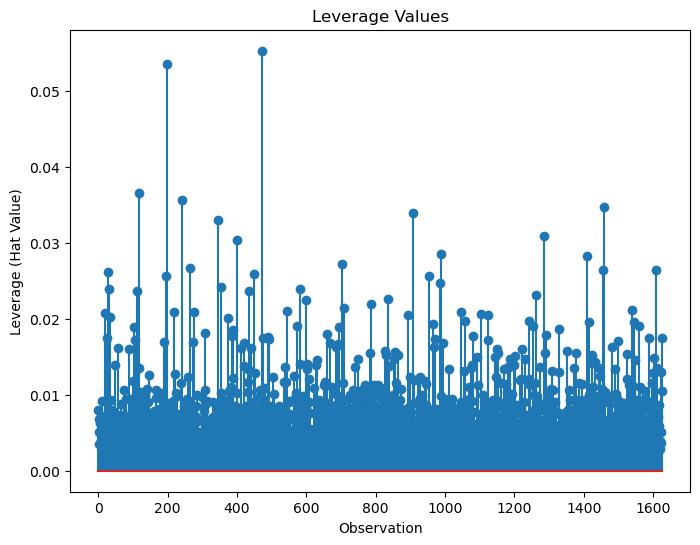

Average leverage value: 0.0068


In [83]:
hat_values = influence.hat_matrix_diag

# Plot hat values
plt.figure(figsize=(8, 6))
plt.stem(hat_values)
plt.xlabel('Observation')
plt.ylabel('Leverage (Hat Value)')
plt.title('Leverage Values')
plt.show()

# Average leverage value
avg_leverage = (X.shape[1]) / X.shape[0]
print(f"Average leverage value: {avg_leverage:.4f}")

In [87]:
high_leverage_threshold = 2 * avg_leverage
high_leverage_points = np.where(hat_values > high_leverage_threshold)[0]
print(f"High leverage points (index positions): {high_leverage_points}")

High leverage points (index positions): [  18   24   28   30   34   49   57   88  102  106  111  116  118  190
  196  198  219  241  263  273  276  307  345  354  375  384  388  400
  412  420  421  433  441  448  472  475  488  492  538  545  573  580
  581  599  601  629  631  658  668  684  690  694  702  708  740  749
  782  786  826  830  835  839  854  856  864  893  907  954  966  968
  971  986  988  993 1045 1056 1078 1081 1091 1103 1124 1125 1143 1149
 1152 1181 1184 1188 1199 1202 1221 1231 1242 1254 1261 1274 1286 1289
 1291 1329 1352 1379 1410 1414 1423 1425 1432 1455 1459 1481 1500 1524
 1540 1546 1547 1560 1587 1603 1609 1611 1625]


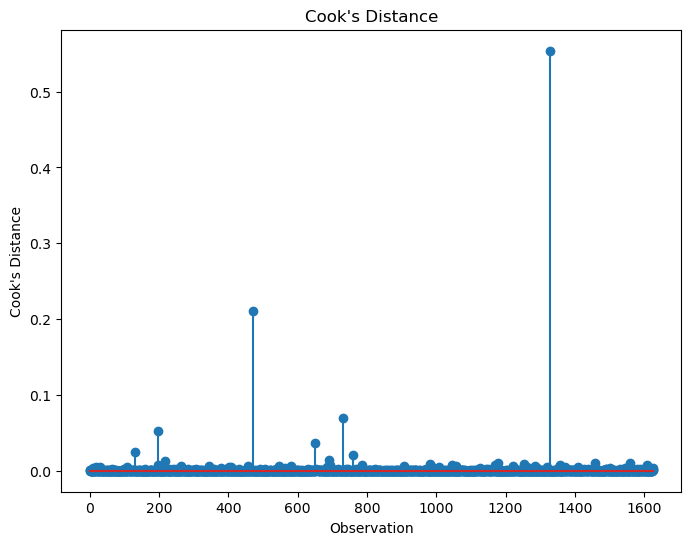

Influential points based on Cook's Distance (index positions): [  11   18   24   30   65  107  130  196  198  219  224  263  345  378
  400  401  409  456  472  507  545  565  580  631  651  684  690  694
  716  732  740  746  761  786  822  907  971  982  988 1007 1045 1054
 1056 1125 1149 1171 1177 1221 1254 1261 1286 1291 1320 1328 1352 1358
 1372 1410 1455 1459 1461 1501 1546 1560 1561 1609 1624]


In [88]:
cooks_d = influence.cooks_distance[0]

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.stem(cooks_d)
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.show()

# Identify influential points
influential_threshold = 4 / X.shape[0]  # Common rule of thumb
influential_points = np.where(cooks_d > influential_threshold)[0]
print(f"Influential points based on Cook's Distance (index positions): {influential_points}")

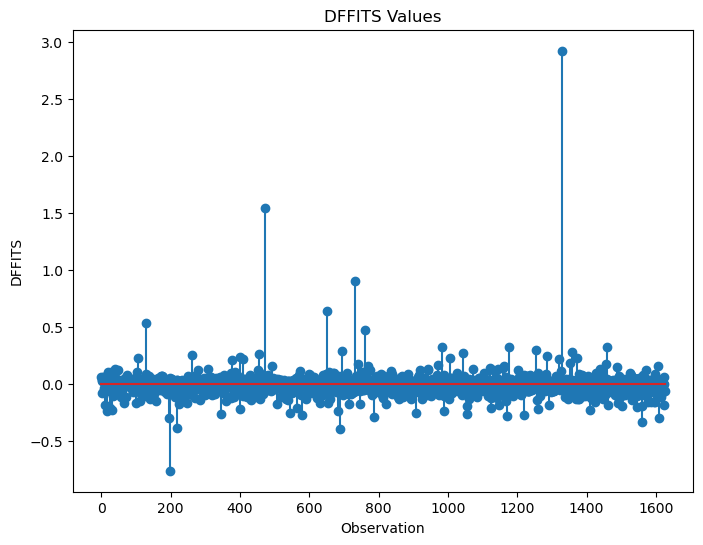

Influential points based on DFFITS (index positions): [  11   18   24   30  107  130  196  198  219  224  263  345  378  400
  401  409  456  472  545  565  580  651  684  690  694  716  732  740
  746  761  786  822  907  982  988 1007 1045 1054 1056 1125 1149 1171
 1177 1221 1254 1261 1286 1291 1320 1328 1352 1358 1372 1410 1455 1459
 1461 1501 1546 1560 1561 1609 1624]


In [89]:
dffits = influence.dffits[0]

# Plot DFFITS
plt.figure(figsize=(8, 6))
plt.stem(dffits)
plt.xlabel('Observation')
plt.ylabel('DFFITS')
plt.title('DFFITS Values')
plt.show()

# Identify influential points
dffits_threshold = 2 * np.sqrt((X.shape[1] + 1) / X.shape[0])
influential_dffits = np.where(abs(dffits) > dffits_threshold)[0]
print(f"Influential points based on DFFITS (index positions): {influential_dffits}")

In [90]:
dfbetas = influence.dfbetas

# For each coefficient, identify observations with large DFBETAS
dfbetas_threshold = 2 / np.sqrt(X.shape[0])

for i, col in enumerate(X.columns):
    large_dfbetas = np.where(abs(dfbetas[:, i]) > dfbetas_threshold)[0]
    if large_dfbetas.size > 0:
        print(f"Observations with large DFBETAS for {col}: {large_dfbetas}")

Observations with large DFBETAS for const: [  24   52   65   73   99  107  198  219  228  263  307  356  378  401
  409  448  452  456  459  472  532  545  580  606  623  631  651  716
  732  740  761  769  858  893  971 1007 1045 1062 1115 1122 1124 1149
 1177 1188 1221 1237 1254 1261 1320 1328 1346 1358 1370 1372 1391 1452
 1491 1526 1527 1547 1562 1572 1573 1587 1599 1609]
Observations with large DFBETAS for appinc_log: [  11   18   30   49   99  107  130  142  196  198  212  270  345  360
  378  400  401  409  472  521  545  580  631  632  651  659  684  690
  694  732  761  764  775  786  838  893  907  921  950  971 1003 1007
 1056 1062 1084 1117 1121 1125 1134 1149 1171 1256 1260 1261 1286 1320
 1328 1352 1410 1455 1459 1461 1495 1500 1541 1546 1560 1587 1603 1609]
Observations with large DFBETAS for liq_yj0: [  19   33   57  107  111  114  118  198  201  219  223  224  240  263
  270  279  284  299  382  409  421  472  492  507  573  580  592  648
  651  653  659  673  684  694

<Figure size 1000x800 with 0 Axes>

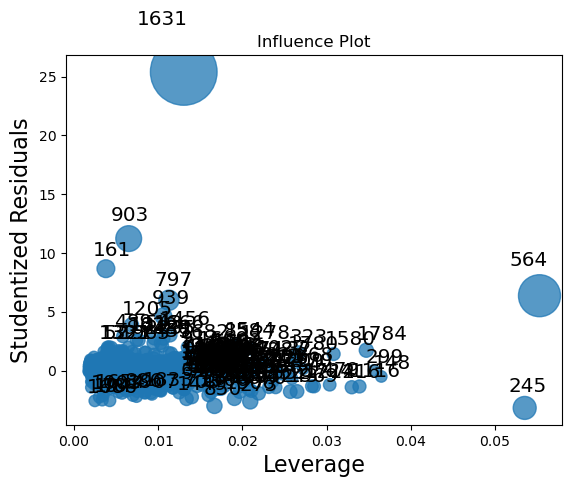

In [91]:
from statsmodels.graphics.regressionplots import influence_plot

plt.figure(figsize=(10, 8))
influence_plot(model, criterion="cooks")
plt.title('Influence Plot')
plt.show()

In [92]:
# View the observations identified as outliers
outlier_indices = np.unique(np.concatenate([outliers, high_leverage_points, influential_points, influential_dffits]))
print(f"Total unique unusual observations: {len(outlier_indices)}")

# Display the unusual observations
unusual_obs = loanapp2.iloc[outlier_indices]
unusual_obs

Total unique unusual observations: 151


loanprc  appinc    liq  obrat   term    apr      netw  male  married  \
14    0.203046      48   34.0   16.0  360.0  197.0   155.000   1.0      1.0   
21    0.480769     666  347.0   16.0  360.0  240.0   681.000   0.0      1.0   
28    0.298246      31   50.0   14.0  120.0   65.0    53.000   1.0      1.0   
32    1.000000      44   20.0   73.0  240.0  165.0    23.159   1.0      0.0   
35    0.751553     666   46.0   27.0  360.0  161.0    95.000   0.0      0.0   
...        ...     ...    ...    ...    ...    ...       ...   ...      ...   
1963  0.251969      39  117.0   17.0  360.0  385.0   299.000   0.0      1.0   
1969  0.753333     666   54.0   41.0  360.0  152.0    56.000   1.0      1.0   
1971  0.800000      67   34.0   25.0   84.0  120.0    56.000   1.0      0.0   
1985  0.111111     169   64.0   20.0  120.0  315.0  1745.000   1.0      1.0   
1986  1.000000      49   10.0   60.5  300.0  230.0     7.000   1.0      1.0   

      sch  fixadj  appinc_log   liq_yj0   apr_log  log_netw  loanprc_sq  
14      0       1    3.871201  3.555348  5.283204  5.049856    0.041228  
21      1       0    6.501290  5.852202  5.480639  6.525030    0.231139  
28      1       0    3.433987  3.931826  4.174387  3.988984    0.088950  
32      0       0    3.784190  3.044522  5.105945  3.184657    1.000000  
35      1       0    6.501290  3.850148  5.081404  4.564348    0.564832  
...   ...     ...         ...       ...       ...       ...         ...  
1963    1       0    3.663562  4.770685  5.953243  5.703782    0.063488  
1969    0       0    6.501290  4.007333  5.023881  4.043051    0.567511  
1971    1       0    4.204693  3.555348  4.787492  4.043051    0.640000  
1985    1       0    5.129899  4.174387  5.752573  7.465083    0.012346  
1986    0       1    3.891820  2.397895  5.438079  2.079442    1.000000  

[151 rows x 16 columns]

In [93]:
# Create a boolean mask
mask = np.ones(len(loanapp2), dtype=bool)
mask[outlier_indices] = False

# Apply the mask to create the new DataFrame
loanapp3 = loanapp2.iloc[mask]

# Optionally, reset the index
loanapp3.reset_index(drop=True, inplace=True)

In [94]:
loanapp3.head()

loanprc  appinc    liq      obrat   term    apr   netw  male  married  \
0  0.895105      84   37.0  26.000000  180.0  145.0   40.0   1.0      0.0   
1  0.600000      36   19.0  37.000000  360.0  110.0  158.0   1.0      1.0   
2  0.895522      59   31.0  32.099998  360.0  135.0   69.0   1.0      1.0   
3  0.804348      63  169.0  33.000000  360.0  144.0  262.0   1.0      0.0   
4  0.898089      72   38.0  36.000000  360.0  162.0   46.0   1.0      0.0   

   sch  fixadj  appinc_log   liq_yj0   apr_log  log_netw  loanprc_sq  
0    1       0    4.430817  3.637586  4.976734  3.713572    0.801213  
1    1       0    3.583519  2.995732  4.700480  5.068904    0.360000  
2    0       0    4.077537  3.465736  4.905275  4.248495    0.801960  
3    0       0    4.143135  5.135798  4.969813  5.572154    0.646975  
4    1       0    4.276666  3.663562  5.087596  3.850148    0.806564

#### Check the distribution of quantitative variables after removing unusual obervations

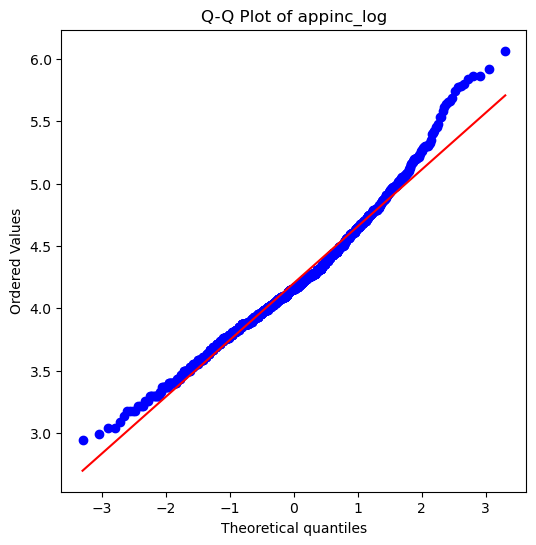

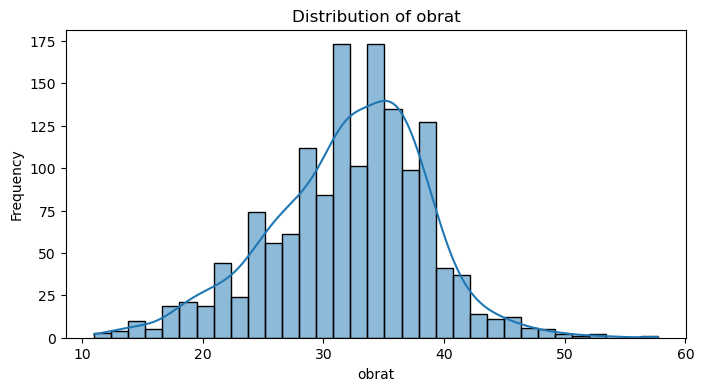

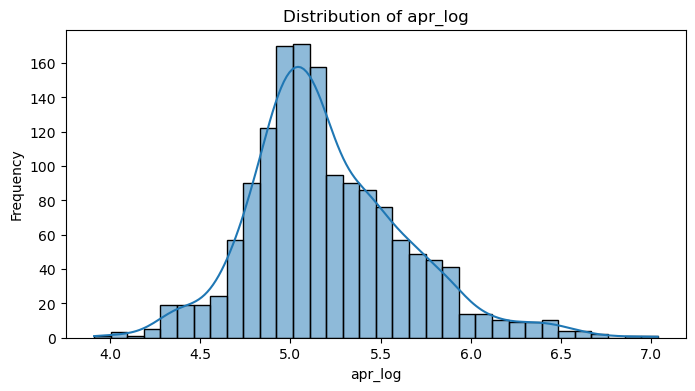

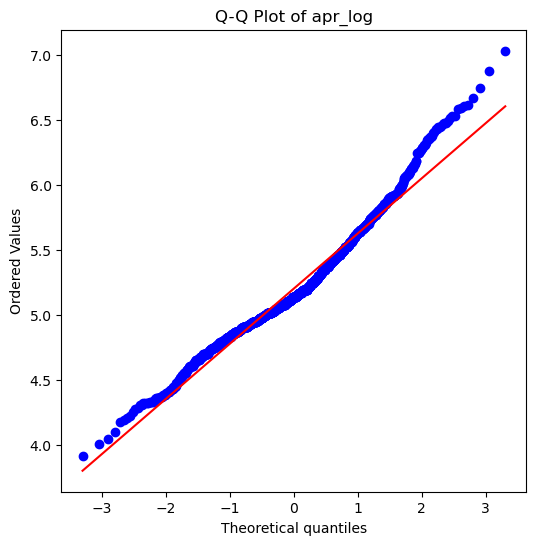

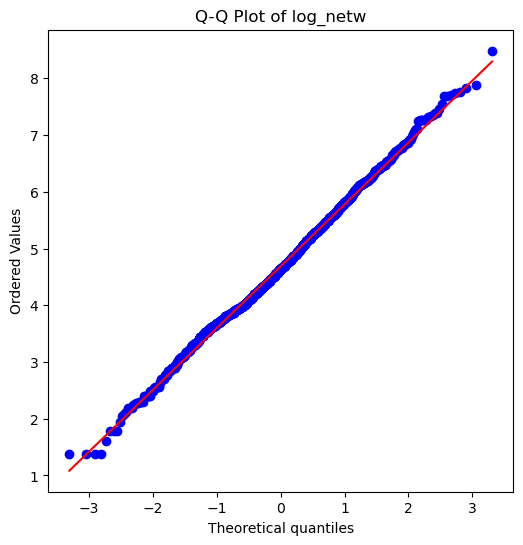

In [95]:
for col in selected_qpred2:
    plotter(col, loanapp3)

### (e) If you have any NAs, remove them or impute them using any of the methods discussed in class, but make sure to justify your choice.

In [96]:
# Check for missing values
print("Missing values after outlier handling:")
print(loanapp3.isnull().sum())

Missing values after outlier handling:
loanprc       0
appinc        0
liq           0
obrat         0
term          0
apr           0
netw          0
male          0
married       0
sch           0
fixadj        0
appinc_log    0
liq_yj0       0
apr_log       0
log_netw      0
loanprc_sq    0
dtype: int64


We don't have any missing values for all predictors/dependent variables.

In [98]:
loanapp3

loanprc  appinc         liq      obrat   term    apr        netw  male  \
0     0.895105      84   37.000000  26.000000  180.0  145.0   40.000000   1.0   
1     0.600000      36   19.000000  37.000000  360.0  110.0  158.000000   1.0   
2     0.895522      59   31.000000  32.099998  360.0  135.0   69.000000   1.0   
3     0.804348      63  169.000000  33.000000  360.0  144.0  262.000000   1.0   
4     0.898089      72   38.000000  36.000000  360.0  162.0   46.000000   1.0   
...        ...     ...         ...        ...    ...    ...         ...   ...   
1471  0.800633      90   70.000000  40.299999  360.0  317.0  138.000000   1.0   
1472  0.575385      91  130.000000  29.000000  360.0  325.0  539.000000   1.0   
1473  0.750000      46   47.000000  28.799999  360.0  162.0   89.000000   1.0   
1474  0.897727      96   15.000000  29.299999  360.0  176.0   19.000000   1.0   
1475  0.455814     110  427.899994  17.000000  180.0  180.0  641.900024   1.0   

      married  sch  fixadj  appinc_log   liq_yj0   apr_log  log_netw  \
0         0.0    1       0    4.430817  3.637586  4.976734  3.713572   
1         1.0    1       0    3.583519  2.995732  4.700480  5.068904   
2         1.0    0       0    4.077537  3.465736  4.905275  4.248495   
3         0.0    0       0    4.143135  5.135798  4.969813  5.572154   
4         0.0    1       0    4.276666  3.663562  5.087596  3.850148   
...       ...  ...     ...         ...       ...       ...       ...   
1471      1.0    1       1    4.499810  4.262680  5.758902  4.934474   
1472      1.0    1       0    4.510860  4.875197  5.783825  6.291569   
1473      0.0    1       0    3.828641  3.871201  5.087596  4.499810   
1474      1.0    1       1    4.564348  2.772589  5.170484  2.995732   
1475      0.0    1       0    4.700480  6.061224  5.192957  6.465989   

      loanprc_sq  
0       0.801213  
1       0.360000  
2       0.801960  
3       0.646975  
4       0.806564  
...          ...  
1471    0.641013  
1472    0.331067  
1473    0.562500  
1474    0.805914  
1475    0.207766  

[1476 rows x 16 columns]

# 3. Model Building

Best subset: ['obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'] 

                                                    subsets          AIC
(obrat, fixadj, appinc_log, liq_yj0, apr_log, l...        6 -1156.871020
(obrat, sch, fixadj, appinc_log, liq_yj0, apr_l...        7 -1155.930672
(obrat, married, sch, fixadj, appinc_log, liq_y...        8 -1154.851354
(obrat, male, married, sch, fixadj, appinc_log,...        9 -1152.990608
(obrat, appinc_log, liq_yj0, apr_log, log_netw)           5 -1137.291279
(appinc_log, liq_yj0, apr_log, log_netw)                  4 -1019.839484
(appinc_log, liq_yj0, log_netw)                           3  -885.666517
(liq_yj0, log_netw)                                       2  -800.379138
(log_netw,)                                               1  -737.651702


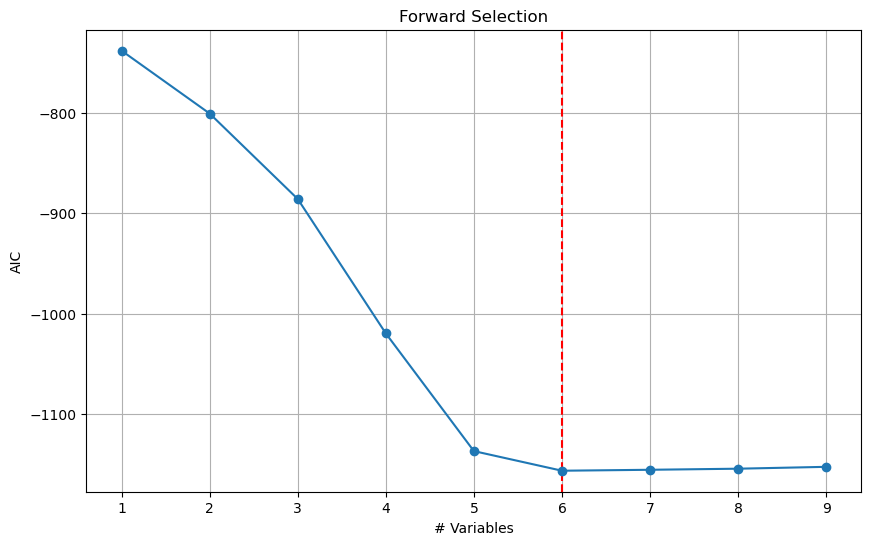

In [99]:
# Copy data and drop specified columns
loanapp4 = loanapp3.copy()
loanapp4 = loanapp4.drop(['appinc', 'liq', 'term', 'apr', 'netw'], axis=1)

# Negative AIC function for scoring
def negative_AIC(estimator, X, y):
    model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
    return -model.aic  # AIC is minimized, so return negative for maximization

# Define target and features
loanapp_Y = loanapp4['loanprc_sq'].values
loanapp_X = loanapp4.drop(['loanprc_sq', 'loanprc'], axis=1)

# Set up linear regression model
lr = LinearRegression(fit_intercept=True)

# Perform Forward Selection using `SequentialFeatureSelector` from `mlxtend`
loanapp_forward = SFS(lr,
                      forward=True,
                      k_features=(1, loanapp_X.shape[1]),  # Dynamically set max features
                      scoring=negative_AIC,
                      cv=None)  # No cross-validation for AIC

# Fit the forward selection
loanapp_forward = loanapp_forward.fit(loanapp_X, loanapp_Y)

# Display best subset
print('Best subset:', [n for n in loanapp_forward.k_feature_names_], '\n')

# Extract subset metrics
loanapp_fwd_metrics = loanapp_forward.get_metric_dict()
loanapp_fwd_features = [loanapp_fwd_metrics[p]['feature_names'] for p in loanapp_fwd_metrics]
loanapp_fwd_subset = [len(loanapp_fwd_metrics[p]['feature_idx']) for p in loanapp_fwd_metrics]
loanapp_fwd_aic = [-loanapp_fwd_metrics[p]['avg_score'] for p in loanapp_fwd_metrics]  # Reverse negative AIC for display

# Create DataFrame of results
loanapp_forward_df = pd.DataFrame({'subsets': loanapp_fwd_subset, 'AIC': loanapp_fwd_aic}, index=loanapp_fwd_features)

# Display DataFrame sorted by AIC
print(loanapp_forward_df.sort_values(by='AIC'))

# Plotting results
plt.figure(figsize=(10, 6))
plt.axvline(x=np.argmin(loanapp_forward_df['AIC']) + 1, linestyle='--', color='red')
plt.plot(loanapp_forward_df['subsets'], loanapp_forward_df['AIC'], marker='o')
plt.title('Forward Selection')
plt.xlabel('# Variables')
plt.ylabel('AIC')
plt.grid(True)
plt.show()

Best subset: ['obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'] 

                                                    subsets          BIC
(obrat, fixadj, appinc_log, liq_yj0, apr_log, l...        6 -1119.791383
(obrat, sch, fixadj, appinc_log, liq_yj0, apr_l...        7 -1113.553944
(obrat, married, sch, fixadj, appinc_log, liq_y...        8 -1107.177535
(obrat, appinc_log, liq_yj0, apr_log, log_netw)           5 -1105.508733
(obrat, male, married, sch, fixadj, appinc_log,...        9 -1100.019698
(obrat, appinc_log, apr_log, log_netw)                    4 -1051.456532
(appinc_log, apr_log, log_netw)                           3  -922.128310
(appinc_log, log_netw)                                    2  -780.171479
(log_netw,)                                               1  -727.057520


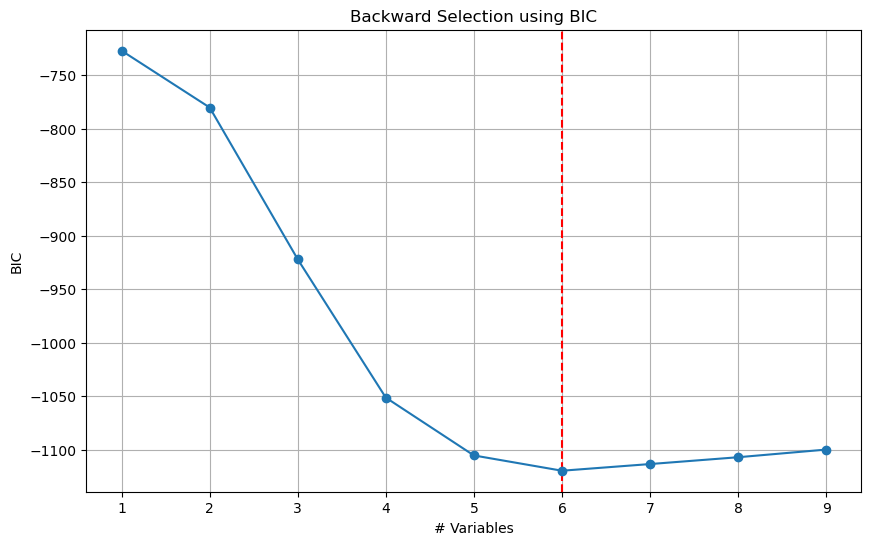

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# Define negative BIC function
def negative_BIC(estimator, X, y):
    model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
    return -model.bic  # BIC is minimized, so return negative for maximization

# Initialize backward selection (note: forward=False for backward selection)
lr = LinearRegression()
loanapp_backward = SFS(lr,
                       forward=False,  # Backward selection
                       k_features=(1, loanapp_X.shape[1]),  # Dynamically set max features
                       scoring=negative_BIC,  # Using BIC as the score function
                       cv=0)  # Set cv=0 for no cross-validation

# Fit the backward selection
loanapp_backward = loanapp_backward.fit(loanapp_X, loanapp_Y)

# Display the best subset found
print('Best subset:', [loanapp_X.columns[i] for i in loanapp_backward.k_feature_idx_], '\n')

# Extract subset data
loanapp_bwd_metrics = loanapp_backward.get_metric_dict()
loanapp_bwd_features = [loanapp_bwd_metrics[p]['feature_names'] for p in loanapp_bwd_metrics]
loanapp_bwd_subset = [len(loanapp_bwd_metrics[p]['feature_idx']) for p in loanapp_bwd_metrics]
loanapp_bwd_bic = [-loanapp_bwd_metrics[p]['avg_score'] for p in loanapp_bwd_metrics]  # Reverse negative BIC for display

# Create DataFrame with results
loanapp_backward_df = pd.DataFrame({'subsets': loanapp_bwd_subset, 'BIC': loanapp_bwd_bic}, index=loanapp_bwd_features)

# Display DataFrame sorted by BIC
print(loanapp_backward_df.sort_values(by='BIC'))

# Plotting results
plt.figure(figsize=(10, 6))
plt.axvline(x=np.argmin(loanapp_backward_df['BIC']) + 3, linestyle='--', color='red')
plt.plot(loanapp_backward_df['subsets'], loanapp_backward_df['BIC'], marker='o')
plt.title('Backward Selection using BIC')
plt.xlabel('# Variables')
plt.ylabel('BIC')
plt.grid(True)
plt.show()

Features: 511/511

Best subset: ['obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw']


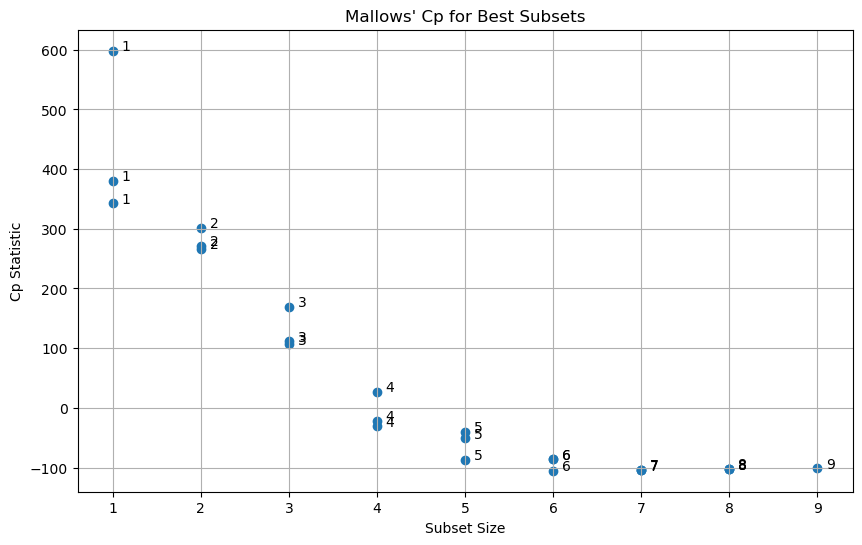

                                                            subsets  \
subsets                                                               
6       ('obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'a...        6   
7       ('obrat', 'sch', 'fixadj', 'appinc_log', 'liq_y...        7   
        ('obrat', 'married', 'fixadj', 'appinc_log', 'l...        7   
        ('obrat', 'male', 'fixadj', 'appinc_log', 'liq_...        7   
8       ('obrat', 'married', 'sch', 'fixadj', 'appinc_l...        8   
        ('obrat', 'male', 'sch', 'fixadj', 'appinc_log'...        8   
        ('obrat', 'male', 'married', 'fixadj', 'appinc_...        8   
9       ('obrat', 'male', 'married', 'sch', 'fixadj', '...        9   
5       ('obrat', 'appinc_log', 'liq_yj0', 'apr_log', '...        5   
6       ('obrat', 'married', 'appinc_log', 'liq_yj0', '...        6   
        ('obrat', 'sch', 'appinc_log', 'liq_yj0', 'apr_...        6   
5       ('obrat', 'fixadj', 'appinc_log', 'apr_log', 'l...        5   
      

In [109]:
# Fit initial model with all variables
model1 = smf.ols('loanprc_sq ~ liq_yj0 + log_netw + appinc_log + apr_log  + male + married + fixadj + sch', data=loanapp4).fit()
model1.summary()

# Store residual MSE from model1
model1_sig2 = model1.mse_resid  # Residual MSE (sigma^2 hat)
loanapp_n, _ = loanapp4.shape  # Number of observations

# Negative Mallows' Cp function for scoring
def negative_mallows(estimator, X, y):
    y_pred = estimator.predict(X)
    sse = np.sum((y - y_pred) ** 2)
    p = estimator.n_features_in_ + 1  # Number of predictors including intercept
    cp = sse / model1_sig2 + 2 * p - loanapp_n
    return -cp  # Return negative Cp to maximize

# Prepare target and features
loanapp_Y = loanapp4['loanprc_sq'].values
loanapp_X = loanapp4.drop(columns=['loanprc_sq', 'loanprc'])  # Drop the target variable

# Initialize linear regression model
lr = LinearRegression(fit_intercept=True)

# Exhaustive feature selection using `ExhaustiveFeatureSelector`
loanapp_efs = EFS(lr,
                  min_features=1,
                  max_features=9,  # Adjust as needed for your data
                  scoring=negative_mallows,
                  cv=None)  # No cross-validation for Mallows' Cp

# Fit the selector
loanapp_efs = loanapp_efs.fit(loanapp_X, loanapp_Y)

# Display best subset
print('Best subset:', [loanapp_X.columns[i] for i in loanapp_efs.best_idx_])

# Extract subsets and Cp data
loanapp_efs_metrics = loanapp_efs.subsets_
loanapp_efs_features = [loanapp_efs_metrics[p]['feature_names'] for p in loanapp_efs_metrics]
loanapp_efs_subset = [len(loanapp_efs_metrics[p]['feature_idx']) for p in loanapp_efs_metrics]
loanapp_efs_cp = [-loanapp_efs_metrics[p]['avg_score'] for p in loanapp_efs_metrics]  # Convert back to positive Cp

# Create a DataFrame for visualization
loanapp_mallows = pd.DataFrame({'subsets': loanapp_efs_subset, 'Cp': loanapp_efs_cp}, index=[str(f) for f in loanapp_efs_features])

# Display top 3 best subsets by Cp
loanapp_mallows_best = loanapp_mallows.groupby('subsets').apply(lambda x: x.nsmallest(3, 'Cp'))

# Plotting the best subsets by Mallows' Cp
plt.figure(figsize=(10, 6))
plt.scatter(loanapp_mallows_best['subsets'], loanapp_mallows_best['Cp'], marker='o')
plt.title("Mallows' Cp for Best Subsets")
plt.xlabel('Subset Size')
plt.ylabel('Cp Statistic')
for i, sub in enumerate(loanapp_mallows_best['subsets']):
    subset = loanapp_mallows_best.index[i][0]  # Adjust indexing for display
    plt.annotate(subset, (sub + 0.1, loanapp_mallows_best.iloc[i]['Cp'] + 0.3))  # Add labels to points
plt.grid(True)
plt.show()

# Display sorted DataFrame with results
print(loanapp_mallows_best.sort_values('Cp'))

In [110]:
# Sort the DataFrame by Cp values in ascending order (since lower Cp is better)
top_3_models = loanapp_mallows.sort_values(by='Cp').head(3)

# Display the top 3 models
print("Top 3 models based on Mallows' Cp:\n")
print(top_3_models)

# If you want more detailed extraction of the subsets
for i, row in top_3_models.iterrows():
    print(f"Subset {i} - Features: {i}, Cp: {row['Cp']}")

Top 3 models based on Mallows' Cp:

                                                    subsets          Cp
('obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'a...        6 -105.350165
('obrat', 'sch', 'fixadj', 'appinc_log', 'liq_y...        7 -104.323784
('obrat', 'married', 'fixadj', 'appinc_log', 'l...        7 -103.985961
Subset ('obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw') - Features: ('obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'), Cp: -105.35016510158312
Subset ('obrat', 'sch', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw') - Features: ('obrat', 'sch', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'), Cp: -104.32378362597842
Subset ('obrat', 'married', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw') - Features: ('obrat', 'married', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'), Cp: -103.985961031643


#### Based on the Mallows CP results above, we selected the three best subsets of explanatory variables, which are:
**1) 'obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'**

**2) 'obrat', 'sch', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'**

**3) 'obrat', 'married', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'**

---
## Model 1: 'obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'
---

In [111]:
loanapp4 = loanapp3.copy()
loanapp4['loanprc_sq'] = loanapp4['loanprc']**2

mallows1 = loanapp4[['loanprc_sq', 'obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw']]

In [112]:
mallows1_reg = smf.ols('loanprc_sq ~ obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw', mallows1).fit()
mallows1_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             loanprc_sq   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     184.7
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.61e-175
Time:                        14:16:26   Log-Likelihood:                 585.44
No. Observations:                1476   AIC:                            -1157.
Df Residuals:                    1469   BIC:                            -1120.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9787      0.058     16.906      0.000       0.865       1.092
obrat          0.0078      0.001     11.039      0.000       0.006       0.009
fixadj         0.0437      0.009      4.651      0.000       0.025       0.062
appinc_log     0.2502      0.014     18.190      0.000       0.223       0.277
liq_yj0       -0.0472      0.006     -7.833      0.000      -0.059      -0.035
apr_log       -0.2449      0.016    -15.371      0.000      -0.276      -0.214
log_netw      -0.0500      0.006     -8.505      0.000      -0.062      -0.038
==============================================================================
Omnibus:                       29.532   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.031
Skew:                          -0.182   Prob(JB):                     1.01e-10
Kurtosis:                       3.785   Cond. No.                         467.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the summary, all coefficients of variables are statistically significant at any confidence level.

---
#### Test for Multicolinearity
---

In [113]:
# check for multicollinearity

#VIF
mallows1_exog = mallows1.drop('loanprc_sq', axis = 1)
mallows1_exog_vars = mallows1_exog.columns
mallows1_exog = sm.add_constant(mallows1)

mallows1_VIF = []
for i,v in enumerate(mallows1_exog_vars):
    mallows1_VIF.append(variance_inflation_factor(exog=mallows1_exog, exog_idx=i+1)) # `exog_idx` is col index of predictor

pd.DataFrame({
    'Variable':mallows1_exog_vars,
    'VIF':mallows1_VIF
}).sort_values(by='VIF')

# No multicolinearity present

Variable       VIF
2  appinc_log  1.028293
1      fixadj  1.257769
0       obrat  1.754245
4     apr_log  2.153759
3     liq_yj0  2.696015
5    log_netw  3.018498

---
#### Test for Heteroskedasticity
---

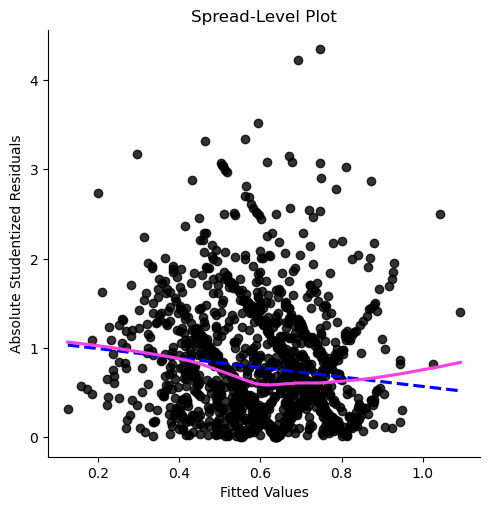

Suggested power transform: 1.4772


In [116]:
# detect heteroskedasticity

# Extract studentized residuals
mallows1_std_resid = mallows1_reg.get_influence().resid_studentized_external # STUDENTIZED residuals
mallows1_spreadlevel = pd.DataFrame({
    'Fitted Values':mallows1_reg.fittedvalues,
    'Absolute Studentized Residuals':np.abs(mallows1_std_resid)
})

# Plot spread-level plot
sns.lmplot(mallows1_spreadlevel, x='Fitted Values', y='Absolute Studentized Residuals',
           line_kws={'color':'blue', 'linestyle':'--'}, ci=False, scatter_kws={'color':'black'})
sns.regplot(mallows1_spreadlevel, x='Fitted Values', y='Absolute Studentized Residuals',
            color='#f542e3', lowess=True, scatter=False)
plt.title('Spread-Level Plot')
plt.show()

# Power transform
mallows1_rlm = RLM(endog=np.log(np.abs(mallows1_std_resid)),            # y = log absolute studentized residuals
                   exog=sm.add_constant(np.log(mallows1_reg.fittedvalues))  # x = log fitted values
                   ).fit()

print(f'Suggested power transform: {1 - mallows1_rlm.params[0]:.4f}')

From the above plot, we might think that there is heteroskedasticity is present. However, by rounding the suggested power transform to the nearest integer, we do not have to apply any transformations.

In [117]:
# BP Test
mallows1_bp = sm.stats.het_breuschpagan(resid=mallows1_reg.resid, exog_het=sm.add_constant(mallows1.drop('loanprc_sq', axis=1)))
print(f'Test statistic: \t{mallows1_bp[0]:.5f}\np-value: \t\t{mallows1_bp[1]:.5f}')

Test statistic: 	32.38317
p-value: 		0.00001


In [118]:
# White Test
sm.stats.diagnostic.het_white(mallows1_reg.resid, sm.add_constant(mallows1.drop('loanprc_sq', axis=1)))

(105.47273786955772,
 1.5525646417349384e-11,
 4.288916373110632,
 5.126381208522331e-12)

Based on these results, Heteroskedasticity appears to be present.

---
#### Test for Misspecification
---

In [120]:
# RESET Test

print(linear_reset(mallows1_reg, power=2, test_type='fitted', use_f=True))

<F test: F=41.121466215187304, p=1.9240759485656225e-10, df_denom=1.47e+03, df_num=1>


The Ramsey RESET Test for misspecification suggests that our model is misspecified. We will consider adding interaction terms with `fixadj` and quadratic terms of our non-transformed variables (for the sake of interpretability) to see if we can improve this.

In [121]:
# Check for interaction effects with factor variable "fixadj"

labels = {0: 'Adjustable', 1: 'Fixed'}
loanapp4['fixadj_bucket'] = loanapp4['fixadj'].replace(labels)

# Verify the distribution of the new column
print(loanapp4['fixadj_bucket'].value_counts())

fixadj_bucket
Adjustable    1043
Fixed          433
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

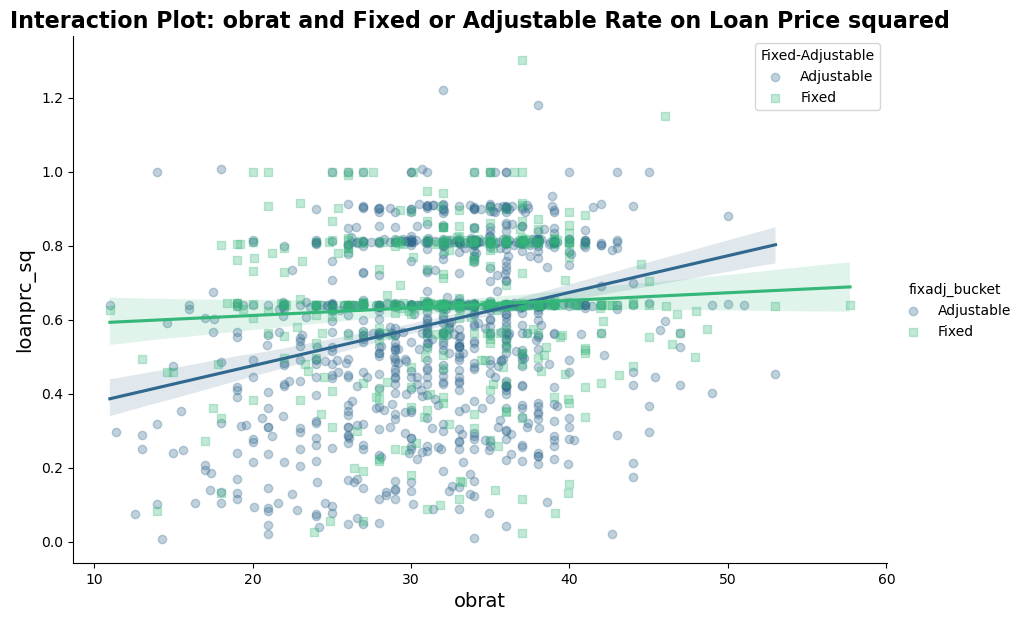

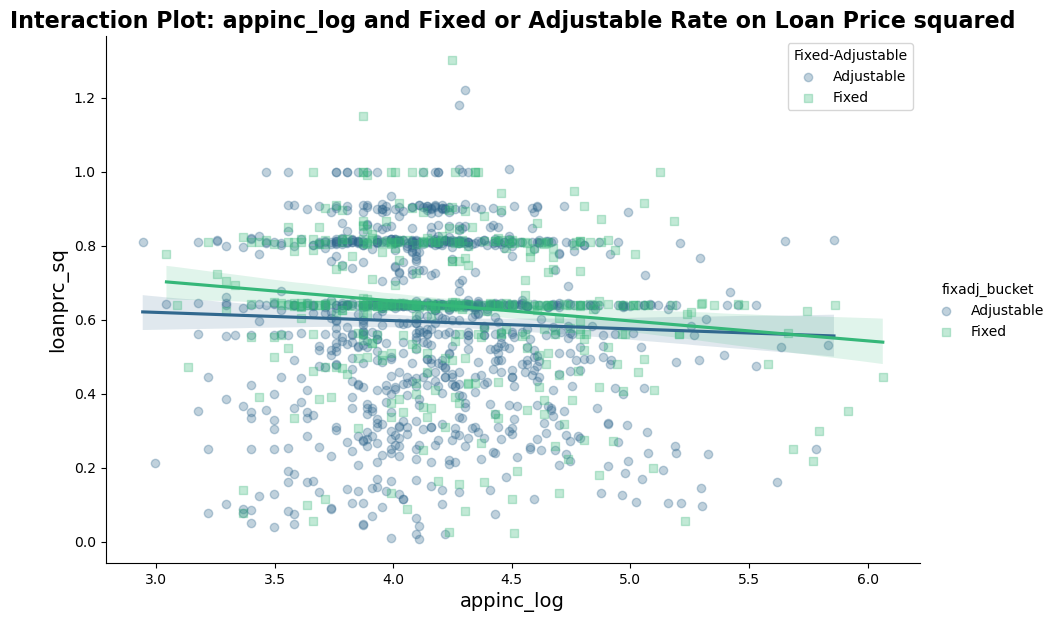

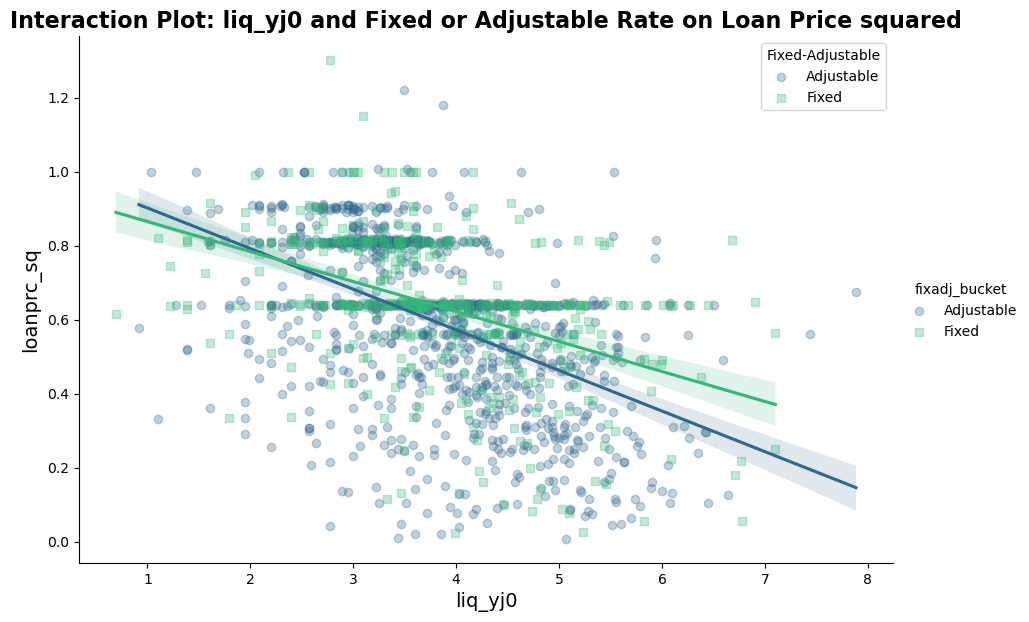

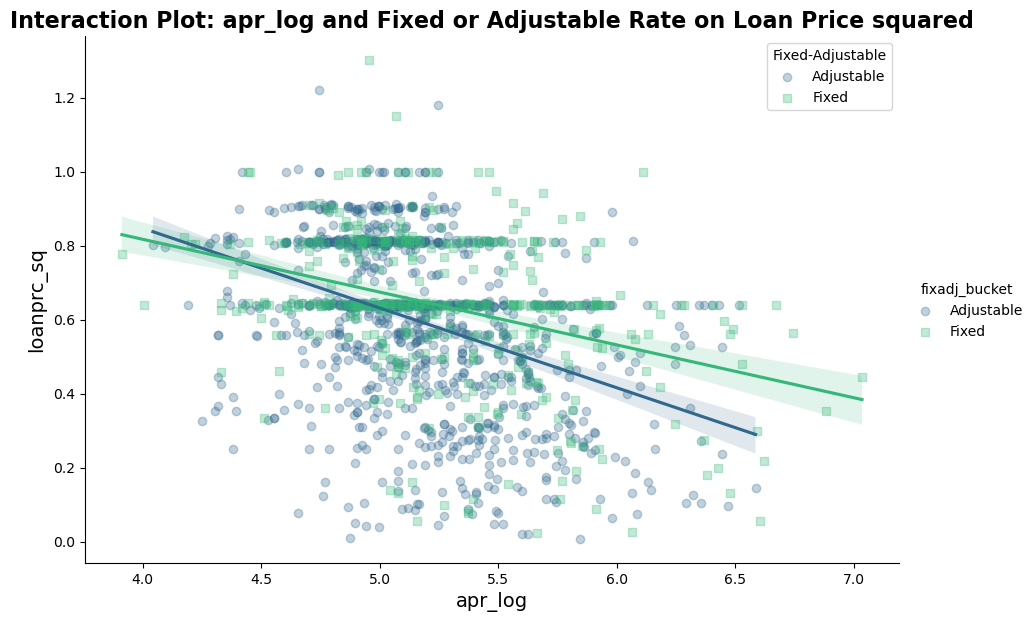

In [122]:
plt.figure(figsize=(10, 6))

# Create the interaction plot with seaborn's lmplot for each quantitative variable in the model
mallows1_quant = ['obrat', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw']

for var in mallows1_quant:
    sns.lmplot(
        x=var,
        y='loanprc_sq',
        hue='fixadj_bucket',
        data=loanapp4,
        aspect=1.5,
        markers=['o', 's'],
        palette='viridis',
        height=6,
        scatter_kws={'alpha':0.3}
    )
    
    # Enhance plot aesthetics
    plt.title('Interaction Plot: ' + var + ' and Fixed or Adjustable Rate on Loan Price squared', fontsize=16, fontweight='bold')
    plt.xlabel(var, fontsize=14)
    plt.ylabel('loanprc_sq', fontsize=14)
    plt.legend(title='Fixed-Adjustable')
    
    plt.show()

From looking at the graph above, it appears that the value of the variable fixadj makes the biggest difference in the variables obrat and log_netw. So we will use a regression mdoel that uses these interaction terms.

Since the only non-transformed quantitative variable is `obrat`, we will also add the quadratic term of variable.

In [131]:
mallows1_regsq = smf.ols('loanprc_sq ~ obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat + fixadj:log_netw + I(obrat**2)', mallows1).fit()
mallows1_regsq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             loanprc_sq   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     131.5
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.02e-181
Time:                        14:36:00   Log-Likelihood:                 607.51
No. Observations:                1476   AIC:                            -1195.
Df Residuals:                    1466   BIC:                            -1142.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7507      0.093      8.051      0.000       0.568       0.934
obrat               0.0255      0.004      5.885      0.000       0.017       0.034
fixadj             -0.0194      0.065     -0.300      0.764      -0.146       0.107
appinc_log          0.2522      0.014     18.410      0.000       0.225       0.279
liq_yj0            -0.0462      0.006     -7.767      0.000      -0.058      -0.035
apr_log            -0.2482      0.016    -15.684      0.000      -0.279      -0.217
log_netw           -0.0596      0.007     -9.133      0.000      -0.072      -0.047
fixadj:obrat       -0.0028      0.001     -1.966      0.050      -0.006   -5.83e-06
fixadj:log_netw     0.0330      0.008      4.066      0.000       0.017       0.049
I(obrat ** 2)      -0.0003   6.84e-05     -3.946      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       39.811   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.391
Skew:                          -0.186   Prob(JB):                     1.16e-16
Kurtosis:                       4.027   Cond. No.                     2.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We noticed that the coefficient on the quadratic term can be approximated to 0 to up to 3 decimal points, and its 95% CI is also approximated to $[-0.000, -0.000]$. Given its economic insignificance, we decided not to include it in our model.

In [132]:
# Run model with interaction terms, without quadratic terms
mallows1_reg2 = smf.ols('loanprc_sq ~ obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat + fixadj:log_netw', mallows1).fit()
mallows1_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             loanprc_sq   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     144.6
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          3.58e-179
Time:                        14:36:04   Log-Likelihood:                 599.71
No. Observations:                1476   AIC:                            -1181.
Df Residuals:                    1467   BIC:                            -1134.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0199      0.064     15.968      0.000       0.895       1.145
obrat               0.0087      0.001     10.344      0.000       0.007       0.010
fixadj             -0.0184      0.065     -0.283      0.777      -0.146       0.109
appinc_log          0.2457      0.014     17.977      0.000       0.219       0.273
liq_yj0            -0.0467      0.006     -7.808      0.000      -0.058      -0.035
apr_log            -0.2432      0.016    -15.341      0.000      -0.274      -0.212
log_netw           -0.0631      0.007     -9.710      0.000      -0.076      -0.050
fixadj:obrat       -0.0033      0.001     -2.302      0.021      -0.006      -0.000
fixadj:log_netw     0.0357      0.008      4.389      0.000       0.020       0.052
==============================================================================
Omnibus:                       37.333   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.891
Skew:                          -0.199   Prob(JB):                     1.34e-14
Kurtosis:                       3.938   Cond. No.                         654.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We noticed that when adding interaction terms with `fixadj`, the coefficient of `fixadj` becomes individually statistically insignificant.

In [130]:
print(linear_reset(mallows1_reg2, power=2, test_type='fitted', use_f=True))

<F test: F=21.727593260067586, p=3.4278537271008814e-06, df_denom=1.47e+03, df_num=1>


Adding an interaction between the variable `fixadj` and the variables `obrat` and `log_netw` improved the $R^2$, and both effects are statistically significant. It also improved the p-values of the Ramsey RESET test, although we still reject the null for both tests. Additionally, both the AIC and BIC decreased significantly compared to the original model.

---
#### Use AIC, BIC, and Mallows CP for model selection.
---

In [135]:
# List of feature combinations to test
mallows1_features = [
    'obrat',
    'obrat + fixadj',
    'obrat + fixadj + appinc_log',
    'obrat + fixadj + appinc_log + liq_yj0',
    'obrat + fixadj + appinc_log + liq_yj0 + apr_log',
    'obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw',
    'obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat',
    'obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat + fixadj:log_netw',
]

# Fit models incrementally
models = [smf.ols(f'loanprc_sq ~ {features}', data=mallows1).fit() for features in mallows1_features]

# Collect AIC values for each model
aic_values = pd.DataFrame([model.aic for model in models], index=mallows1_features, columns=['AIC'])

# Display the AIC values
print(aic_values.to_string())

# Interpretation: The model with the lowest AIC is preferred.

                                                                                                     AIC
obrat                                                                                        -411.989622
obrat + fixadj                                                                               -420.660723
obrat + fixadj + appinc_log                                                                  -419.517708
obrat + fixadj + appinc_log + liq_yj0                                                        -795.528356
obrat + fixadj + appinc_log + liq_yj0 + apr_log                                             -1087.928696
obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw                                  -1156.871020
obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat                   -1164.174145
obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat + fixadj:log_netw -1181.426681


In [136]:
# Collect BIC values for each model
bic_values = pd.DataFrame([model.bic for model in models], index=mallows1_features, columns=['BIC'])

# Display the BIC values
print(bic_values.to_string())

# Interpretation: The model with the lowest BIC is preferred.

                                                                                                     BIC
obrat                                                                                        -401.395440
obrat + fixadj                                                                               -404.769450
obrat + fixadj + appinc_log                                                                  -398.329344
obrat + fixadj + appinc_log + liq_yj0                                                        -769.042901
obrat + fixadj + appinc_log + liq_yj0 + apr_log                                             -1056.146150
obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw                                  -1119.791383
obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat                   -1121.797417
obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat + fixadj:log_netw -1133.752862


In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm

# Define the negative AIC function
def negative_AIC(estimator, X, y):
    model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
    return -model.aic  # Returning negative AIC

mallows1['fixadj_obrat'] = mallows1['fixadj'] * mallows1['obrat']
mallows1['fixadj_log_netw'] = mallows1['fixadj'] * mallows1['log_netw']

# Ensure proper column selection for input data
mallows1_X = mallows1[['obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw', 'fixadj_obrat', 'fixadj_log_netw']]
mallows1_Y = mallows1['loanprc_sq'].values

# Initialize the linear regression model
lr = LinearRegression(fit_intercept=True)

# Forward Selection using SequentialFeatureSelector from mlxtend
mallows1_forward = SFS(lr,
                       forward=True,
                       k_features=(1, min(len(mallows1_X.columns), 8)),  # Selecting between 1 and number of features
                       scoring=negative_AIC,
                       cv=0)  # Set cv=0 to disable cross-validation since AIC is not cross-validated

# Fit the forward selection process
mallows1_forward = mallows1_forward.fit(mallows1_X, mallows1_Y)

# Display the best subset
print('Best subset:', [mallows1_X.columns[i] for i in mallows1_forward.k_feature_idx_], '\n')

# Extract and prepare data for evaluation
mallows1_fwd_metrics = mallows1_forward.get_metric_dict()
mallows1_fwd_features = [mallows1_fwd_metrics[p]['feature_names'] for p in mallows1_fwd_metrics]
mallows1_fwd_subset = [len(mallows1_fwd_metrics[p]['feature_idx']) for p in mallows1_fwd_metrics]
mallows1_fwd_aic = [-mallows1_fwd_metrics[p]['avg_score'] for p in mallows1_fwd_metrics]  # Convert AIC back to positive
mallows1_forward_df = pd.DataFrame({'subsets': mallows1_fwd_subset, 'AIC': mallows1_fwd_aic}, index=mallows1_fwd_features)

# Display ranked results by AIC
print(mallows1_forward_df.sort_values(by='AIC'))

# Plotting results
plt.figure(figsize=(10, 6))
plt.axvline(x=np.argmin(mallows1_forward_df['AIC']) + 1, linestyle='--', color='red', label='Best Subset')
plt.plot(mallows1_forward_df['subsets'], mallows1_forward_df['AIC'], marker='o')
plt.title('Forward Selection using AIC')
plt.xlabel('# Variables')
plt.ylabel('AIC')
plt.legend()
plt.grid(True)
plt.show()

# Output message for the best model selection
print("The best model has a specific number of features as determined by the lowest AIC.")

Best subset: ['obrat', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw', 'fixadj_obrat', 'fixadj_log_netw'] 

                                                    subsets          AIC
(obrat, appinc_log, liq_yj0, apr_log, log_netw,...        7 -1183.346256
(obrat, fixadj, appinc_log, liq_yj0, apr_log, l...        8 -1181.426681
(obrat, appinc_log, liq_yj0, apr_log, log_netw,...        6 -1167.413248
(obrat, appinc_log, liq_yj0, apr_log, log_netw)           5 -1137.291279
(appinc_log, liq_yj0, apr_log, log_netw)                  4 -1019.839484
(appinc_log, liq_yj0, log_netw)                           3  -885.666517
(liq_yj0, log_netw)                                       2  -800.379138
(log_netw,)                                               1  -737.651702


The best model has a specific number of features as determined by the lowest AIC.


Features: 255/255

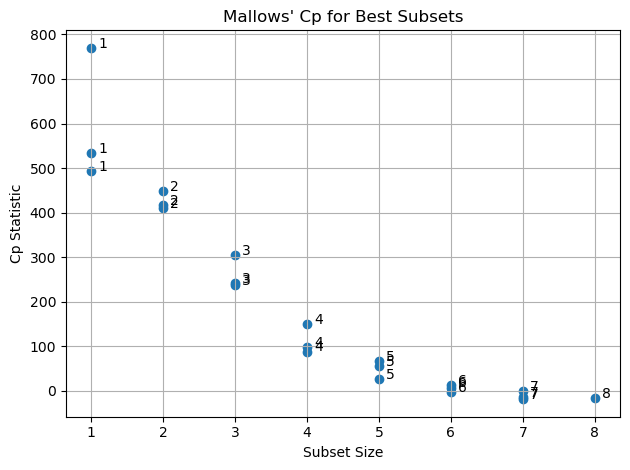

subsets  \
subsets                                                               
7       (obrat, appinc_log, liq_yj0, apr_log, log_netw,...        7   
8       (obrat, fixadj, appinc_log, liq_yj0, apr_log, l...        8   
7       (obrat, fixadj, appinc_log, liq_yj0, apr_log, l...        7   
6       (obrat, appinc_log, liq_yj0, apr_log, log_netw,...        6   
7       (obrat, fixadj, appinc_log, liq_yj0, apr_log, l...        7   
6       (obrat, fixadj, appinc_log, liq_yj0, apr_log, l...        6   
        (obrat, appinc_log, liq_yj0, apr_log, log_netw,...        6   
5       (obrat, appinc_log, liq_yj0, apr_log, log_netw)           5   
        (obrat, appinc_log, apr_log, log_netw, fixadj_l...        5   
        (obrat, fixadj, appinc_log, apr_log, log_netw)            5   
4       (obrat, appinc_log, apr_log, log_netw)                    4   
        (obrat, appinc_log, liq_yj0, apr_log)                     4   
        (appinc_log, liq_yj0, apr_log, log_netw)                  4   
3       (appinc_log, apr_log, log_netw)                           3   
        (appinc_log, liq_yj0, apr_log)                            3   
        (appinc_log, liq_yj0, log_netw)                           3   
2       (liq_yj0, log_netw)                                       2   
        (appinc_log, log_netw)                                    2   
        (obrat, log_netw)                                         2   
1       (log_netw,)                                               1   
        (liq_yj0,)                                                1   
        (apr_log,)                                                1   

                                                                    Cp  
subsets                                                                 
7       (obrat, appinc_log, liq_yj0, apr_log, log_netw,...  -19.068569  
8       (obrat, fixadj, appinc_log, liq_yj0, apr_log, l...  -17.147080  
7       (obrat, fixadj, appinc_log, liq_yj0, apr_log, l...  -13.942699  
6       (obrat, appinc_log, liq_yj0, apr_log, log_netw,...   -3.454850  
7       (obrat, fixadj, appinc_log, liq_yj0, apr_log, l...   -0.229886  
6       (obrat, fixadj, appinc_log, liq_yj0, apr_log, l...    7.000000  
        (obrat, appinc_log, liq_yj0, apr_log, log_netw,...   13.087141  
5       (obrat, appinc_log, liq_yj0, apr_log, log_netw)      26.635170  
        (obrat, appinc_log, apr_log, log_netw, fixadj_l...   55.560017  
        (obrat, fixadj, appinc_log, apr_log, log_netw)       66.357508  
4       (obrat, appinc_log, apr_log, log_netw)               87.898413  
        (obrat, appinc_log, liq_yj0, apr_log)                98.288311  
        (appinc_log, liq_yj0, apr_log, log_netw)            150.287283  
3       (appinc_log, apr_log, log_netw)                     236.601662  
        (appinc_log, liq_yj0, apr_log)                      242.284027  
        (appinc_log, liq_yj0, log_netw)                     304.497955  
2       (liq_yj0, log_netw)                                 410.481041  
        (appinc_log, log_netw)                              415.988332  
        (obrat, log_netw)                                   448.892065  
1       (log_netw,)                                         492.781205  
        (liq_yj0,)                                          533.654623  
        (apr_log,)                                          769.835392

In [138]:
# Calculate residual MSE for Mallows' Cp
mallows1_sig2 = mallows1_reg.mse_resid  # residual MSE (sigma^2 hat)
mallows_n, _ = mallows1.shape  # total number of observations

# Define the negative Mallows' Cp function
def negative_mallows(estimator, X, y):
    y_pred = estimator.predict(X)
    sse = np.sum((y - y_pred) ** 2)
    p = X.shape[1] + 1  # number of predictors + 1 for the intercept
    cp = sse / mallows1_sig2 + 2 * p - mallows_n
    return -cp  # Return negative to maximize during optimization

# Define input data
mallows1_X = mallows1[['obrat', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw', 'fixadj_obrat', 'fixadj_log_netw']]
mallows1_Y = mallows1['loanprc_sq'].values  # Target variable

# Initialize the linear regression model
lr = LinearRegression(fit_intercept=True)

# Using ExhaustiveFeatureSelector from mlxtend
mallows1_efs = EFS(lr,
                   min_features=1,
                   max_features=8,  # Adjust max features based on your preference
                   scoring=negative_mallows,
                   cv=0)  # Set cv to 0 for fitting without cross-validation

# Fit the feature selection process
mallows1_efs = mallows1_efs.fit(mallows1_X, mallows1_Y)


# Extract Mallows' Cp data
mallows1_efs_features = [mallows1_efs.subsets_[p]['feature_names'] for p in mallows1_efs.subsets_]
mallows1_efs_subset = [len(mallows1_efs.subsets_[p]['feature_idx']) for p in mallows1_efs.subsets_]
mallows1_efs_cp = [-mallows1_efs.subsets_[p]['avg_score'] for p in mallows1_efs.subsets_]
mallows1_mallows = pd.DataFrame({'subsets': mallows1_efs_subset, 'Cp': mallows1_efs_cp}, index=mallows1_efs_features)

# Display top 3 subsets by Cp
mallows1_mallows_best = mallows1_mallows.groupby('subsets')[['subsets', 'Cp']].apply(lambda x: x.nsmallest(3, 'Cp'))


# Plotting the best subsets by Mallows' Cp
plt.scatter(mallows1_mallows_best['subsets'], mallows1_mallows_best['Cp'])
plt.title("Mallows' Cp for Best Subsets")
plt.xlabel('Subset Size')
plt.ylabel('Cp Statistic')
for i, sub in enumerate(mallows1_mallows_best['subsets']):
    subset = mallows1_mallows_best.index[i][0]  # Adjusting indexing
    plt.annotate(subset, (sub + 0.1, mallows1_mallows_best.iloc[i]['Cp'] + 0.3))  # Add labels to points
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the sorted DataFrame of results
mallows1_mallows_best.sort_values('Cp')

The AIC, BIC, and Mallows CP agree. They all suggest that we should use 7 dependent variabales in the model, including both interaction terms but excluding `fixadj`.

In [139]:
# New model excluding fixadj
mallows1_reg3 = smf.ols('loanprc_sq ~ obrat + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat + fixadj:log_netw', mallows1).fit()
mallows1_reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             loanprc_sq   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     165.3
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.79e-180
Time:                        14:40:28   Log-Likelihood:                 599.67
No. Observations:                1476   AIC:                            -1183.
Df Residuals:                    1468   BIC:                            -1141.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0122      0.058     17.511      0.000       0.899       1.126
obrat               0.0088      0.001     11.814      0.000       0.007       0.010
appinc_log          0.2456      0.014     17.981      0.000       0.219       0.272
liq_yj0            -0.0466      0.006     -7.805      0.000      -0.058      -0.035
apr_log            -0.2429      0.016    -15.365      0.000      -0.274      -0.212
log_netw           -0.0626      0.006    -10.081      0.000      -0.075      -0.050
fixadj:obrat       -0.0036      0.001     -4.236      0.000      -0.005      -0.002
fixadj:log_netw     0.0341      0.006      5.899      0.000       0.023       0.045
==============================================================================
Omnibus:                       37.251   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.576
Skew:                          -0.200   Prob(JB):                     1.57e-14
Kurtosis:                       3.935   Cond. No.                         495.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Out of all models considered so far, this model has:
- The highest R-squared and Adjusted R-squared 
- The lowest AIC and BIC

Additionally, all coefficients are statistically significant at any confidence level.

#### Test for heteroskedasticity of new model

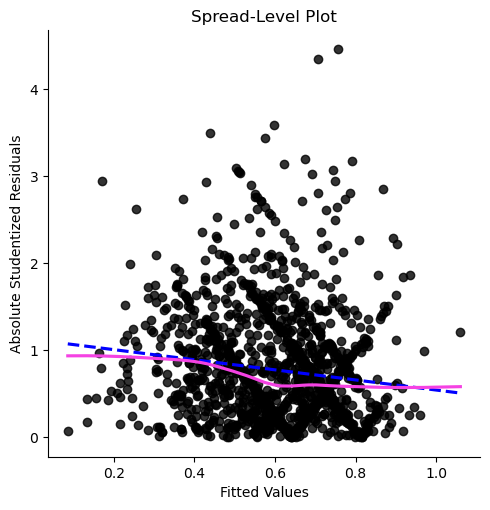

Suggested power transform: 1.4789


In [153]:
# detect heteroskedasticity

# Extract studentized residuals
mallows1_std_resid = mallows1_reg3.get_influence().resid_studentized_external # STUDENTIZED residuals
mallows1_spreadlevel = pd.DataFrame({
    'Fitted Values':mallows1_reg3.fittedvalues,
    'Absolute Studentized Residuals':np.abs(mallows1_std_resid)
})

# Plot spread-level plot
sns.lmplot(mallows1_spreadlevel, x='Fitted Values', y='Absolute Studentized Residuals',
           line_kws={'color':'blue', 'linestyle':'--'}, ci=False, scatter_kws={'color':'black'})
sns.regplot(mallows1_spreadlevel, x='Fitted Values', y='Absolute Studentized Residuals',
            color='#f542e3', lowess=True, scatter=False)
plt.title('Spread-Level Plot')
plt.show()

# Power transform
mallows1_rlm = RLM(endog=np.log(np.abs(mallows1_std_resid)),            # y = log absolute studentized residuals
                   exog=sm.add_constant(np.log(mallows1_reg3.fittedvalues))  # x = log fitted values
                   ).fit()

print(f'Suggested power transform: {1 - mallows1_rlm.params[0]:.4f}')

In [154]:
# BP Test
mallows1_bp3 = sm.stats.het_breuschpagan(resid=mallows1_reg3.resid, exog_het=sm.add_constant(mallows1.drop('loanprc_sq', axis=1)))
print(f'Test statistic: \t{mallows1_bp[0]:.5f}\np-value: \t\t{mallows1_bp[1]:.5f}')

Test statistic: 	32.38317
p-value: 		0.00001


In [155]:
# White Test
sm.stats.diagnostic.het_white(mallows1_reg3.resid, sm.add_constant(mallows1.drop('loanprc_sq', axis=1)))

(121.79312516663,
 1.5845766302060837e-11,
 3.700259718685412,
 4.1514040257772196e-12)

The problem of heteroskedasticity appears to have mildly improved, although it is still present. We will try to mitigate this problem through robust standard errors and FGLS.

In [156]:
# Fit the original model
mallows1_model = smf.ols('loanprc_sq ~ obrat + appinc_log + liq_yj0 + apr_log + log_netw + fixadj_obrat + fixadj_log_netw', data=mallows1)
mallows1_reg = mallows1_model.fit()  # Uncorrected model fit
mallows1_hc1 = mallows1_model.fit(cov_type='HC1')  # Corrected model fit with HC1

# Display coefficient summaries for both models
print('--- Uncorrected Model ---\n', mallows1_reg.summary())
print('\n--- HC1 Corrected Model ---\n', mallows1_hc1.summary())

# Example: Joint test for the coefficients (H0: All coefficients except intercept are zero)
h0 = 'obrat = 0, appinc_log = 0, liq_yj0 = 0, apr_log = 0, log_netw = 0, fixadj_obrat = 0, fixadj_log_netw = 0'

# Perform F-test with the uncorrected model
print('Uncorrected F-test Result:\n', mallows1_reg.f_test(h0))

# Perform F-test with heteroskedasticity-consistent standard errors (HC1)
print('HC1 Corrected F-test Result:\n', mallows1_hc1.f_test(h0))


--- Uncorrected Model ---
                             OLS Regression Results                            
Dep. Variable:             loanprc_sq   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     165.3
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.79e-180
Time:                        15:20:53   Log-Likelihood:                 599.67
No. Observations:                1476   AIC:                            -1183.
Df Residuals:                    1468   BIC:                            -1141.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept      

##### The high F-statistics and extremely low p-values in both tests indicate that the predictors are statistically significant in explaining the variation in the dependent variable. The reduction in the F-statistic from the uncorrected to the HC1 corrected test suggests the presence of heteroskedasticity, and the robust correction adjusts for this, providing more reliable inference.

### FGLS Model

In [165]:
resid = mallows1_reg.resid
resid_sq = resid**2


variance_model = smf.ols('np.log(resid_sq) ~ np.log(appinc_log)', mallows1).fit()

variance_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(resid_sq)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02114
Date:                Wed, 20 Nov 2024   Prob (F-statistic):              0.884
Time:                        15:25:23   Log-Likelihood:                -3261.5
No. Observations:                1476   AIC:                             6527.
Df Residuals:                    1474   BIC:                             6538.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.1347      0.766     -6.699      0.000      -6.638      -3.631
np.log(appinc_log)     0.0777      0.534      0.145      0.884      -0.971       1.126
==============================================================================
Omnibus:                      350.786   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              847.867
Skew:                          -1.281   Prob(JB):                    7.73e-185
Kurtosis:                       5.687   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [162]:
predicted_log_variance = variance_model.fittedvalues

predicted_variance = np.exp(predicted_log_variance)

weights = 1 / predicted_variance

In [163]:
# Fit the weighted least squares model

mallows1_wls = smf.wls('loanprc_sq ~ obrat + appinc_log + liq_yj0 + apr_log + log_netw + fixadj_obrat + fixadj_log_netw', data=mallows1, weights=weights).fit(cov_type='HC1')

mallows1_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             loanprc_sq   R-squared:                       0.441
Model:                            WLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     156.1
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.37e-172
Time:                        15:23:33   Log-Likelihood:                 599.25
No. Observations:                1476   AIC:                            -1183.
Df Residuals:                    1468   BIC:                            -1140.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0127      0.061     16.473      0.000       0.892       1.133
obrat               0.0088      0.001     11.361      0.000       0.007       0.010
appinc_log          0.2459      0.017     14.678      0.000       0.213       0.279
liq_yj0            -0.0467      0.007     -6.894      0.000      -0.060      -0.033
apr_log            -0.2432      0.019    -12.835      0.000      -0.280      -0.206
log_netw           -0.0626      0.007     -9.237      0.000      -0.076      -0.049
fixadj_obrat       -0.0036      0.001     -3.931      0.000      -0.005      -0.002
fixadj_log_netw     0.0342      0.007      5.223      0.000       0.021       0.047
==============================================================================
Omnibus:                       37.415   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.257
Skew:                          -0.198   Prob(JB):                     1.11e-14
Kurtosis:                       3.942   Cond. No.                         496.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

After employing HC1 robust standard errors and the FGLS, we maintain the statistical significance of all our coefficients on the variables.

---
#### Evaluate the robustness of your estimates by bootstrapping your model. Provide a histogram of the bootstrapped estimates, and comment on the findings.
---

In [169]:
# Set random seed for reproducibility
np.random.seed(90095)

# Number of bootstrap iterations
n_iterations = 1000
n_params = len(mallows1_wls.params)  # Number of coefficients including intercept
bootstrap_results = np.zeros((n_iterations, n_params))

# Run bootstrap
for p in range(n_iterations):
    # Resample the data (with replacement)
    mallows1_resampled = resample(mallows1)

    # Fit the model on resampled data
    fitted_model = smf.ols('loanprc_sq ~ obrat + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat + fixadj:log_netw', data=mallows1_resampled).fit()
    
    # Store coefficients
    bootstrap_results[p, :] = fitted_model.params.values

# Convert bootstrap results to DataFrame
param_names = mallows1_wls.params.index.tolist()
bootstrap_df = pd.DataFrame(bootstrap_results, columns=param_names)

# Summary statistics
bootstrap_summary = bootstrap_df.agg(['mean', 'std', 'median'], axis=0).T
bootstrap_summary['lower-95'] = bootstrap_df.apply(lambda x: np.quantile(x, 0.025))
bootstrap_summary['upper-95'] = bootstrap_df.apply(lambda x: np.quantile(x, 0.975))

# Display the summary
print(bootstrap_summary)

                     mean       std    median  lower-95  upper-95
Intercept        1.013956  0.061009  1.013214  0.901119  1.132622
obrat            0.008813  0.000798  0.008829  0.007208  0.010360
appinc_log       0.245613  0.016609  0.245585  0.213226  0.279854
liq_yj0         -0.046428  0.006703 -0.046609 -0.059344 -0.032763
apr_log         -0.243176  0.018244 -0.243173 -0.279512 -0.208217
log_netw        -0.062601  0.006712 -0.062678 -0.075736 -0.049803
fixadj_obrat    -0.003588  0.000913 -0.003599 -0.005523 -0.001875
fixadj_log_netw  0.033974  0.006464  0.034097  0.021729  0.047127


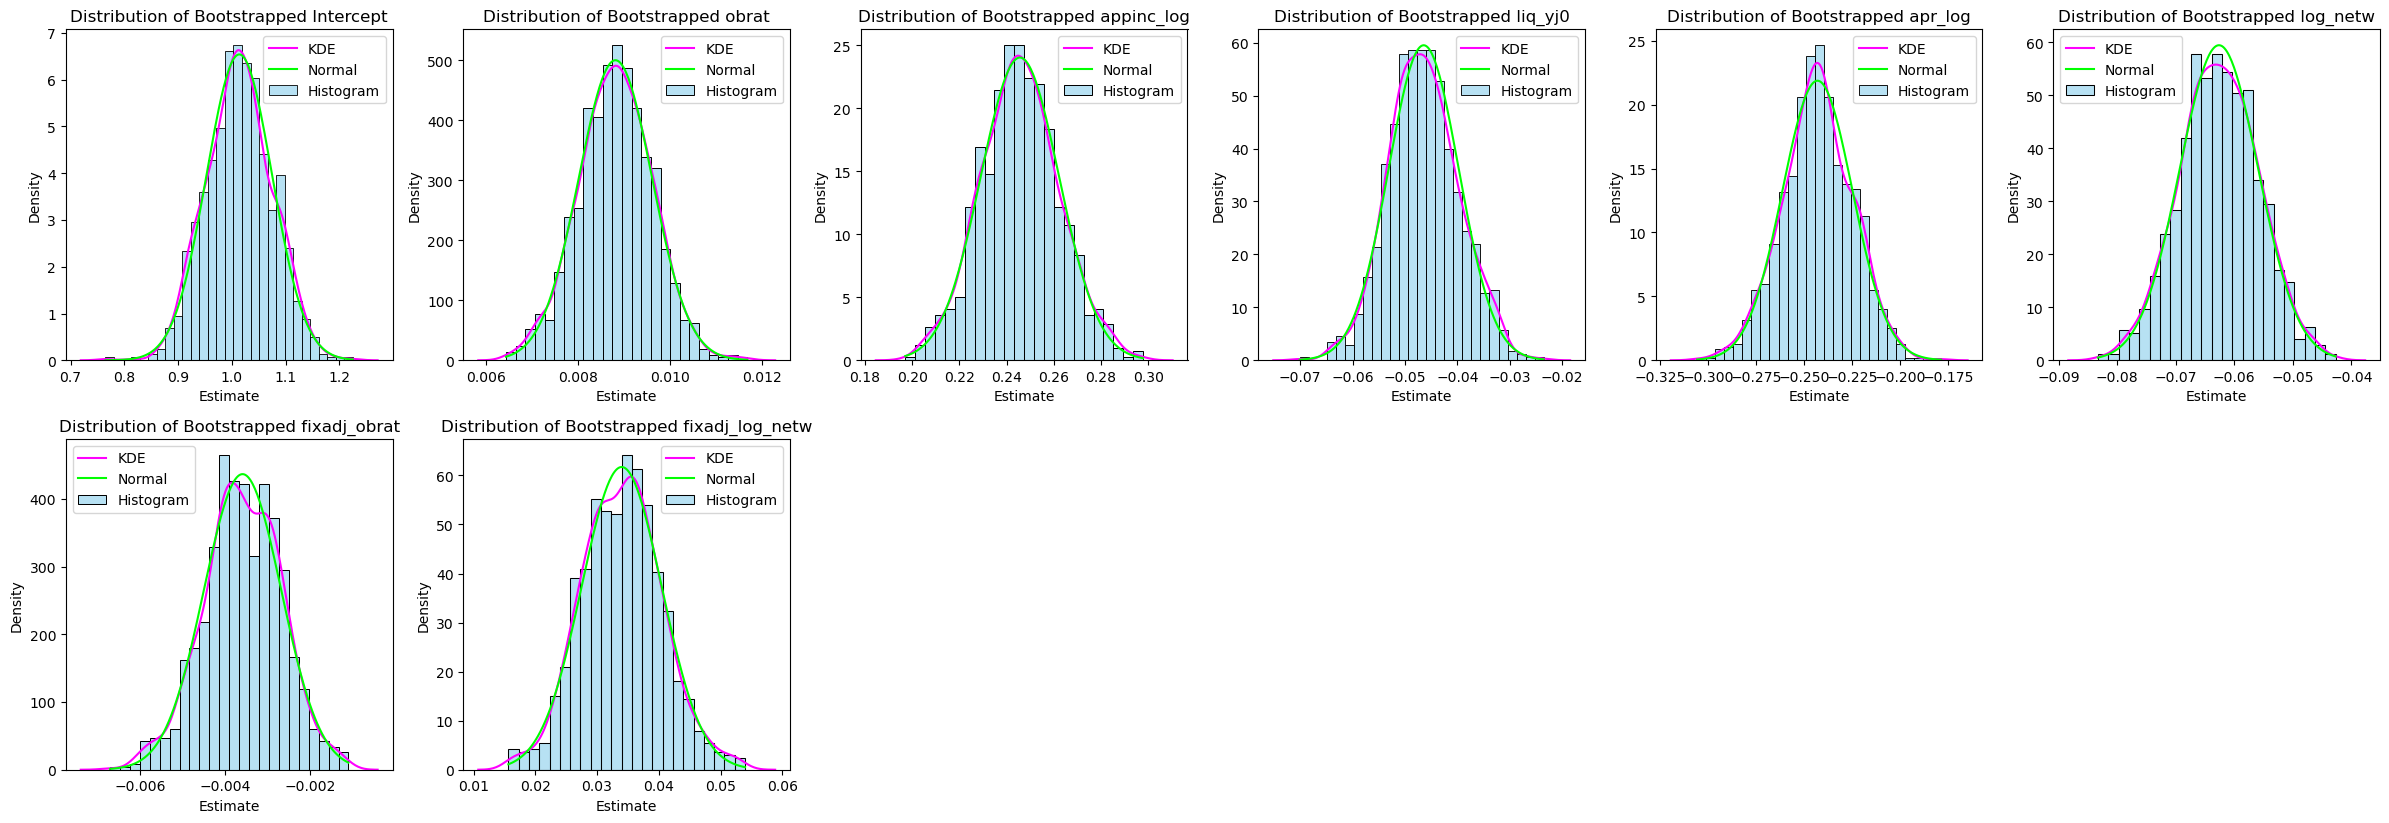

In [170]:
# Plotting bootstrapped estimates
fig, axes = plt.subplots(3, 6, figsize=(24, 12))  # 3x6 grid for visualization (total of 18 subplots)

# Select the first 12 parameters for visualization
parameters_to_plot = bootstrap_summary.index[:12]

for idx, param in enumerate(parameters_to_plot):
    ax = axes[idx // 6, idx % 6]  # Select subplot location in the 3x6 grid
    param_values = bootstrap_df[param]  # Extract bootstrapped estimates for the parameter
    estimate_range = np.linspace(param_values.min(), param_values.max(), 200)

    # Histogram of bootstrapped estimates
    sns.histplot(param_values, stat='density', kde=False, ax=ax, label='Histogram', color='skyblue', alpha=0.6)

    # KDE plot for density estimation
    sns.kdeplot(param_values, color='fuchsia', ax=ax, label='KDE')

    # Normal distribution curve
    mean = bootstrap_summary.loc[param, 'mean']
    std = bootstrap_summary.loc[param, 'std']
    ax.plot(estimate_range, norm.pdf(estimate_range, mean, std), color='lime', label='Normal')

    # Labels and title
    ax.set_title(f'Distribution of Bootstrapped {param}')
    ax.set_xlabel('Estimate')
    ax.set_ylabel('Density')
    ax.legend()

# Handle any unused subplots by hiding them
for idx in range(len(parameters_to_plot), axes.size):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show() 

Our bootstrapped test suggests that our model is stable and robust.

---
#### Use cross-validation to evaluate your model’s performance.
---

In [142]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error

MAE: 0.163, MSE: 0.043, RMSE: 0.207
5-Fold CV RMSE Scores: [0.21503074 0.20307403 0.20261998 0.21584795 0.21542534]
Mean CV RMSE: 0.210, Std Dev: 0.006


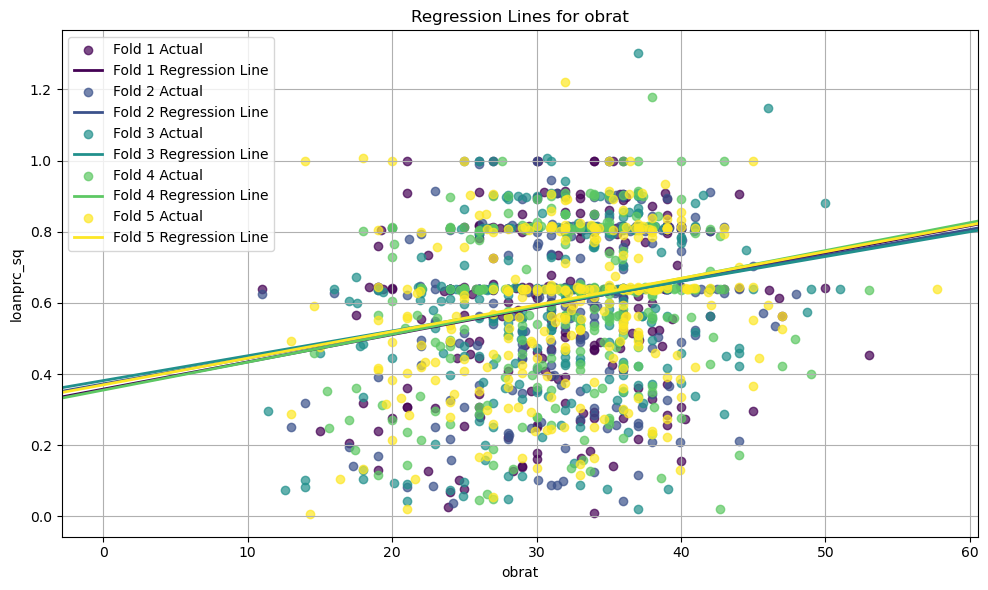

MAE: 0.164, MSE: 0.044, RMSE: 0.210
5-Fold CV RMSE Scores: [0.22001947 0.20923139 0.20183211 0.2221318  0.22325637]
Mean CV RMSE: 0.215, Std Dev: 0.008


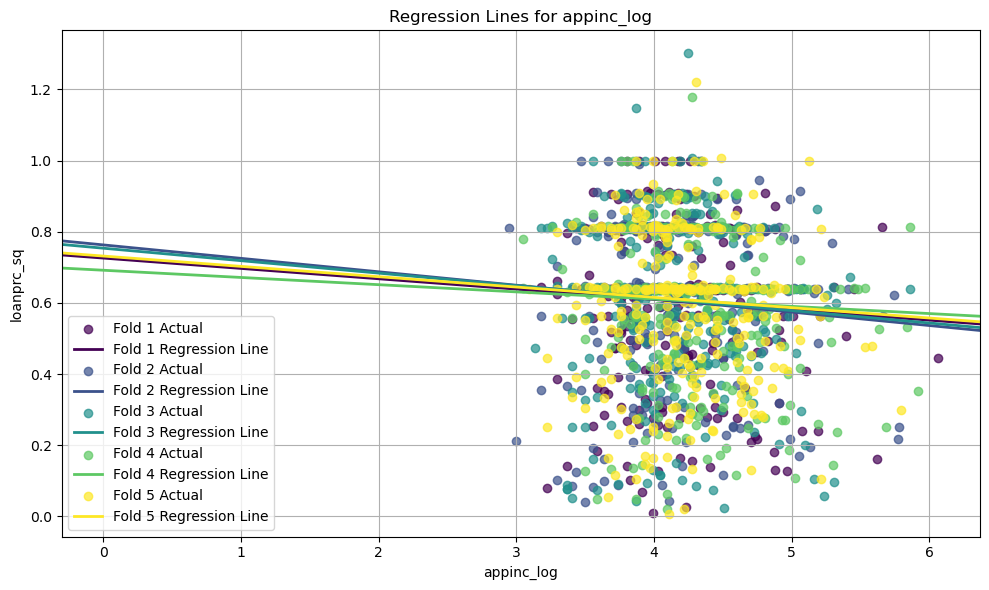

MAE: 0.141, MSE: 0.032, RMSE: 0.180
5-Fold CV RMSE Scores: [0.19568463 0.17820463 0.18404908 0.19360857 0.1996784 ]
Mean CV RMSE: 0.190, Std Dev: 0.008


MAE: 0.155, MSE: 0.039, RMSE: 0.197
5-Fold CV RMSE Scores: [0.20327543 0.19239061 0.18586982 0.21117621 0.21208285]
Mean CV RMSE: 0.201, Std Dev: 0.010


MAE: 0.144, MSE: 0.034, RMSE: 0.183
5-Fold CV RMSE Scores: [0.18609259 0.17433969 0.17539932 0.20711539 0.19889032]
Mean CV RMSE: 0.188, Std Dev: 0.013


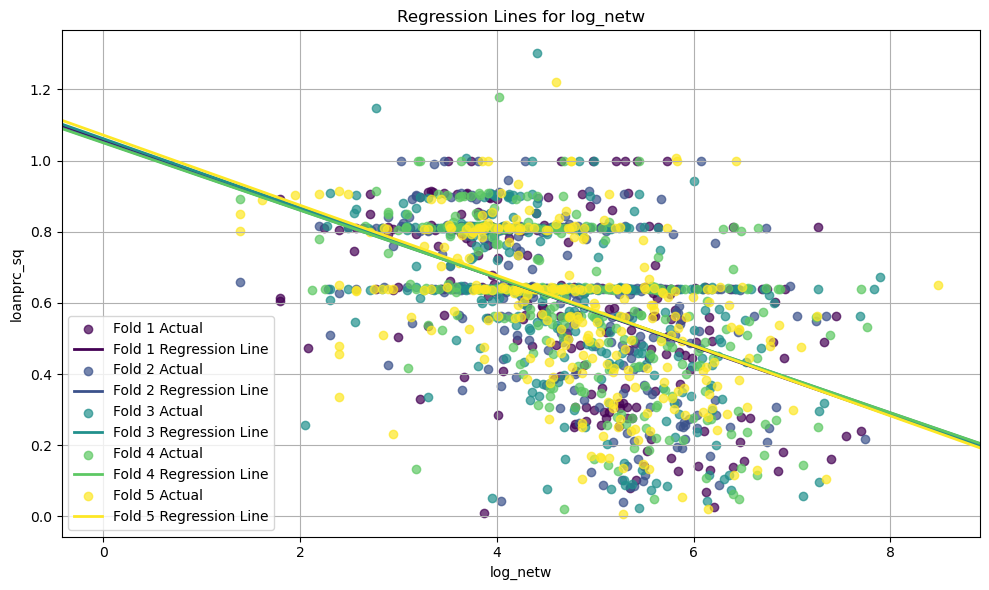

MAE: 0.162, MSE: 0.044, RMSE: 0.209
5-Fold CV RMSE Scores: [0.21844414 0.20909368 0.20174437 0.21995943 0.22297037]
Mean CV RMSE: 0.214, Std Dev: 0.008


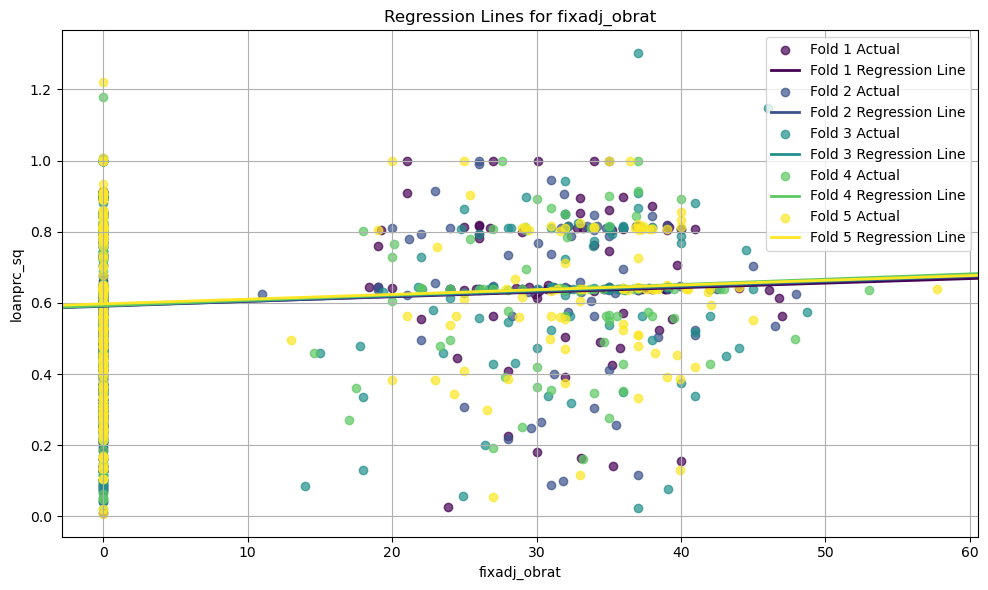

MAE: 0.164, MSE: 0.044, RMSE: 0.210
5-Fold CV RMSE Scores: [0.21943144 0.2103013  0.20281999 0.22049807 0.22417603]
Mean CV RMSE: 0.215, Std Dev: 0.008


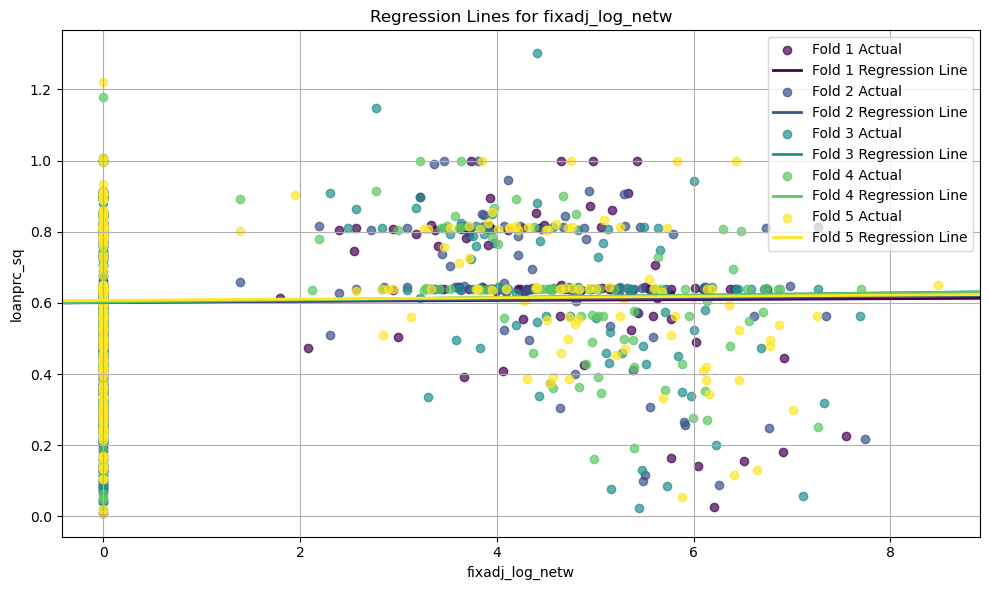

In [143]:
# List of predictor variables (excluding the dependent variable)
predictor_variables = ['obrat', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw', 'fixadj_obrat', 'fixadj_log_netw']  # Add all your predictor variables here
dependent_variable = 'loanprc_sq'  # Dependent variable

# Loop through each predictor variable
for predictor in predictor_variables:
    x = mallows1[[predictor]]  # Select the current predictor variable
    y = mallows1[[dependent_variable]]  # Dependent variable remains the same

    # OLS fit using all the data
    regr = LinearRegression()
    model = regr.fit(x, y)

    # Split the data into train (70%) / test (30%) samples:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

    # Train the model:
    regr = LinearRegression()
    regr.fit(x_train, y_train)

    # Make predictions based on the test sample
    y_pred = regr.predict(x_test)

    # Evaluate Performance
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}")

    # Perform a 5-fold CV and store RMSE scores
    scores = cross_val_score(regr, x, y, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores = -scores  # Negate because scoring gives negative values
    print(f"5-Fold CV RMSE Scores: {rmse_scores}")
    print(f"Mean CV RMSE: {rmse_scores.mean():.3f}, Std Dev: {rmse_scores.std():.3f}")

    # Perform a 5-fold CV and store intercepts and coefficients for each fold
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    intercept_list = []
    coefficient_list = []
    fold_c = ['#440154FF', '#3B528BFF', '#21908CFF', '#5DC863FF', '#FDE725FF']

    plt.figure(figsize=(10, 6))
    for fold, (train_index, test_index) in enumerate(kf.split(x)):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Train the model for this fold
        regr = LinearRegression()
        regr.fit(x_train_fold, y_train_fold)

        # Store the coefficients and intercepts
        intercept = regr.intercept_[0]
        coefficient = regr.coef_[0][0]
        intercept_list.append(intercept)
        coefficient_list.append(coefficient)

        # Scatter plot for actual values in the test set
        plt.scatter(x_test_fold, y_test_fold, c=fold_c[fold], alpha=0.7, label=f'Fold {fold + 1} Actual')

        # Calculate the predicted values for this fold
        y_pred_fold = regr.predict(x_test_fold)

        # Plot the regression line for this fold
        plt.axline(xy1=(0, intercept), slope=coefficient, color=fold_c[fold], 
                   label=f'Fold {fold + 1} Regression Line', linewidth=2)

    # Customizing the plot
    plt.title(f'Regression Lines for {predictor}')
    plt.xlabel(predictor)
    plt.ylabel(dependent_variable)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Aggregated RMSE: 0.1624
Average Coefficients: [ 0.0088377   0.24578814 -0.04666011 -0.24284377 -0.06255528 -0.00359469
  0.03411006]
Average Intercept: 1.0113087676495152


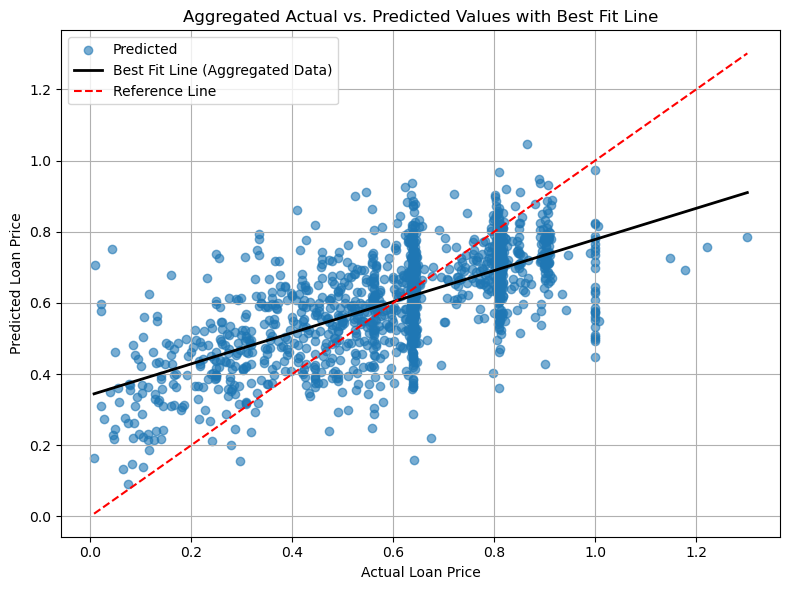

In [144]:
x = mallows1[['obrat', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw', 'fixadj_obrat', 'fixadj_log_netw']]
y = mallows1[['loanprc_sq']]  # Use double brackets for a DataFrame

# Initialize variables for aggregation
aggregated_actual = []
aggregated_predicted = []
aggregated_coefficients = []  # For storing coefficients across folds
aggregated_intercepts = []  # For storing intercepts

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)
regr = LinearRegression()

for train_index, test_index in kf.split(x):
    x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model for this fold
    regr.fit(x_train_fold, y_train_fold)
    
    # Calculate predicted values for this fold
    y_pred_fold = regr.predict(x_test_fold)
    
    # Store coefficients and intercepts
    aggregated_coefficients.append(regr.coef_.flatten())
    aggregated_intercepts.append(regr.intercept_.flatten()[0])
    
    # Append actual and predicted values for aggregation
    aggregated_actual.extend(y_test_fold.values.ravel())  # Convert DataFrame to a flat list
    aggregated_predicted.extend(y_pred_fold.ravel())  # Convert to flat list

# Calculate and print aggregated metrics
rmse = np.sqrt(mean_squared_error(aggregated_actual, aggregated_predicted))
print(f'Aggregated RMSE: {rmse:.4f}')

# Calculate average coefficients and intercept across folds
average_coefficients = np.mean(aggregated_coefficients, axis=0)
average_intercept = np.mean(aggregated_intercepts)
print('Average Coefficients:', average_coefficients)
print('Average Intercept:', average_intercept)

# Plot aggregated actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(aggregated_actual, aggregated_predicted, alpha=0.6, label='Predicted')

# Plot regression line based on the aggregated data's trend
coefficients_for_plotting = np.polyfit(aggregated_actual, aggregated_predicted, 1)  # Linear fit (degree=1)
x_line = np.linspace(min(aggregated_actual), max(aggregated_actual), 100)
y_line = coefficients_for_plotting[0] * x_line + coefficients_for_plotting[1]  # y = mx + b
plt.plot(x_line, y_line, color='black', linestyle='-', linewidth=2, label='Best Fit Line (Aggregated Data)')

# Reference 45-degree line
plt.plot([min(aggregated_actual), max(aggregated_actual)], [min(aggregated_actual), max(aggregated_actual)], color='red', linestyle='--', label='Reference Line')  # 45-degree line
plt.xlabel('Actual Loan Price')
plt.ylabel('Predicted Loan Price')
plt.title('Aggregated Actual vs. Predicted Values with Best Fit Line')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The performance of our model is decent enough with the RMSE 0.1624. However, compared to the 45 degree line, it's still not perfect. 
As expected, there still seems to be problems of heteroskedasticity in our best linear model. However, our FGLS model with robust standard error should mitigate this issue through the adjustment of our coefficients' standard errors.

---
#### Look at Cook’s distance Plot, Residuals Plot, QQ-Plot, etc.
---

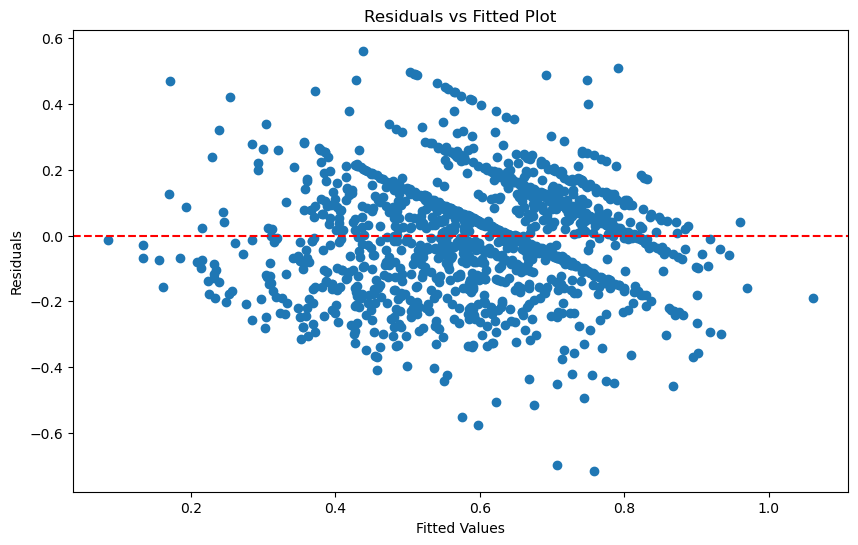

In [172]:
# Cook's Distance Plot
influence = mallows1_reg3.get_influence()
cooks_d = influence.cooks_distance  # Tuple: (values, p-values)

# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d[0])), cooks_d[0], markerfmt=",")
plt.title("Cook's Distance Plot")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

# Residuals Plot
plt.figure(figsize=(10, 6))
plt.scatter(mallows1_wls.fittedvalues, mallows1_reg2.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Plot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# QQ-Plot
qqplot(mallows1_wls.resid, line='s')
plt.title('QQ-Plot')
plt.show()

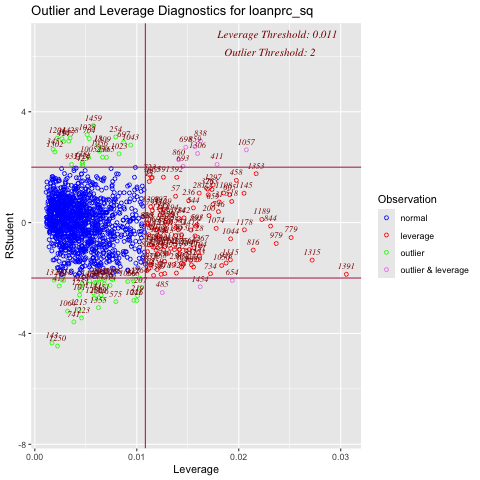

In [148]:
%%R -i mallows1

# Load necessary library for diagnostics
library(olsrr)

# Fit the linear regression model
mreg_mod <- lm(loanprc_sq ~ obrat + appinc_log + liq_yj0 + apr_log + log_netw + fixadj:obrat + fixadj:log_netw, data = mallows1)

# Plot DFBETAS to check for influential data points on each coefficient
ols_plot_resid_lev(mreg_mod)

##### From all the graphs above, we can see that there are several outliers in the residuals at both ends of the theoretical quantiles. Furthermore, the Residuals vs Fitted Values plot also shows patterns which can be attributed to the clustering on some speficifc values of the data for some of our variables, resulting in heteroskedasticity. This result is actually consistent with the previous results we obtained.

---
## Model 2: 'obrat', 'sch', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'
---

In [150]:
# Select initial variables
mallows2 = loanapp4[['loanprc_sq', 'obrat', 'sch', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw']]

# Fit the regression model
mallows2_reg = smf.ols('loanprc_sq ~ obrat + sch + fixadj + appinc_log + liq_yj0 + apr_log + log_netw', data=mallows2).fit()
print(mallows2_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             loanprc_sq   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     158.4
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.19e-174
Time:                        14:58:56   Log-Likelihood:                 585.97
No. Observations:                1476   AIC:                            -1156.
Df Residuals:                    1468   BIC:                            -1114.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9734      0.058     16.750      0.0

We notice that the coefficient on "sch" is not statistically significant even at the 70% confidence level. Thus, we consider removing the variable from the model.

In [152]:
# Fit the regression model without "sch
mallows2_reg = smf.ols('loanprc_sq ~ obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw', data=mallows2).fit()
print(mallows2_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             loanprc_sq   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     184.7
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.61e-175
Time:                        15:08:14   Log-Likelihood:                 585.44
No. Observations:                1476   AIC:                            -1157.
Df Residuals:                    1469   BIC:                            -1120.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9787      0.058     16.906      0.0

It appears that removing `sch` from this model leaves all the key evaluation metrics mostly unchanged, and, if anything, improves some of these. We see:

- No change in R-squared (0.430) and Adjusted R-squared (0.428)
- Increase in the F-statistic (158.4 to 184.7)
- Negligible decrease in AIC (-1156 to -1157)
- Slight decrease in BIC (-1114 to -1120)

Once we remove `sch`, it is now the same as model 1, so we don't need to go any further with the analysis of this model.

---
## Model 3: 'obrat', 'married', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw'¶
---

In [358]:
loanapp3.head()
loanapp4 = loanapp3.copy()
mallows3 = loanapp4[['loanprc_sq', 'obrat', 'married', 'fixadj', 'appinc_log', 'liq_yj0', 'apr_log', 'log_netw']]

mallows3_reg = smf.ols('loanprc_sq ~ obrat + married + fixadj + appinc_log + liq_yj0 + apr_log + log_netw', mallows3).fit()
mallows3_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             loanprc_sq   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     157.8
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          8.62e-174
Time:                        13:40:09   Log-Likelihood:                 587.40
No. Observations:                1476   AIC:                            -1159.
Df Residuals:                    1468   BIC:                            -1116.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9735      0.059     16.565      0.000       0.858       1.089
obrat          0.0078      0.001     10.962      0.000       0.006       0.009
married       -0.0085      0.010     -0.884      0.377      -0.027       0.010
fixadj         0.0436      0.009      4.648      0.000       0.025       0.062
appinc_log     0.2497      0.014     18.133      0.000       0.223       0.277
liq_yj0       -0.0483      0.006     -7.928      0.000      -0.060      -0.036
apr_log       -0.2418      0.016    -14.879      0.000      -0.274      -0.210
log_netw      -0.0494      0.006     -8.406      0.000      -0.061      -0.038
==============================================================================
Omnibus:                       29.259   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.224
Skew:                          -0.183   Prob(JB):                     1.51e-10
Kurtosis:                       3.775   Cond. No.                         476.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We notice that the coefficient on "married" is not statistically significant even at the 70% confidence level. Thus, we consider removing the variable from the model.

In [360]:
mallows3_reg2 = smf.ols('loanprc_sq ~ obrat + fixadj + appinc_log + liq_yj0 + apr_log + log_netw', mallows3).fit()
mallows3_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             loanprc_sq   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     183.9
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          8.98e-175
Time:                        13:40:09   Log-Likelihood:                 587.00
No. Observations:                1476   AIC:                            -1160.
Df Residuals:                    1469   BIC:                            -1123.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9827      0.058     16.997      0.000       0.869       1.096
obrat          0.0078      0.001     10.971      0.000       0.006       0.009
fixadj         0.0437      0.009      4.661      0.000       0.025       0.062
appinc_log     0.2491      0.014     18.113      0.000       0.222       0.276
liq_yj0       -0.0474      0.006     -7.887      0.000      -0.059      -0.036
apr_log       -0.2447      0.016    -15.374      0.000      -0.276      -0.213
log_netw      -0.0496      0.006     -8.439      0.000      -0.061      -0.038
==============================================================================
Omnibus:                       29.921   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.596
Skew:                          -0.185   Prob(JB):                     7.62e-11
Kurtosis:                       3.788   Cond. No.                         467.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears that removing `married` from this model leaves all the key evaluation metrics mostly unchanged, and, if anything, improves some of these. We see:

- No change in R-squared (0.429) and Adjusted R-squared (0.427)
- Increase in the F-statistic (157.8 to 183.9)
- Negligible decrease in AIC (-1159 to -1160)
- Slight decrease in BIC (-1116 to -1123)

Once we remove `married`, it is now the same as model 1, so we don't need to go any further with the analysis of this model.

---
#### Make sure to also discuss any relevant marginal eﬀects estimated.
---

In [174]:
# Final Model
mallows1_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             loanprc_sq   R-squared:                       0.441
Model:                            WLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     156.1
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          2.37e-172
Time:                        15:47:39   Log-Likelihood:                 599.25
No. Observations:                1476   AIC:                            -1183.
Df Residuals:                    1468   BIC:                            -1140.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.0127      0.061     16.473      0.000       0.892       1.133
obrat               0.0088      0.001     11.361      0.000       0.007       0.010
appinc_log          0.2459      0.017     14.678      0.000       0.213       0.279
liq_yj0            -0.0467      0.007     -6.894      0.000      -0.060      -0.033
apr_log            -0.2432      0.019    -12.835      0.000      -0.280      -0.206
log_netw           -0.0626      0.007     -9.237      0.000      -0.076      -0.049
fixadj_obrat       -0.0036      0.001     -3.931      0.000      -0.005      -0.002
fixadj_log_netw     0.0342      0.007      5.223      0.000       0.021       0.047
==============================================================================
Omnibus:                       37.415   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.257
Skew:                          -0.198   Prob(JB):                     1.11e-14
Kurtosis:                       3.942   Cond. No.                         496.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In our final model, the marginal effect of each variable on our dependent variable (`loanprc_sq`) is simply the coefficient we obtain from our regression. This is true for all variables except:
- `obrat`, for which the marginal effect is $$\frac{\partial loanprc^2}{\partial obrat} = \beta_2 + \beta_7 \text{fixadj}$$
- `log_netw`, for which the marginal effect is $$\frac{\partial loanprc^2}{\partial \text{log\_netw}} = \beta_6 + \beta_8 \text{fixadj}$$
- `fixadj`, for which the marginal effect is $$\frac{\partial loanprc^2}{\partial fixadj} = \beta_7 \text{obrat} + \beta_8 \text{log\_netw}$$

---
#### Once you have finalized your model, please provide an interpretation of your model parameters, and any economic insights you learned from it (this includes answering the questions you proposed in the introduction).
---

### Model Interpretation
#### **Intercept (1.0127):**
- **Interpretation**: When all the explanatory variables are zero, the expected value of `loanprc_sq` is approximately **1.0127**. 
- **Economic Insight**: This baseline indicates the loan amount as a percentage of the price (squared) under the absence of influencing factors. However, since variables like `obrat`, `appinc_log`, etc., are not usually zero in practice, this is more of a baseline reference.

#### **obrat (0.0088):**
- **Interpretation**: For a 1 percentage point increase in `obrat` (other obligations as a percentage of total income), holding other variables constant, `loanprc_sq` increases by **0.0088 units** when the loan is fixed (`fixadj = 0`).
- **Economic Insight**: Higher obligations relative to income marginally increase the loan-to-price ratio squared for fixed-rate loans. This could indicate that lenders are willing to approve loans with slightly higher obligations under fixed-rate contracts.

#### **appinc_log (0.2459):**
- **Interpretation**: For a 1-unit increase in the log of applicant income (in thousands), `loanprc_sq` increases by **0.2459 units**, holding all else constant.
- **Economic Insight**: Higher applicant income is strongly associated with higher loan-to-price ratios squared, likely because higher-income borrowers can secure larger loans relative to the asset's price.

#### **liq_yj0 (-0.0467):**
- **Interpretation**: For a 1-unit increase in liquid assets (transformed), `loanprc_sq` decreases by **0.0467 units**, holding other variables constant.
- **Economic Insight**: This counterintuitive relationship suggests that borrowers with more liquid assets might need less financing relative to the price of the asset, as they may rely on their savings instead of taking larger loans.

#### **apr_log (-0.2432):**
- **Interpretation**: For a 1-unit increase in the log of appraised value, `loanprc_sq` decreases by **0.2432 units**, holding other variables constant.
- **Economic Insight**: Larger appraised values (likely for more expensive properties) are associated with a smaller loan-to-price ratio squared, possibly because higher-priced properties are often associated with wealthier borrowers who can afford larger down payments.

#### **log_netw (-0.0626):**
- **Interpretation**: For a 1-unit increase in the log of positive net worth, `loanprc_sq` decreases by **0.0626 units** when the loan is fixed (`fixadj = 0`).
- **Economic Insight**: Higher net worth is linked to smaller loan-to-price ratios squared, reflecting that wealthier individuals rely less on loans for asset purchases.

#### **fixadj_obrat (-0.0036):**
- **Interpretation**: For loans with adjustable rates (`fixadj = 1`), the interaction term suggests that for a 1 percentage point increase in `obrat`, the marginal effect on `loanprc_sq` decreases by **0.0036 units**.
- **Economic Insight**: Adjustable-rate loans appear less sensitive to `obrat` than fixed-rate loans. This could indicate tighter lending standards for adjustable-rate loans when borrowers have higher obligations.

#### **fixadj_log_netw (0.0342):**
- **Interpretation**: For loans with adjustable rates (`fixadj = 1`), the interaction term suggests that for a 1-unit increase in the log of net worth, the marginal effect on `loanprc_sq` increases by **0.0342 units**.
- **Economic Insight**: Borrowers with higher net worth are more likely to secure higher loan-to-price ratios squared under adjustable-rate loans compared to fixed-rate loans, possibly reflecting lenders’ greater confidence in wealthier borrowers.

### Marginal Effects for Interaction Terms

#### **Marginal Effect of `obrat`:**
$$\frac{\partial loanprc^2}{\partial obrat} = \beta_2 + \beta_7 \text{fixadj}$$
- **Fixed Rate (`fixadj = 0`)**: Marginal effect is **0.0088**.
- **Adjustable Rate (`fixadj = 1`)**: Marginal effect is \( 0.0088 - 0.0036 = 0.0052 \).
- **Insight**: `obrat` has a larger impact on fixed-rate loans than adjustable-rate loans. This indicates that obligations matter more for fixed-rate borrowers.

#### **Marginal Effect of `log_netw`:**
$$\frac{\partial loanprc^2}{\partial \text{log\_netw}} = \beta_6 + \beta_8 \text{fixadj}$$
- **Fixed Rate (`fixadj = 0`)**: Marginal effect is **-0.0626**.
- **Adjustable Rate (`fixadj = 1`)**: Marginal effect is \( -0.0626 + 0.0342 = -0.0284 \).
- **Insight**: `log_netw` negatively impacts fixed-rate loans more than adjustable-rate loans. Wealthier borrowers seem to borrow less relative to the price of fixed-rate loans.

#### **Marginal Effect of `fixadj`:**
$$\frac{\partial loanprc^2}{\partial fixadj} = \beta_7 \text{obrat} + \beta_8 \text{log\_netw}$$
- **Insight**: The impact of switching from fixed-rate to adjustable-rate loans depends on the borrower’s `obrat` and `log_netw`. For example:
  - A borrower with high obligations (`obrat`) and low net worth (`log_netw`) would see a decrease in `loanprc_sq` when switching to an adjustable-rate loan.
  - Conversely, a borrower with low `obrat` and high `log_netw` might see an increase in `loanprc_sq` for adjustable-rate loans.

### Model Fit and Diagnostic Insights
- **R-squared (0.441)**: Approximately 44.1% of the variability in `loanprc_sq` is explained by the model. This indicates a moderately good fit, though some variability remains unexplained.
- **Adjusted R-squared (0.438)**: Slightly lower than R-squared, reflecting penalties for including multiple predictors.
- **F-statistic (156.1, p < 0.001)**: The overall model is statistically significant.
- **BIC (-1140)**: Indicates strong evidence that this model is appropriate relative to simpler models.

### Economic Implications
1. **Income and Net Worth**:
   - Borrowers with higher income and net worth generally rely less on loans relative to the property's price, indicating a preference or ability to use personal funds.
   - Adjustable-rate loans are more favorable to wealthier borrowers (`log_netw`) than fixed-rate loans.

2. **Loan Characteristics**:
   - Fixed-rate loans are more sensitive to borrowers’ obligations (`obrat`) than adjustable-rate loans. This reflects that lenders might perceive higher obligations as less risky under fixed terms.

3. **Property Value**:
   - Higher appraised values (`apr_log`) result in lower loan-to-price ratios, suggesting wealthier borrowers who purchase higher-value properties tend to borrow less proportionately.

4. **Interaction Effects**:
   - The interaction between `fixadj` and other variables highlights distinct lending behaviors for fixed vs. adjustable-rate loans. Adjustable-rate loans favor borrowers with higher net worth but are less tolerant of high obligations.

### Recommendations
- Lenders should carefully consider interaction effects when designing loan products, as borrower characteristics like income, obligations, and net worth significantly influence borrowing patterns.
- Borrowers should evaluate how their financial profile aligns with fixed vs. adjustable-rate loans to optimize borrowing costs.

### Research Questions Recap
1. What are the most significant predictors of loan amount as a percentage of the price among quantitative and categorical variables?
2. How do demographic factors such as marital status and education level affect loan amount as a percentage of the price?
3. What role do financial indicators, including income and creditworthiness, play in determining loan amount as a percentage of the price?

#### Answer to 1:
The most significant quantitative predictors of loan-to-price ratio are applicant income, appraised value, net worth, and other obligations as a percentage of income. Captured as the log of income (`appinc_log`), applicant income has a strong positive impact on the loan-to-price ratio squared, indicating that higher-income borrowers can secure larger loans relative to the property price. However, the appraised value (`apr_log`) shows a strong negative effect, reflecting that properties with higher appraised values tend to have smaller loan-to-price ratios, likely because wealthier borrowers make larger down payments. Net worth (`log_netw`) also has a significant negative impact, as borrowers with greater financial reserves rely less on loans. Lastly, other obligations (`obrat`) positively affect loan-to-price ratios for fixed-rate loans. Still, they are moderated by adjustable-rate loan types, indicating that obligations are more scrutinized in fixed-rate lending. Among categorical variables, the loan type (`fixadj`) is particularly important as it interacts significantly with other predictors, such as obligations and net worth, to influence loan pricing dynamics.

#### Answer to 2:
We initially expected factor variables related to marital status and education to be statistically significant in affecting loan prices, but after controlling for other financial indicators—namely, those included in our final model—they did not appear to be statistically significant in affecting loan pricing.

#### Answer to 3:
Financial indicators are central in determining loan terms, with income being the most critical factor. Higher-income is strongly associated with higher loan-to-price ratios, as it signals a borrower’s ability to handle larger loan payments. Creditworthiness is reflected indirectly through variables such as net worth and obligations. Borrowers with higher net worth generally secure smaller loan-to-price ratios, indicating greater financial independence, while those with higher obligations face scrutiny, particularly for fixed-rate loans.